# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (lrti), upper respiratory tract infection (lrti), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [28]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve
from datetime import date
from operator import attrgetter
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [29]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [30]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [31]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [32]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'hx_hosp', 'CCI', 'died_date', 'deregistered_date', 'practice', #'meds_nonabs', 
                   'gp_count_'+str(i), 'antibacterial_brit_'+str(i),
                   'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    # #drop rows with no gp_cons_lrti_i records
    # datum = datum.dropna(subset=['gp_cons_lrti_'+str(i)])
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 'lrti_ab_type_'+str(i): 'ab_type',
                           'gp_count_'+str(i): 'gp_count', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

## 1- Data Preparation

In [33]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')
# data_bmi = pd.read_csv(f'../output/hospitalisation_data/input_bmi.csv.gz')

data.shape

(200000, 244)

In [34]:
# save model outputs
a = open("../output/hospitalisation_prediction_lrti/data_lrti_record_cph_lrti.txt", "w")
a.write("")
a.writelines(['data_lrti_1 #with a record, #with no record: %.0f' % (data['lrti_date_1'].notna().sum()), ', %.0f' % (data['lrti_date_1'].isna().sum()),
              '\ndata_lrti_2 #with a record, #with no record: %.0f' % (data['lrti_date_2'].notna().sum()), ', %.0f' % (data['lrti_date_2'].isna().sum()),
              '\ndata_lrti_3 #with a record, #with no record: %.0f' % (data['lrti_date_3'].notna().sum()), ', %.0f' % (data['lrti_date_3'].isna().sum()),
              '\ndata_lrti_4 #with a record, #with no record: %.0f' % (data['lrti_date_4'].notna().sum()), ', %.0f' % (data['lrti_date_4'].isna().sum()),
              '\ndata_lrti_5 #with a record, #with no record: %.0f' % (data['lrti_date_5'].notna().sum()), ', %.0f' % (data['lrti_date_5'].isna().sum()),
              '\ndata_lrti_6 #with a record, #with no record: %.0f' % (data['lrti_date_6'].notna().sum()), ', %.0f' % (data['lrti_date_6'].isna().sum()),
              '\ndata_lrti_7 #with a record, #with no record: %.0f' % (data['lrti_date_7'].notna().sum()), ', %.0f' % (data['lrti_date_7'].isna().sum()),
              '\ndata_lrti_8 #with a record, #with no record: %.0f' % (data['lrti_date_8'].notna().sum()), ', %.0f' % (data['lrti_date_8'].isna().sum()),
              '\ndata_lrti_9 #with a record, #with no record: %.0f' % (data['lrti_date_9'].notna().sum()), ', %.0f' % (data['lrti_date_9'].isna().sum()),
              '\ndata_lrti_10 #with a record, #with no record: %.0f' % (data['lrti_date_10'].notna().sum()), ', %.0f' % (data['lrti_date_10'].isna().sum()),
              '\ndata_lrti_11 #with a record, #with no record: %.0f' % (data['lrti_date_11'].notna().sum()), ', %.0f' % (data['lrti_date_11'].isna().sum()),
              '\ndata_lrti_12 #with a record, #with no record: %.0f' % (data['lrti_date_12'].notna().sum()), ', %.0f' % (data['lrti_date_12'].isna().sum()),
              '\ndata_lrti_13 #with a record, #with no record: %.0f' % (data['lrti_date_13'].notna().sum()), ', %.0f' % (data['lrti_date_13'].isna().sum()),
              '\ndata_lrti_14 #with a record, #with no record: %.0f' % (data['lrti_date_14'].notna().sum()), ', %.0f' % (data['lrti_date_14'].isna().sum()),
              '\ndata_lrti_15 #with a record, #with no record: %.0f' % (data['lrti_date_15'].notna().sum()), ', %.0f' % (data['lrti_date_15'].isna().sum()),
              '\ndata_lrti_16 #with a record, #with no record: %.0f' % (data['lrti_date_16'].notna().sum()), ', %.0f' % (data['lrti_date_16'].isna().sum()),
              '\ndata_lrti_17 #with a record, #with no record: %.0f' % (data['lrti_date_17'].notna().sum()), ', %.0f' % (data['lrti_date_17'].isna().sum()),
              '\ndata_lrti_18 #with a record, #with no record: %.0f' % (data['lrti_date_18'].notna().sum()), ', %.0f' % (data['lrti_date_18'].isna().sum()),
              '\ndata_lrti_19 #with a record, #with no record: %.0f' % (data['lrti_date_19'].notna().sum()), ', %.0f' % (data['lrti_date_19'].isna().sum()),
              '\ndata_lrti_20 #with a record, #with no record: %.0f' % (data['lrti_date_20'].notna().sum()), ', %.0f' % (data['lrti_date_20'].isna().sum()),
              ])

### 1-2- Additional variables
#### 1-2-1- Calculating Charlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [35]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')
# col18 = data.columns.get_loc('age')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37015
1.0     36821
2.0     33169
3.0     25089
4.0     14993
6.0     12070
7.0      9950
5.0      8341
8.0      7951
9.0      5764
10.0     3377
11.0     1925
12.0     1407
13.0      829
14.0      532
15.0      362
16.0      195
17.0      110
18.0       57
19.0       26
20.0       11
21.0        4
23.0        1
22.0        1
Name: CCI, dtype: int64

## 2- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- Gathering data

In [36]:
#read 12 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12])
data_lrti.reset_index(inplace=True, drop=True)
data_lrti.shape

(215803, 22)

### 2-2- Add season, event, and duration variables
#### Season

In [37]:
# convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
# data_lrti['gp_cons_lrti'] = data_lrti['gp_cons_lrti'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] #gp_cons_lrti
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')
data_lrti.shape

(215803, 23)

In [38]:
data_lrti_practice = data_lrti[['lrti_date', 'practice', 'incdt_lrti_date']]
data_lrti_practice['lrti_date'] = data_lrti_practice['lrti_date'].dt.strftime('%Y-%m-%d')
# data_lrti_practice

data_lrti_practice_2019 = data_lrti_practice[(data_lrti_practice['lrti_date'] >= '2019-07-23') & (data_lrti_practice['lrti_date'] <= '2020-03-24')]
data_lrti_practice_2020 = data_lrti_practice[(data_lrti_practice['lrti_date'] >= '2020-07-23') & (data_lrti_practice['lrti_date'] <= '2021-03-24')]
data_lrti_practice_2021 = data_lrti_practice[(data_lrti_practice['lrti_date'] >= '2021-07-23') & (data_lrti_practice['lrti_date'] <= '2022-03-24')]
data_lrti_practice_2022 = data_lrti_practice[(data_lrti_practice['lrti_date'] >= '2022-07-23')]
data_lrti_practice_2019

data_lrti_practice = pd.concat([data_lrti_practice_2019, data_lrti_practice_2020, data_lrti_practice_2021, data_lrti_practice_2022])
data_lrti_practice.reset_index(inplace=True, drop=True)
data_lrti_practice#.shape

#keep incidental infections only
data_lrti_practice_2019_incdt = data_lrti_practice_2019[(data_lrti_practice_2019['incdt_lrti_date'] == 0)]
# data_lrti_practice_incdt_2019
data_lrti_practice_incdt = data_lrti_practice[(data_lrti_practice['incdt_lrti_date'] == 0)]
# data_lrti_practice_incdt

#groupby practice with 2019 data
data_lrti_practice_2019_groupby = data_lrti_practice_2019.groupby(['practice'])['lrti_date'].describe().reset_index()
# data_lrti_practice_2019_groupby['count'].mean()
data_lrti_practice_incdt_2019_groupby = data_lrti_practice_2019_incdt.groupby(['practice'])['lrti_date'].describe().reset_index()
# data_lrti_practice_incdt_2019_groupby['count'].mean()

#groupby practice with overall data
data_lrti_practice_groupby = data_lrti_practice.groupby(['practice'])['lrti_date'].describe().reset_index()
# data_lrti_practice_groupby['count'].mean()
data_lrti_practice_incdt_groupby = data_lrti_practice_incdt.groupby(['practice'])['lrti_date'].describe().reset_index()
# data_lrti_practice_incdt_groupby['count'].mean()

# save mean practice count
a = open("../output/hospitalisation_prediction_lrti/mean_practice_lrti.txt", "w")
a.write("")
a.writelines(['mean practice lrti in 2019: %.0f' % (data_lrti_practice_2019_groupby['count'].mean()),
              '\nmean practice incidental lrti in 2019: %.0f' % (data_lrti_practice_incdt_2019_groupby['count'].mean()),
              '\nmean practice lrti from 2019 to 2022: %.0f' % (data_lrti_practice_groupby['count'].mean()),
              '\nmean practice incidental lrti from 2019 to 2022: %.0f' % (data_lrti_practice_incdt_groupby['count'].mean()),
              ])

In [39]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get three months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
last_3_month_date_y_m = date.today() - pd.DateOffset(months=3)
last_3_month_date_y_m = last_3_month_date_y_m.strftime('%Y-%m')
#drop any record of data with three months before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_3_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

data_lrti['season'].value_counts()

spring    56878
summer    51972
winter    50860
autumn    41924
Name: season, dtype: int64

In [40]:
data_lrti['date'].min()

'2019-01'

In [41]:
# data_lrti = data_lrti[data_lrti['date'] <= '2019-12']
# data_lrti = data_lrti[(data_lrti['date'] >= '2020-03') & (data_lrti['date']<= '2021-03')]
# data_lrti = data_lrti[data_lrti['date'] >= '2021-04']
data_lrti.shape

(201634, 25)

In [42]:
data_lrti['date'].max()

'2022-07'

#### event and duration variables

In [43]:
#scenario 1
#not hosped (nothing happened)
#data_lrti = data_lrti[data_lrti['admitted_lrti_date'].notnull()]
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0
data_lrti['event_lrti_admitted'].value_counts()

0.0    141172
Name: event_lrti_admitted, dtype: int64

In [44]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days #gp_cons_lrti
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]
data_lrti['delta_lrti_admitted'].value_counts()

268.0     60
96.0      57
40.0      57
18.0      57
30.0      56
          ..
1332.0     1
1333.0     1
1375.0     1
1336.0     1
1335.0     1
Name: delta_lrti_admitted, Length: 1369, dtype: int64

In [45]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_died'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_deregistered'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_lrti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

170076

In [46]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)
data_lrti['event_lrti_admitted'].value_counts()

0.0    171934
1.0      1358
Name: event_lrti_admitted, dtype: int64

In [47]:
#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30
data_lrti['duration_lrti_admitted'].value_counts()

30.0    171986
18.0        57
14.0        52
1.0         51
22.0        50
20.0        50
8.0         47
9.0         47
6.0         46
27.0        46
28.0        46
7.0         45
12.0        45
19.0        45
13.0        45
24.0        44
29.0        43
11.0        43
26.0        42
17.0        42
10.0        41
5.0         41
23.0        41
0.0         40
16.0        40
3.0         39
21.0        38
25.0        38
2.0         35
4.0         35
15.0        32
Name: duration_lrti_admitted, dtype: int64

In [48]:
# give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1
data_lrti['event_lrti_admitted'].value_counts()

0.0    171930
1.0      1362
Name: event_lrti_admitted, dtype: int64

In [49]:
#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

In [50]:
# data_lrti[data_lrti['duration_lrti_admitted']==0][['delta_lrti_admitted', 'lrti_date', 'gp_cons_lrti', 'admitted_lrti_date', 'delta_lrti_admitted', 'delta_admitted_died_deregistered', 'event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[151:200, ['event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[201:250, ['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])
data_lrti[['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])

event_lrti_admitted  duration_lrti_admitted
176896                  1.0                     1.0
93081                   1.0                     1.0
132357                  1.0                     1.0
13420                   1.0                     1.0
171018                  1.0                     1.0
...                     ...                     ...
72445                   0.0                    30.0
72446                   0.0                    30.0
72447                   0.0                    30.0
72436                   0.0                    30.0
215802                  0.0                    30.0

[173252 rows x 2 columns]

In [51]:
# save data shape
a = open("../output/hospitalisation_prediction_lrti/data_shape_cph_lrti_after_season.txt", "w")
a.write("")
a.writelines(['data_lrti #observations, #events: %.0f' % (data_lrti.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti.event_lrti_admitted.value_counts()[1]),
            #   '\ndata_lrti_abs_incdt #observations, #events: %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[1]),
            #   '\ndata_lrti_no_abs_prevl #observations, #events: %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[1]),
            #   '\ndata_lrti_abs_prevl #observations, #events: %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[1])
              ])

### 2-3- Dealing with uninteresting and missing values

In [52]:
# prep before plot
data_lrti['age'][data_lrti['age'] < 0] = np.nan
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_lrti = data_lrti[~(data_lrti['age'] < 18)]  
print(f'Min age: {data_lrti.age.min()}')

## remove died cases
#data_lrti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
# replace 0s with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})

# remove cases with negative gp_count
data_lrti['gp_count'][data_lrti['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [53]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [54]:
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_lrti['region_imp'] = data_lrti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_lrti.region.isnull().sum()}')
    data_lrti = data_lrti[data_lrti['region'].notna()]

print(f'Cound of missing values in variable region: {data_lrti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_lrti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21240
Yorkshire and The Humber    10670
South West                  10650
South East                  10608
East                        10581
East Midlands               10512
North West                  10509
North East                  10473
West Midlands               10385
Name: region, dtype: int64


In [55]:
if ('gp_count' in data_lrti.columns) and (data_lrti['gp_count'].isnull().sum() > 0):
    print(f'Cound of missing values in variable gp_count before changing NAN to zeros: {data_lrti.gp_count.isnull().sum()}')
    print(f'Mean of gp_count values before changing NAN to zeros: {data_lrti.gp_count.mean():.3f}')
    data_lrti['gp_count'] = data_lrti['gp_count'].fillna(0)
    # data_lrti['gp_count'] = data_lrti['gp_count'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable gp_count after changing NANs to zeros: {data_lrti.gp_count.isnull().sum()}')
print(f'Mean of gp_count values after changing NANs to zeros: {data_lrti.gp_count.mean():.3f}')

Cound of missing values in variable gp_count before changing NAN to zeros: 626
Mean of gp_count values before changing NAN to zeros: 3.343

Cound of missing values in variable gp_count after changing NANs to zeros: 0
Mean of gp_count values after changing NANs to zeros: 3.323


In [56]:
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_lrti.antibacterial_brit.mean():.3f}')
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)
    # data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_lrti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 3
Mean of antibacterial_brit values before changing NAN to zeros: 1.247

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.247


In [57]:
if ('hx_hosp' in data_lrti.columns) and (data_lrti['hx_hosp'].isnull().sum() > 0):
    print(f'Cound of missing values in variable hx_hosp before changing NANs to zeros: {data_lrti.hx_hosp.isnull().sum()}')
    print(f'Mean of hx_hosp values before changing NAN to zeros: {data_lrti.hx_hosp.mean():.3f}')
    data_lrti['hx_hosp'] = data_lrti['hx_hosp'].fillna(0)
    # data_lrti['hx_hosp'] = data_lrti['hx_hosp'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable hx_hosp after changing NANs to zeros: {data_lrti.hx_hosp.isnull().sum()}')
print(f'Mean of hx_hosp values after changing NANs to zeros: {data_lrti.hx_hosp.mean():.3f}')


Cound of missing values in variable hx_hosp after changing NANs to zeros: 0
Mean of hx_hosp values after changing NANs to zeros: 0.457


In [58]:
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_lrti.ethnicity.value_counts()}')
    # data_lrti['ethnicity'] = data_lrti['ethnicity'].astype(str)
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_lrti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26485
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    63438
5.0     7895
3.0     7810
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    63438
0.0    26485
5.0     7895
3.0     7810
Name: ethnicity, dtype: int64


In [59]:
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_lrti.smoking_status.value_counts()}')
    # data_lrti['smoking_status'] = data_lrti['smoking_status'].astype(str)
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_lrti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 43978
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    40957
3.0    13771
2.0     6922
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    43978
1.0    40957
3.0    13771
2.0     6922
Name: smoking_status, dtype: int64


In [60]:
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_lrti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_lrti.imd.value_counts()}')
    # data_lrti['imd'] = data_lrti['imd'].astype(str)
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_lrti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_lrti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
1    20337
4    20335
5    20146
2    19904
3    19657
0     5249
Name: imd, dtype: int64


In [61]:
# data_lrti['bmi_cat'] = np.nan
data_lrti['bmi_cat'] = 5
# data_lrti['bmi_cat'] = data_lrti['bmi_cat'].astype(str)
col_bmi_cat = data_lrti.columns.get_loc('bmi_cat')

col_sex = data_lrti.columns.get_loc('sex')
col_age = data_lrti.columns.get_loc('age')
col_bmi = data_lrti.columns.get_loc('bmi')

for idx, x in enumerate(data_lrti['bmi_cat']):
    # if data_lrti.iat[idx, col_age] >= 18: # 18 or older adults
    if data_lrti.iat[idx, col_bmi] >= 30:
        data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_lrti.iat[idx, col_bmi] >= 25) and (data_lrti.iat[idx, col_bmi] < 30):
        data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_lrti.iat[idx, col_bmi] >= 18.5) and (data_lrti.iat[idx, col_bmi] < 25):
        data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_lrti.iat[idx, col_bmi] < 18.5:
        data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #if data_lrti.iat[idx, col_age] < 18: # drop anyone less than 18 year old children
    #     if data_lrti.iat[idx, col_sex] == 0:
    #         for i in range(2, 18):         
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
    #                 data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
    #                 data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_lrti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #     if data_lrti.iat[idx, col_sex] == 1:
    #         for i in range(2, 18):         
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_lrti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    # if data_lrti.iat[idx, col_age] == 1: # 1 year old babies
    #     data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'

data_lrti['bmi_cat'].value_counts()

1    54879
5    26971
2    11764
3     8525
4     3489
Name: bmi_cat, dtype: int64

In [62]:
if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')
    # data_lrti['bmi_cat'] = data_lrti['bmi_cat'].astype(str)
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    54879
5    26971
2    11764
3     8525
4     3489
Name: bmi_cat, dtype: int64


In [63]:
data_lrti.ab_type.value_counts()

Amoxicillin       6347
Doxycycline       2137
Cefixime          1098
Cefoxitin         1095
Cefprozil         1088
Lymecycline       1070
Cefalexin         1061
Trimethoprim      1056
Fosfomycin        1051
Aztreonam         1042
Cefamandole       1039
Clarithromycin    1035
Demeclocycline     999
Cefotaxime         952
Name: ab_type, dtype: int64

In [64]:
data_lrti.ab_type.isnull().sum()

84558

In [65]:
data_lrti.lrti_ab_date.isnull().sum()

95081

In [66]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])

#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)
data_lrti['ab_type_cat'].value_counts()

no             95081
0               8387
other           1303
Amoxicillin      660
Doxycycline      197
Name: ab_type_cat, dtype: int64

### 2-4- Translate values 

In [67]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [68]:
# reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

In [69]:
data_lrti['ab_type_cat'].value_counts()

no             95081
other           9690
Amoxicillin      660
Doxycycline      197
Name: ab_type_cat, dtype: int64

### 2-5- Categorising and assigning max value for continuous variables

In [70]:
# categorising
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_lrti['CCI_cat'].value_counts()

low          36893
medium       20842
very_low     19774
very_high    17264
high         10855
Name: CCI_cat, dtype: int64

In [71]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['gp_count'].clip(0, data_lrti['gp_count'].quantile(0.95), inplace=True)
# data_lrti['gp_count'].max()

data_lrti['gp_count_cat'] = pd.cut(data_lrti['gp_count'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_lrti['gp_count_cat'].value_counts()

low       58201
medium    24069
high      23358
Name: gp_count_cat, dtype: int64

In [72]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)
data_lrti['antibacterial_brit'].max()

data_lrti['antibacterial_brit_cat'] = pd.cut(data_lrti['antibacterial_brit'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_lrti['antibacterial_brit_cat'].value_counts()

low       61319
high      26200
medium    18109
Name: antibacterial_brit_cat, dtype: int64

In [73]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['hx_hosp'].clip(0, data_lrti['hx_hosp'].quantile(0.95), inplace=True)
data_lrti['hx_hosp'].max()

data_lrti['hx_hosp_cat'] = pd.cut(data_lrti['hx_hosp'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_lrti['hx_hosp_cat'].value_counts()

low       94959
high       9023
medium     1646
Name: hx_hosp_cat, dtype: int64

## 3- Plots

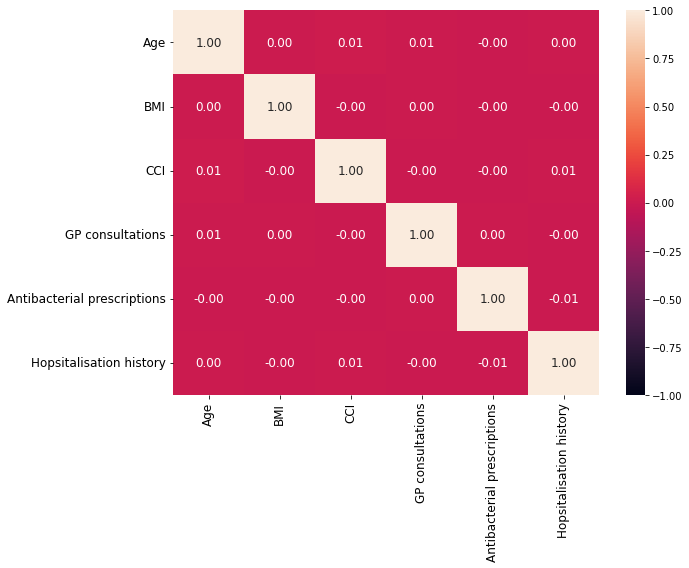

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'gp_count', 'antibacterial_brit', 'hx_hosp']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

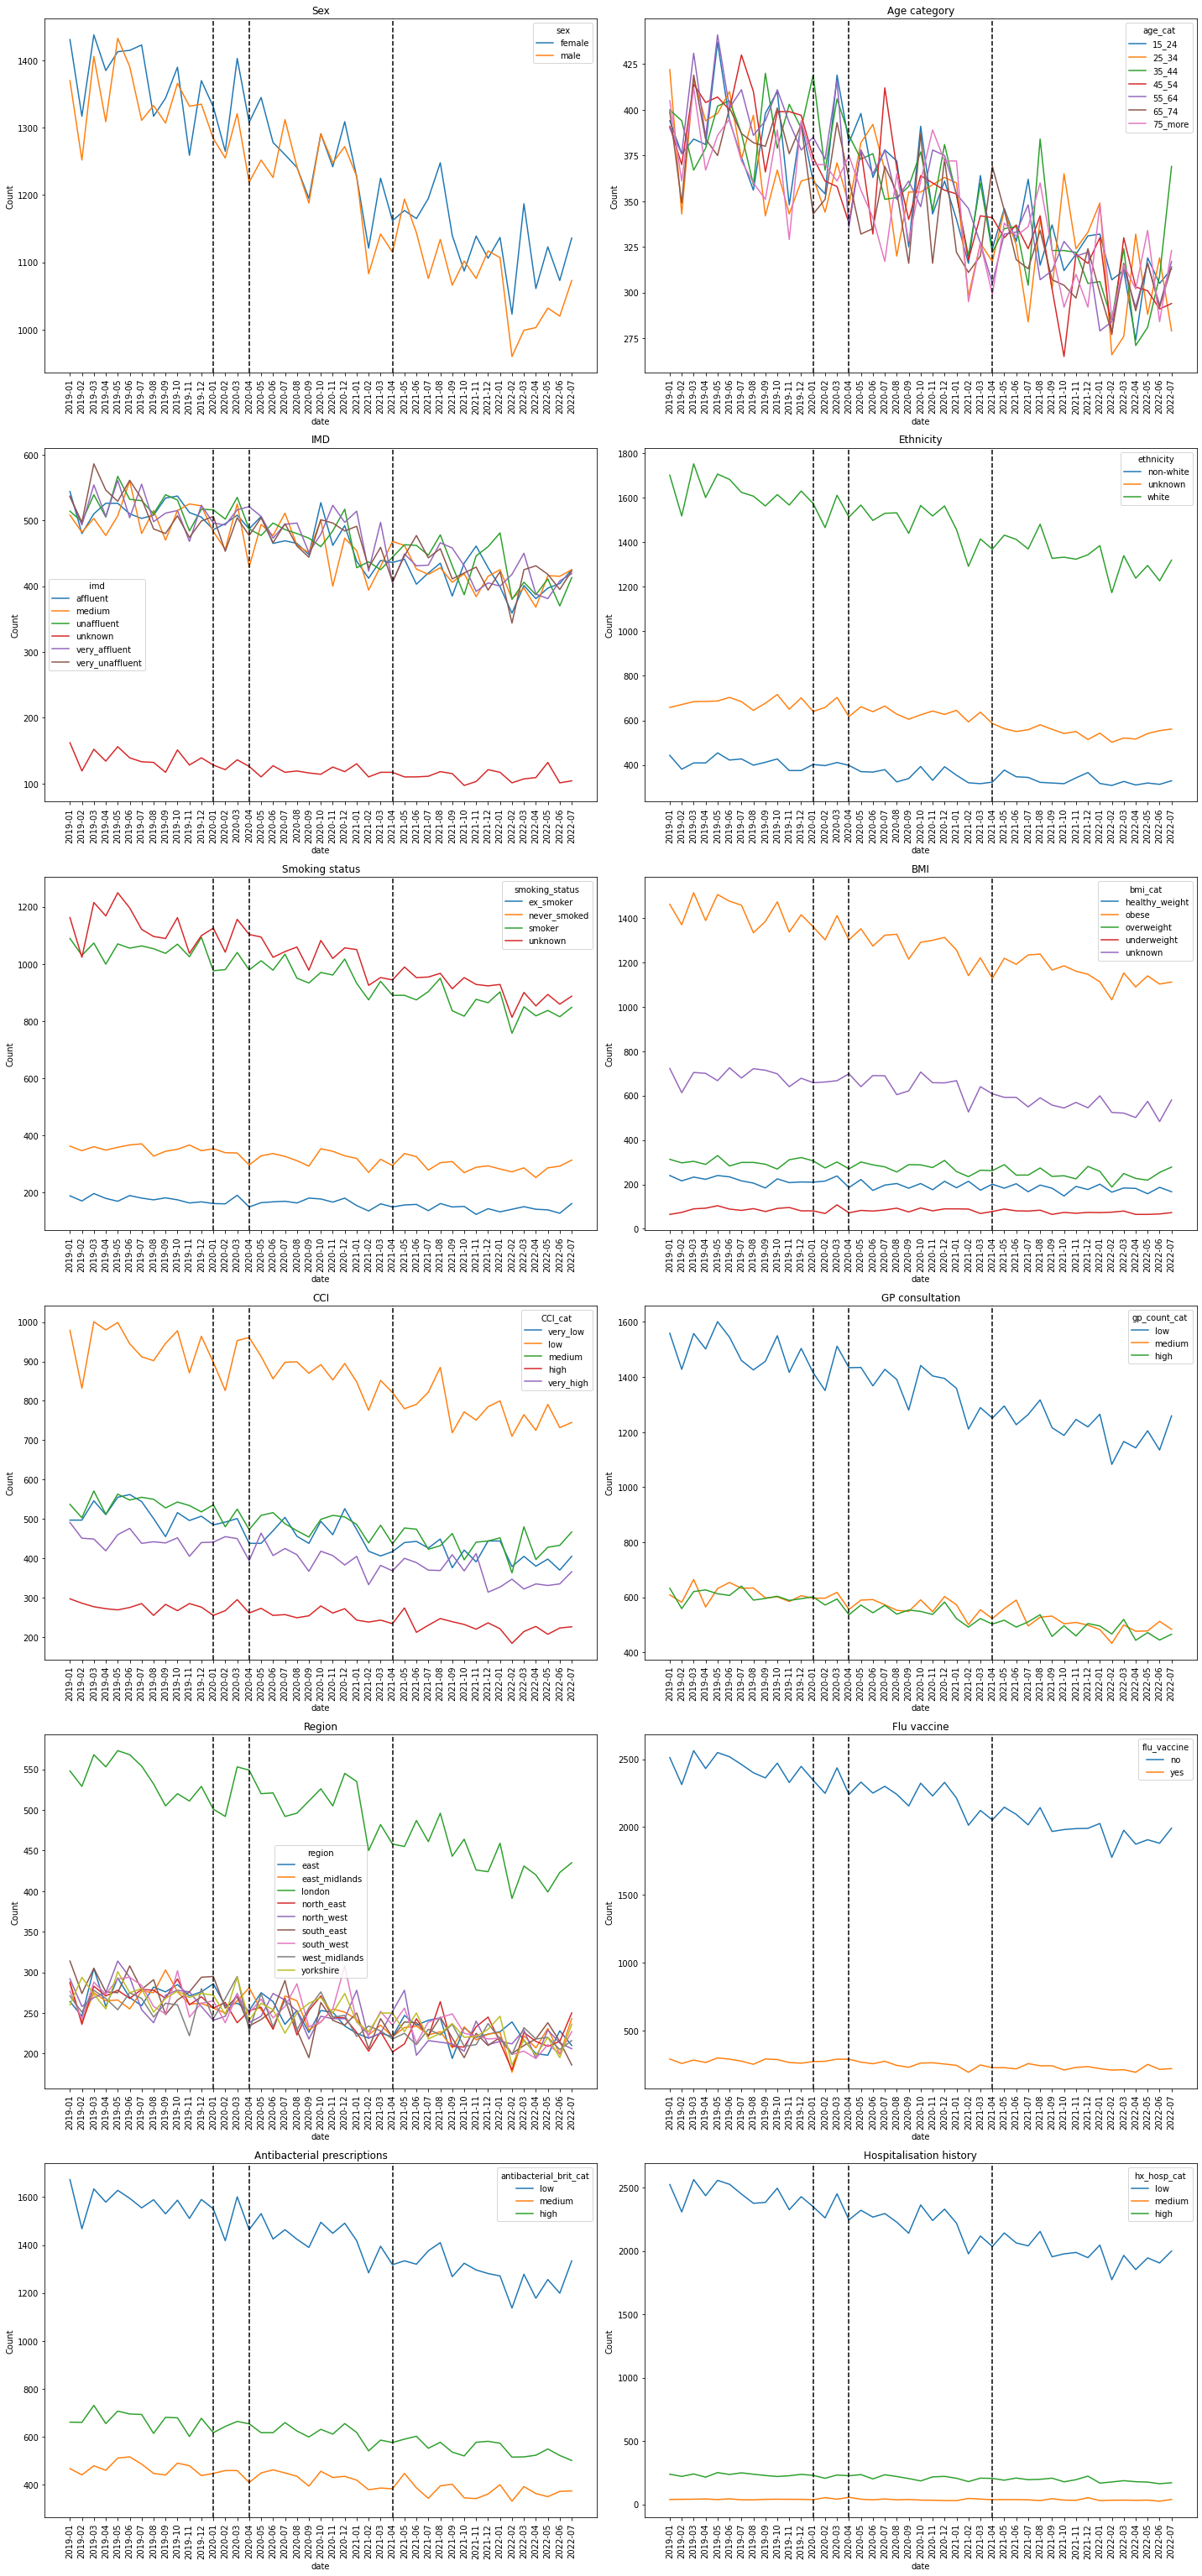

In [75]:
fig, axes = plt.subplots(6,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_lrti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_lrti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_lrti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_lrti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_lrti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_lrti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_lrti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_lrti, 'gp_count_cat', 'GP consultation', axes[3,1])
create_lineplot(data_lrti, 'region', 'Region', axes[4,0])
create_lineplot(data_lrti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_lrti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_lrti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
create_lineplot(data_lrti, 'hx_hosp_cat', 'Hospitalisation history', axes[5,1])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of lrti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/risk_factors_cat_lrti.jpg')
plt.show()

## 4- Separate data of incident/prevalent and with/without antibiotics
We separate data of lrti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [76]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date',
                       'event_lrti_admitted', 'duration_lrti_admitted'
                        ]]

data_lrti.shape

(105628, 17)

In [77]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

# #incident and prevalent infection stratified by ab categories
# data_lrti_incdt_abtype_0 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[0]]
# data_lrti_incdt_abtype_1 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[1]]
# data_lrti_incdt_abtype_2 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[2]]
# data_lrti_incdt_abtype_3 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[3]]
# data_lrti_prevl_abtype_0 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[0]]
# data_lrti_prevl_abtype_1 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[1]]
# data_lrti_prevl_abtype_2 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[2]]
# data_lrti_prevl_abtype_3 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_lrti_incdt_abs = data_lrti_incdt[data_lrti_incdt['lrti_ab_date'] == 1]
# data_lrti_prevl_abs = data_lrti_prevl[data_lrti_prevl['lrti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()] #gp_cons_lrti_ab
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

print(f'shape of data_lrti_incdt: {data_lrti_incdt.shape}')
print(f'shape of data_lrti_prevl: {data_lrti_prevl.shape}')
print(f'shape of data_lrti_no_abs_incdt: {data_lrti_no_abs_incdt.shape}')
print(f'shape of data_lrti_abs_incdt: {data_lrti_abs_incdt.shape}')
print(f'shape of data_lrti_no_abs_prevl: {data_lrti_no_abs_prevl.shape}')
print(f'shape of data_lrti_abs_prevl: {data_lrti_abs_prevl.shape}')

shape of data_lrti_incdt: (94954, 17)
shape of data_lrti_prevl: (10674, 17)
shape of data_lrti_no_abs_incdt: (85459, 17)
shape of data_lrti_abs_incdt: (9495, 17)
shape of data_lrti_no_abs_prevl: (9622, 17)
shape of data_lrti_abs_prevl: (1052, 17)


In [78]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


In [79]:
print(f'shape of data_lrti_no_abs_incdt: \n{data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'shape of data_lrti_abs_incdt: \n{data_lrti_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'shape of data_lrti_no_abs_prevl: \n{data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()}')
print(f'shape of data_lrti_abs_prevl: \n{data_lrti_abs_prevl.event_lrti_admitted.value_counts()}')

shape of data_lrti_no_abs_incdt: 
0.0    84815
1.0      644
Name: event_lrti_admitted, dtype: int64
shape of data_lrti_abs_incdt: 
0.0    9423
1.0      72
Name: event_lrti_admitted, dtype: int64
shape of data_lrti_no_abs_prevl: 
0.0    9547
1.0      75
Name: event_lrti_admitted, dtype: int64
shape of data_lrti_abs_prevl: 
0.0    1041
1.0      11
Name: event_lrti_admitted, dtype: int64


In [80]:
# # save data shape
# a = open("../output/hospitalisation_prediction_lrti/data_shape_cph_lrti.txt", "w")
# a.write("")
# a.writelines(['data_lrti_no_abs_incdt #observations, #events: %.0f' % (data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()[1]),
#               '\ndata_lrti_abs_incdt #observations, #events: %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[1]),
#               '\ndata_lrti_no_abs_prevl #observations, #events: %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[1]),
#               '\ndata_lrti_abs_prevl #observations, #events: %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[1])
#               ])

## 5- Cox modelling for hospital admissions related to infections 
### 5-1- hospital admission related to incidental lrti with no antibiotics

In [81]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_lrti_admitted', 'duration_lrti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [82]:
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

In [83]:
# #keep relevant variables
# data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
#                                                  'imd', 'ethnicity', 'smoking_status', 'season', 
#                                                 # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
#                                                  'antibacterial_brit', #'gp_count', #'meds_nonabs', 'hx_hosp',
#                                                  'event_lrti_admitted', 'duration_lrti_admitted']]

# data_lrti_no_abs_incdt.shape

In [84]:
# # encoding categorical data for CPH
# data = data_lrti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
# # data

# # creating instance of one-hot-encoder
# enc = OneHotEncoder()
# results = enc.fit_transform(data)
# data_lrti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
# data_lrti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
# data_lrti_no_abs_incdt_enc = data[['antibacterial_brit']].join(data_lrti_no_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

# data_lrti_no_abs_incdt_enc.head()

In [85]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [86]:
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

In [87]:
# #summary table
# summary_table_lrti_no_abs_incdt = data_lrti_no_abs_incdt_enc.sum(axis=0).reset_index()
# summary_table_lrti_no_abs_incdt.columns = ['variable', 'count']
# #round count to make last digit either 0 or 5
# summary_table_lrti_no_abs_incdt['mean'] = data_lrti_no_abs_incdt_enc.mean(axis=0).reset_index()[0]
# summary_table_lrti_no_abs_incdt['count'] = round_five_mul(summary_table_lrti_no_abs_incdt['count'], base=5)
# summary_table_lrti_no_abs_incdt['std'] = data_lrti_no_abs_incdt_enc.std(axis=0).reset_index()[0]
# #replace small counts (<=5) with 'SM'
# summary_table_lrti_no_abs_incdt.loc[(summary_table_lrti_no_abs_incdt['count'] <= 5), 'count'] = 'SM'
# # summary_table_lrti_no_abs_incdt

# # save table
# summary_table_lrti_no_abs_incdt.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_no_abs_incdt.csv', index=False)

In [88]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [89]:
make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

In [90]:
# #keep hospitalised cses (events=1)
# data_lrti_no_abs_incdt_hosped = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['event_lrti_admitted'] == 1]

# # encoding categorical hosped data
# data_hosped = data_lrti_no_abs_incdt_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
# # data_hosped

# # creating instance of one-hot-encoder
# enc = OneHotEncoder()
# results = enc.fit_transform(data_hosped)
# data_lrti_no_abs_incdt_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
# data_lrti_no_abs_incdt_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
# data_lrti_no_abs_incdt_hosped_enc = data_hosped[['antibacterial_brit']].join(data_lrti_no_abs_incdt_hosped_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

# # data_lrti_no_abs_incdt_hosped_enc#.head()

# #summary table for hosped cases
# summary_table_lrti_no_abs_incdt_hosped = data_lrti_no_abs_incdt_hosped_enc.sum(axis=0).reset_index()
# summary_table_lrti_no_abs_incdt_hosped.columns = ['variable', 'count']
# summary_table_lrti_no_abs_incdt_hosped['mean'] = data_lrti_no_abs_incdt_hosped_enc.mean(axis=0).reset_index()[0]
# #round count to make last digit either 0 or 5
# summary_table_lrti_no_abs_incdt_hosped['count'] = round_five_mul(summary_table_lrti_no_abs_incdt_hosped['count'], base=5)
# summary_table_lrti_no_abs_incdt_hosped['std'] = data_lrti_no_abs_incdt_hosped_enc.std(axis=0).reset_index()[0]
# #replace small counts (<=5) with 'SM'
# summary_table_lrti_no_abs_incdt_hosped.loc[(summary_table_lrti_no_abs_incdt_hosped['count'] <= 5), 'count'] = 'SM'
# # summary_table_lrti_no_abs_incdt_hosped

# # save table
# summary_table_lrti_no_abs_incdt_hosped.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_no_abs_incdt_hosped.csv', index=False)

In [91]:
# a = ['age', 'sex']
# b = ['eth']
# c = a+b
# c
# # d = print('"',*c, sep=' + ', end='"')
# # d = print(*c, sep=' + ', end='"')

In [92]:
# li = []
# for i in range(0,len(c)):
#     q = c[i].replace("'", "")
#     # c[i] = c[i].replace("'", "")
#     li.append(q)
#     formula = ""+ li[i] + " + "
#     # liii = li.replace("'", "@")
#     # # liii = 
#     print(formula)

In [93]:
# for j in range(0, len(li)):
#     formula[] = []
#     formula = li[j] + " + "
#     # formula = 

In [94]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    # plot betas
    fig, ax = plt.subplots(figsize=(7, 15))
    cph.plot()
    # plt.suptitle('Coefficients of Cox model for hospital admission related to '+infection+'_'+infection_type+'', fontsize=16)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_cph_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return cph, data_train, data_test

<lifelines.CoxPHFitter: fitted with 64094 total observations, 63617 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 64094
number of events observed = 477
   partial log-likelihood = -5257.87
         time fit was run = 2022-11-02 10:30:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.13            -0.34             0.16                 0.71                 1.18
CCI_cat[T.medium]               -0.07       0.94       0.14            -0.35             0.22                 0.71                 1.24
CCI_cat[T.high]                 -0.07       0.93       0.18            -0.42             0.27                 0.66                 1.31
CCI_cat[T.very_high]            -0.15       0.86       0.16            -0.46             0.15                 0.63                 1.17
age_cat[T.25_34]                 0.24       1.27       0.17            -0.10             0.57                 0.91                 1.78
age_cat[T.35_44]                 0.06       1.07       0.18            -0.28             0.41                 0.75                 1.51
age_cat[T.45_54]                 0.07       1.08       0.18            -0.27             0.42                 0.76                 1.53
age_cat[T.55_64]                 0.14       1.15       0.18            -0.20             0.49                 0.82                 1.63
age_cat[T.65_74]                 0.18       1.20       0.17            -0.16             0.53                 0.85                 1.69
age_cat[T.75_more]               0.11       1.12       0.18            -0.23             0.46                 0.79                 1.59
antibacterial_brit               0.10       1.11       0.03             0.04             0.16                 1.04                 1.18
bmi_cat[T.obese]                -0.05       0.95       0.18            -0.40             0.30                 0.67                 1.35
bmi_cat[T.overweight]            0.28       1.32       0.20            -0.12             0.68                 0.89                 1.97
bmi_cat[T.underweight]          -0.17       0.84       0.32            -0.81             0.46                 0.45                 1.58
bmi_cat[T.unknown]               0.03       1.03       0.19            -0.34             0.40                 0.71                 1.49
ethnicity[T.unknown]            -0.06       0.94       0.15            -0.35             0.22                 0.70                 1.25
ethnicity[T.white]              -0.09       0.92       0.13            -0.34             0.17                 0.71                 1.18
flu_vaccine[T.yes]               0.08       1.09       0.15            -0.20             0.37                 0.82                 1.45
imd[T.medium]                   -0.21       0.81       0.15            -0.50             0.09                 0.61                 1.09
imd[T.unaffluent]               -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.25
imd[T.unknown]                  -0.21       0.81       0.24            -0.67             0.25                 0.51                 1.29
imd[T.very_affluent]            -0.08       0.92       0.14            -0.36             0.20                 0.70                 1.22
imd[T.very_unaffluent]          -0.29       0.75       0.15            -0.58             0.01                 0.56                 1.01
region[T.east_midlands]         -0.03       0.97       0.21            -0.44             0.37                 0.64                 1.45
region[T.london]                 0.01       1.01       0.18         

12777


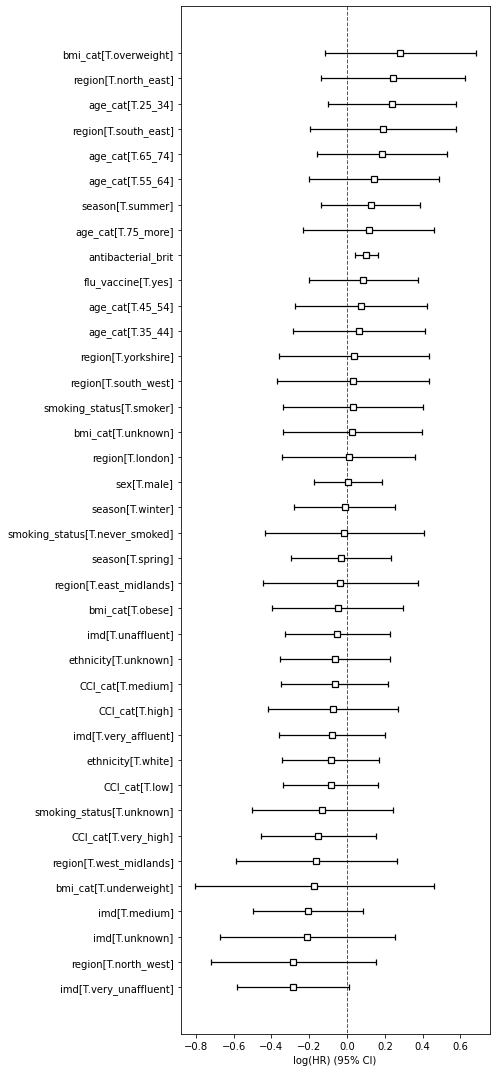

In [95]:
cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

In [96]:
# #randomly splitting data into training (%75) and testing (%25)
# data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = train_test_split(data_lrti_no_abs_incdt, test_size=0.25, random_state=42)

# print(f'shape of data_lrti_no_abs_incdt for training: {data_lrti_no_abs_incdt_train.shape}')
# print(f'shape of data_lrti_no_abs_incdt for testing: {data_lrti_no_abs_incdt_test.shape}')

In [97]:
# cph_lrti_no_abs_incdt = CoxPHFitter()
# cph_lrti_no_abs_incdt.fit(data_lrti_no_abs_incdt_train,
#         duration_col='duration_lrti_admitted',
#         event_col='event_lrti_admitted',
#         formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"# + gp_count"# + meds_nonabs + hx_hosp 
#         )
# cph_lrti_no_abs_incdt.print_summary()

# #save model output
# output = GetPrintSummary(cph_lrti_no_abs_incdt)
# with open('../output/hospitalisation_prediction_lrti/cph_lrti_no_abs_incdt_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [98]:
# # plot betas
# fig, ax = plt.subplots(figsize=(7, 15))
# cph_lrti_no_abs_incdt.plot()
# # plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
# plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_lrti/coef_cph_lrti_no_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [99]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]#, 'count']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [100]:
#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')

In [101]:
# # cleaning up covariates to make them compatible with the encoded data
# covariates = cph_lrti_no_abs_incdt.params_.reset_index()#.hazard_ratios_
# covariates.covariate = covariates.covariate.str.replace("[","")
# covariates.covariate = covariates.covariate.str.replace("]","")
# covariates.covariate = covariates.covariate.str.replace("T.","_")
# # covariates.shape

# # save coefficients
# covariates.to_csv('../output/hospitalisation_prediction_lrti/betas_cph_lrti_no_abs_incdt.csv', index=False)

# # transpose and sort covariates and coefficients
# covariatesT = covariates.T
# # covariatesT.covariate = covariates
# header = covariatesT.iloc[0]
# covariatesT = covariatesT[1:]
# covariatesT.columns = header
# covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# # covariatesT.shape

# # further cleaning up covariates to make them compatible with the encoded data
# mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
# mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

# #match mylist (covariates of cox model) with encoded data
# data = data_lrti_no_abs_incdt_enc[data_lrti_no_abs_incdt_enc.columns.intersection(mylist)] 
# data = data.sort_index(axis = 1) #sort 
# # data.shape

# # multiply betas and encoded data
# betas = data.multiply(np.array(covariatesT), axis='columns')
# # betas

# # sum up betas of each row to calculate sum of betas 
# sum_betas = betas.sum(axis=1)
# sum_betas

In [102]:
# # predict cumulative hazard values at day 30 and match them with sum of betas
# sum_betas_hazard = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt).loc[[30]].T.reset_index(drop=True)
# sum_betas_hazard['sum_betas'] = sum_betas
# # sum_betas_hazard

# # sort values of sum of betas
# sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# # sum_betas_hazard

# # binning sum of betas into 100 bins
# sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# # sum_betas_hazard

# #calculate mean of cumulative hazar at day 30 by groupby 
# sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# # sum_betas_hazard_groupby

# #calculate interpolation of missing mean values 
# sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# # separate upper and lower boundries of bins
# sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
# sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# # sum_betas_hazard_groupby.head()

# # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
# sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate', 'count']]

# # save relevant columns of sum_betas
# sum_betas.to_csv('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_no_abs_incdt.csv', index=False)
# np.savetxt('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_no_abs_incdt.txt', sum_betas, delimiter=',')

In [103]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

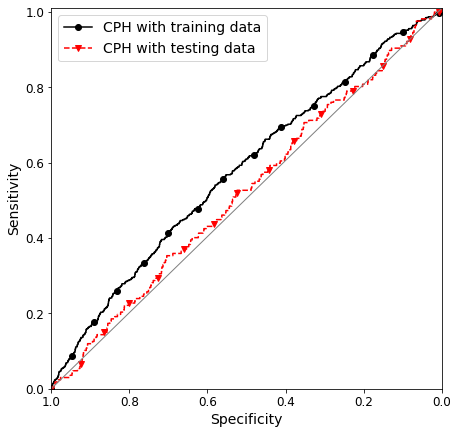

In [104]:
#plot roc curve
cph_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

In [105]:
# # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
# cph_lrti_no_abs_incdt_train_cumulative_hazard = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_train)
# cph_lrti_no_abs_incdt_train_cumulative_hazard = cph_lrti_no_abs_incdt_train_cumulative_hazard.loc[[30]].T
# cph_lrti_no_abs_incdt_train_cumulative_hazard['event_lrti_admitted'] = data_lrti_no_abs_incdt_train['event_lrti_admitted']
# cph_lrti_no_abs_incdt_train_cumulative_hazard = cph_lrti_no_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# # cph_lrti_no_abs_incdt_train_cumulative_hazard

# # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
# cph_lrti_no_abs_incdt_test_cumulative_hazard = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_test)
# cph_lrti_no_abs_incdt_test_cumulative_hazard = cph_lrti_no_abs_incdt_test_cumulative_hazard.loc[[30]].T
# cph_lrti_no_abs_incdt_test_cumulative_hazard['event_lrti_admitted'] = data_lrti_no_abs_incdt_test['event_lrti_admitted']
# cph_lrti_no_abs_incdt_test_cumulative_hazard = cph_lrti_no_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# # cph_lrti_no_abs_incdt_test_cumulative_hazard

# # plot roc curves
# r_fpr1, r_tpr1, _ = roc_curve(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
# r_fpr2, r_tpr2, _ = roc_curve(cph_lrti_no_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# fig, ax1 = pyplot.subplots(figsize=(7, 7))
# line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
# line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

# squares = [0,1.01]
# plt.plot(squares,linewidth=1, color='grey')
# plt.ylim(0,1.01)
# plt.xlim(0,1)
# plt.xlabel('Specificity', fontsize=14)
# plt.ylabel('Sensitivity', fontsize=14)

# #reversing xticks
# xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
# x = np.arange(len(xticks))
# ax1.set(xticklabels=xticks)
# ax1.legend(fontsize=14)
# # plt.title('ROC curve of CPH for hospital admission related to incident \nlrti with no antibiotics', fontsize=16)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_lrti/roc_cph_lrti_no_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [106]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

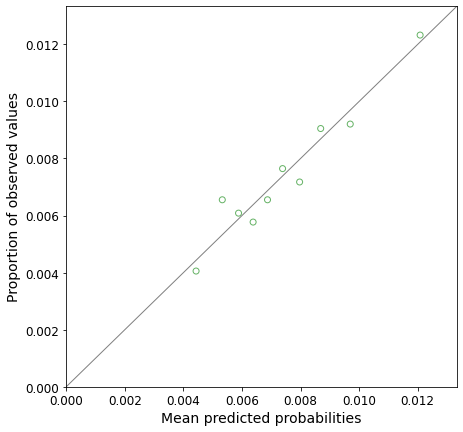

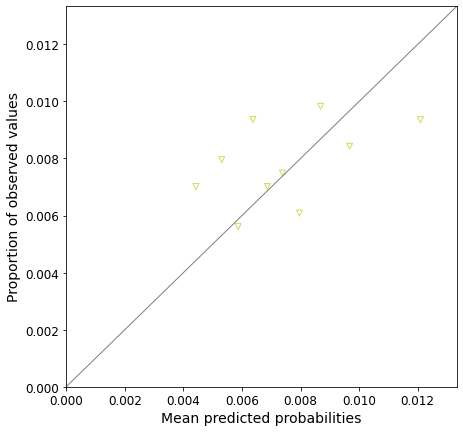

In [107]:
# plot calibration plots with development and validation data
cph_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')

In [108]:
# #predict cumulative hazard in day 30
# prob_pred_true_train = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_train).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
# prob_pred_true_train.columns = ['pred']
# prob_pred_true_train

In [109]:
# #group cumulative hazard into 10 bins with equal frequency of observations in each bin
# prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
# prob_pred_true_train

In [110]:
# #merge cumulative hazards with their actual events (0, 1)
# prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_no_abs_incdt_train.event_lrti_admitted, left_index=True, right_index=True)
# prob_pred_true_train

In [111]:
# #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
# prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
# prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
# prob_pred_true_train_groupby_bin

In [112]:
# #calculate proportion of events in each bin
# # prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_sum.sum()
# prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin

In [113]:
# #predict cumulative hazard in day 30
# prob_pred_true_test = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
# prob_pred_true_test.columns = ['pred']

# #group cumulative hazard into 10 bins with equal frequency of observations in each bin
# prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

# #merge cumulative hazards with their actual events (0, 1)
# prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_no_abs_incdt_test.event_lrti_admitted, left_index=True, right_index=True)

# #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
# prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
# prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

# #calculate proportion of events in each bin
# prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [114]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [115]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [116]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [117]:
# calculate c-statistics
cph_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt',  data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [118]:
# # calculate concordance index, AUROC, and Brier score of cph model
# concord_index_lrti_no_abs_incdt_train = concordance_index(data_lrti_no_abs_incdt_train['duration_lrti_admitted'], -cph_lrti_no_abs_incdt.predict_partial_hazard(data_lrti_no_abs_incdt_train), data_lrti_no_abs_incdt_train['event_lrti_admitted'])
# concord_index_lrti_no_abs_incdt_test = concordance_index(data_lrti_no_abs_incdt_test['duration_lrti_admitted'], -cph_lrti_no_abs_incdt.predict_partial_hazard(data_lrti_no_abs_incdt_test), data_lrti_no_abs_incdt_test['event_lrti_admitted'])
# r_auc1 = roc_auc_score(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
# r_auc2 = roc_auc_score(cph_lrti_no_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)
# brier1 = brier_score_loss(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
# brier2 = brier_score_loss(cph_lrti_no_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# # save model outputs
# a = open("../output/hospitalisation_prediction_lrti/cph_lrti_no_abs_incdt_output.txt", "w")
# a.write("")
# a.writelines(['Concordance index for lrti_no_abs_incdt with testing data: %.4f' % (concord_index_lrti_no_abs_incdt_test), 
#               '\nConcordance index for lrti_no_abs_incdt with training data: %.4f' % (concord_index_lrti_no_abs_incdt_train),
#               '\nAUROC of CPH with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc1),
#               '\nAUROC of CPH with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc2),
#               '\nBrier score of CPH with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier1),
#               '\nBrier score of CPH with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier2)])

#### 5-2- hospital admission related to incidental lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 7121 total observations, 7063 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 7121
number of events observed = 58
   partial log-likelihood = -496.35
         time fit was run = 2022-11-02 10:30:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.37            -0.74             0.73                 0.48                 2.07
CCI_cat[T.medium]                0.15       1.16       0.40            -0.65             0.94                 0.52                 2.56
CCI_cat[T.high]                 -0.28       0.76       0.54            -1.34             0.78                 0.26                 2.18
CCI_cat[T.very_high]            -0.32       0.73       0.49            -1.27             0.63                 0.28                 1.88
age_cat[T.25_34]                 0.64       1.89       0.47            -0.29             1.56                 0.75                 4.75
age_cat[T.35_44]                -0.30       0.74       0.56            -1.40             0.79                 0.25                 2.20
age_cat[T.45_54]                -0.32       0.72       0.59            -1.47             0.83                 0.23                 2.29
age_cat[T.55_64]                 0.19       1.21       0.51            -0.80             1.18                 0.45                 3.27
age_cat[T.65_74]                 0.39       1.48       0.48            -0.56             1.34                 0.57                 3.82
age_cat[T.75_more]               0.01       1.01       0.54            -1.04             1.06                 0.35                 2.89
antibacterial_brit               0.02       1.02       0.09            -0.17             0.20                 0.85                 1.22
bmi_cat[T.obese]                -0.44       0.65       0.46            -1.34             0.46                 0.26                 1.58
bmi_cat[T.overweight]           -1.04       0.35       0.71            -2.43             0.35                 0.09                 1.42
bmi_cat[T.underweight]          -0.88       0.42       1.08            -3.00             1.24                 0.05                 3.47
bmi_cat[T.unknown]               0.29       1.34       0.46            -0.61             1.19                 0.55                 3.30
ethnicity[T.unknown]             0.02       1.02       0.48            -0.91             0.96                 0.40                 2.61
ethnicity[T.white]               0.35       1.41       0.41            -0.46             1.15                 0.63                 3.16
flu_vaccine[T.yes]              -0.46       0.63       0.52            -1.48             0.56                 0.23                 1.75
imd[T.medium]                   -0.25       0.78       0.42            -1.08             0.58                 0.34                 1.78
imd[T.unaffluent]                0.30       1.36       0.38            -0.43             1.04                 0.65                 2.83
imd[T.unknown]                  -0.53       0.59       0.76            -2.02             0.96                 0.13                 2.62
imd[T.very_affluent]            -0.62       0.54       0.47            -1.54             0.30                 0.21                 1.35
imd[T.very_unaffluent]          -0.26       0.77       0.42            -1.08             0.57                 0.34                 1.77
region[T.east_midlands]          0.55       1.74       0.73            -0.88             1.98                 0.41                 7.28
region[T.london]                 0.99       2.69       0.64            -0

12761


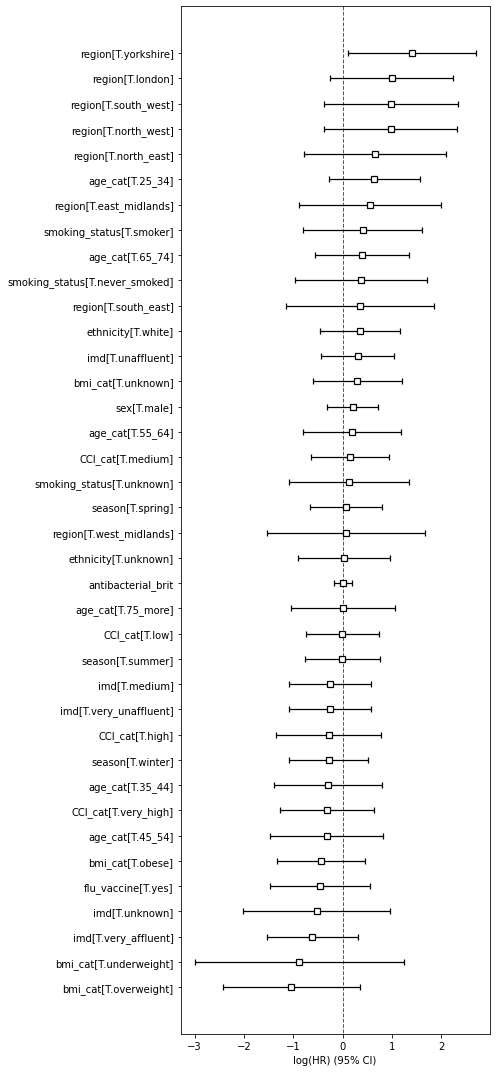

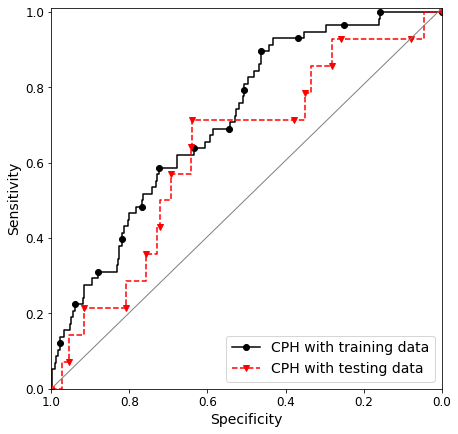

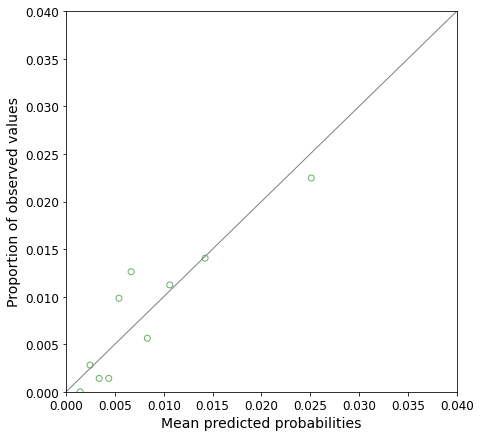

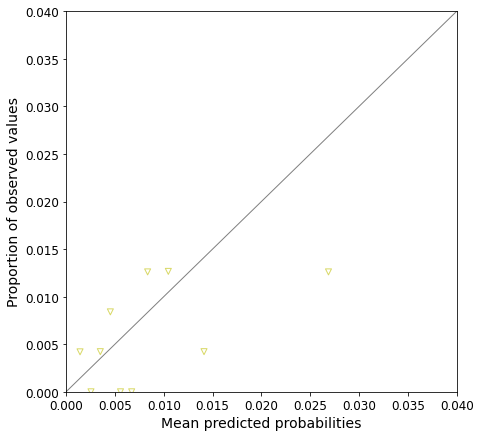

In [119]:
#data prep
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data 
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)
make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

#build cox model
cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')

#plot roc curve
cph_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

# plot calibration plots with development and validation data
cph_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')

# calculate c-statistics
cph_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

#### 5-3- hospital admission related to prevalent lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 7216 total observations, 7163 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 7216
number of events observed = 53
   partial log-likelihood = -445.07
         time fit was run = 2022-11-02 10:30:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.68       1.98       0.50            -0.30             1.67                 0.74                 5.29
CCI_cat[T.medium]                0.92       2.51       0.52            -0.11             1.95                 0.90                 7.00
CCI_cat[T.high]                  0.32       1.38       0.67            -1.00             1.64                 0.37                 5.15
CCI_cat[T.very_high]             0.72       2.06       0.55            -0.35             1.80                 0.70                 6.06
age_cat[T.25_34]                 0.03       1.03       0.54            -1.02             1.08                 0.36                 2.94
age_cat[T.35_44]                 0.37       1.45       0.49            -0.60             1.34                 0.55                 3.82
age_cat[T.45_54]                -0.37       0.69       0.59            -1.52             0.78                 0.22                 2.18
age_cat[T.55_64]                 0.23       1.26       0.50            -0.74             1.20                 0.48                 3.32
age_cat[T.65_74]                 0.33       1.39       0.51            -0.66             1.32                 0.52                 3.74
age_cat[T.75_more]              -0.33       0.72       0.59            -1.48             0.83                 0.23                 2.28
antibacterial_brit               0.21       1.24       0.09             0.03             0.39                 1.03                 1.48
bmi_cat[T.obese]                -0.52       0.59       0.40            -1.31             0.27                 0.27                 1.31
bmi_cat[T.overweight]           -0.54       0.58       0.54            -1.61             0.52                 0.20                 1.68
bmi_cat[T.underweight]         -16.37       0.00    2096.73         -4125.88          4093.15                 0.00                  inf
bmi_cat[T.unknown]              -0.83       0.44       0.47            -1.74             0.09                 0.17                 1.09
ethnicity[T.unknown]            -0.34       0.71       0.43            -1.18             0.50                 0.31                 1.66
ethnicity[T.white]              -0.26       0.77       0.37            -0.98             0.46                 0.38                 1.58
flu_vaccine[T.yes]              -0.26       0.77       0.52            -1.28             0.77                 0.28                 2.15
imd[T.medium]                   -0.52       0.60       0.45            -1.40             0.37                 0.25                 1.44
imd[T.unaffluent]                0.17       1.19       0.38            -0.56             0.91                 0.57                 2.49
imd[T.unknown]                  -0.62       0.54       0.76            -2.11             0.88                 0.12                 2.40
imd[T.very_affluent]            -1.23       0.29       0.57            -2.36            -0.11                 0.09                 0.89
imd[T.very_unaffluent]          -0.29       0.75       0.42            -1.12             0.54                 0.33                 1.72
region[T.east_midlands]          0.29       1.34       0.53            -0.75             1.33                 0.47                 3.78
region[T.london]                 0.10       1.10       0.49            -0

12781


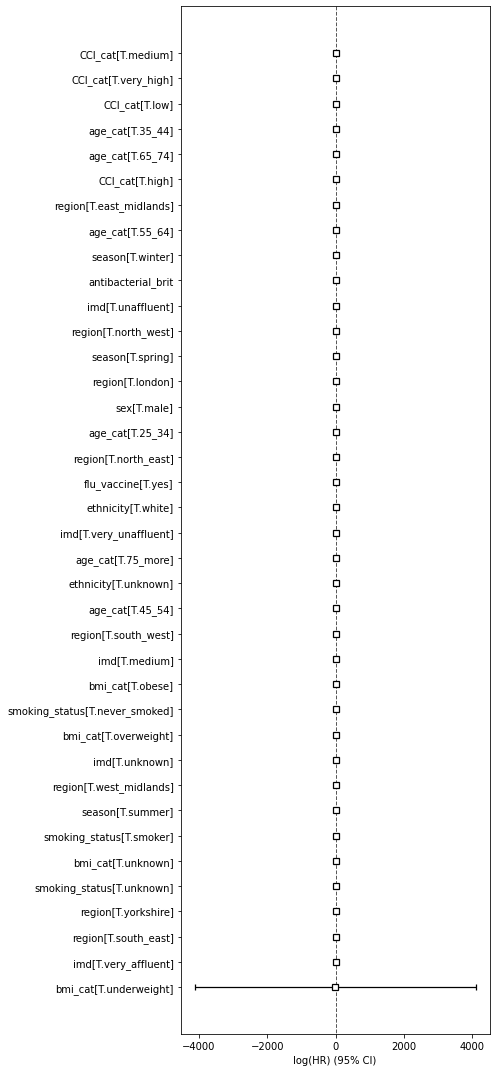

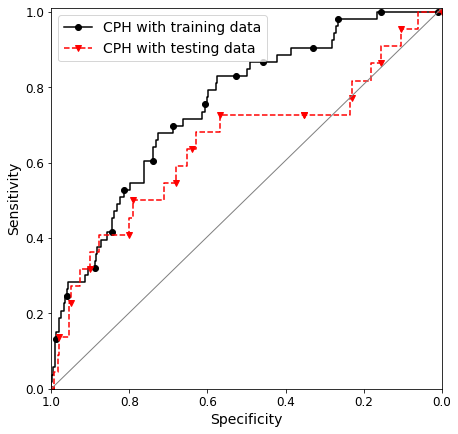

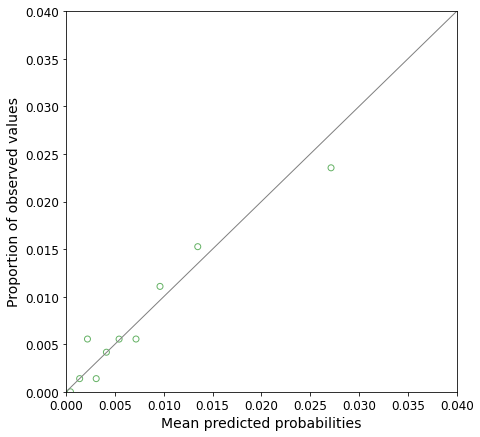

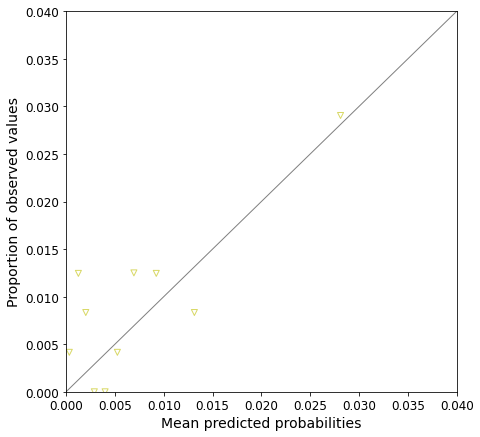

In [120]:
#data prep
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_enc)
make_summary_table_hosped('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

#build cox model
cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = cox_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_lrti_no_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_prevl.csv', data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl, 'sum_betas_cph_lrti_no_abs_prevl.csv')

#plot roc curve
cph_roc_curve(cph_lrti_no_abs_prevl, 'event_lrti_admitted', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_prevl.jpg')

# plot calibration plots with development and validation data
cph_calibration(cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, 'event_lrti_admitted', data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_prevl_train.jpg', 'calibration_cph_lrti_no_abs_prevl_test.jpg')

# calculate c-statistics
cph_output(cph_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

#### 5-4- hospital admission related to prevalent lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 789 total observations, 781 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 789
number of events observed = 8
   partial log-likelihood = -27.13
         time fit was run = 2022-11-02 10:30:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -3.50       0.03       2.00            -7.42             0.42                 0.00                 1.52
CCI_cat[T.medium]               -2.01       0.13       1.80            -5.53             1.51                 0.00                 4.54
CCI_cat[T.high]                 -2.21       0.11       2.74            -7.58             3.15                 0.00                23.41
CCI_cat[T.very_high]            -2.36       0.09       1.89            -6.05             1.34                 0.00                 3.81
age_cat[T.25_34]                -1.23       0.29       2.13            -5.41             2.94                 0.00                18.84
age_cat[T.35_44]                -0.37       0.69       1.53            -3.36             2.62                 0.03                13.69
age_cat[T.45_54]                -0.34       0.71       2.37            -4.98             4.29                 0.01                73.28
age_cat[T.55_64]               -22.70       0.00   10583.23        -20765.46         20720.06                 0.00                  inf
age_cat[T.65_74]                -0.16       0.85       2.18            -4.44             4.11                 0.01                61.13
age_cat[T.75_more]             -20.50       0.00   11902.59        -23349.14         23308.15                 0.00                  inf
antibacterial_brit              -0.65       0.52       0.57            -1.77             0.47                 0.17                 1.60
bmi_cat[T.obese]                19.46   2.81e+08   16421.16        -32165.43         32204.35                 0.00                  inf
bmi_cat[T.overweight]           -0.69       0.50   20570.88        -40318.87         40317.49                 0.00                  inf
bmi_cat[T.underweight]          19.08   1.93e+08   16421.16        -32165.81         32203.97                 0.00                  inf
bmi_cat[T.unknown]               0.45       1.57   18837.52        -36920.40         36921.31                 0.00                  inf
ethnicity[T.unknown]            16.17   1.06e+07   10627.80        -20813.93         20846.27                 0.00                  inf
ethnicity[T.white]              18.37   9.50e+07   10627.80        -20811.73         20848.47                 0.00                  inf
flu_vaccine[T.yes]               3.56      35.16       2.02            -0.40             7.52                 0.67              1848.04
imd[T.medium]                   -1.07       0.34       2.06            -5.12             2.97                 0.01                19.54
imd[T.unaffluent]              -19.95       0.00    7730.22        -15170.89         15131.00                 0.00                  inf
imd[T.unknown]                 -15.29       0.00   33471.41        -65618.04         65587.46                 0.00                  inf
imd[T.very_affluent]            -0.27       0.76       2.09            -4.37             3.82                 0.01                45.55
imd[T.very_unaffluent]           1.72       5.61       1.87            -1.94             5.39                 0.14               218.31
region[T.east_midlands]         21.25   1.69e+09   13921.12        -27263.64         27306.13                 0.00                  inf
region[T.london]                23.26   1.26e+10   13921.12        -27261.63  

13066


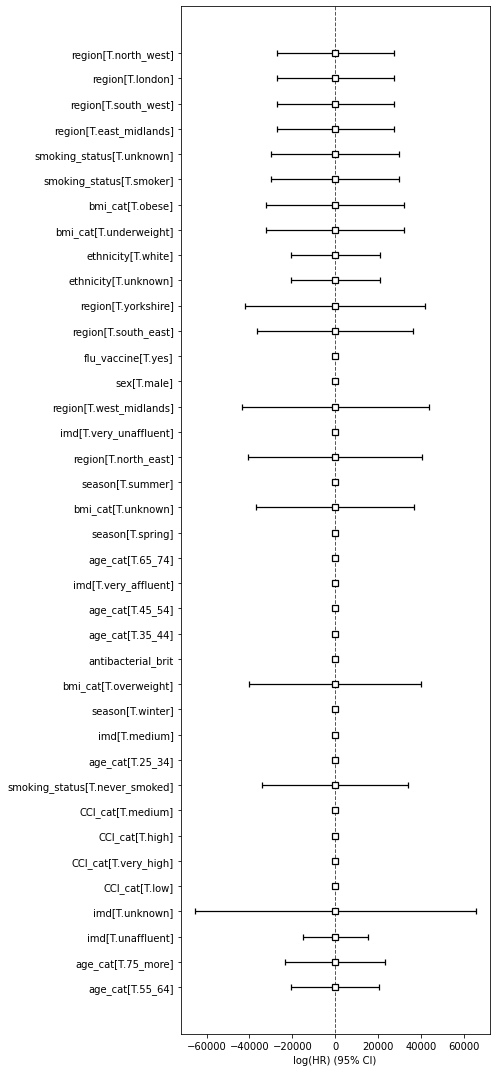

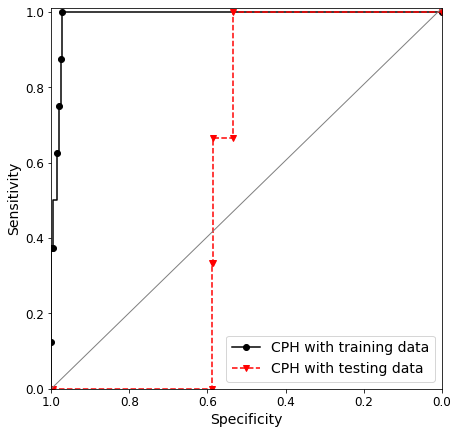

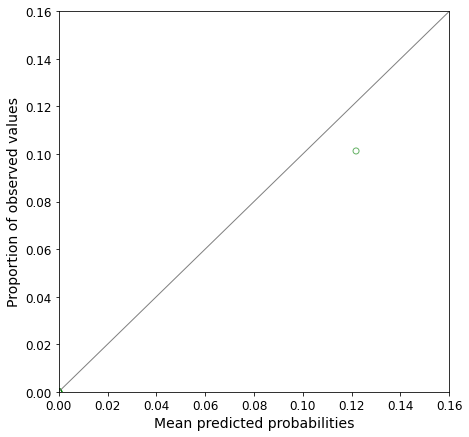

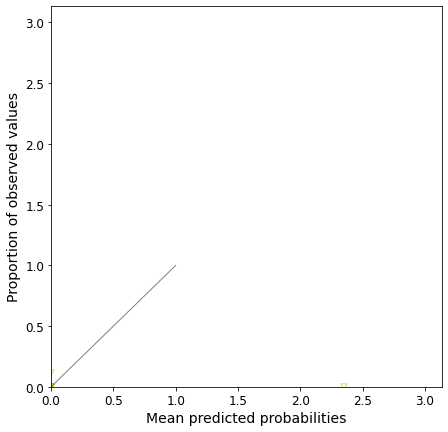

In [121]:
#data prep
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl_enc)
make_summary_table_hosped('lrti', 'abs_prevl', data_lrti_abs_prevl)

cph_lrti_abs_prevl, data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = cox_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_lrti_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_prevl.csv', data_lrti_abs_prevl_enc, data_lrti_abs_prevl, 'sum_betas_cph_lrti_abs_prevl.csv')

#plot roc curve
cph_roc_curve(cph_lrti_abs_prevl, 'event_lrti_admitted', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_prevl.jpg')

# plot calibration plots with development and validation data
cph_calibration(cph_lrti_abs_prevl, data_lrti_abs_prevl_train, 'event_lrti_admitted', data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_prevl_train.jpg', 'calibration_cph_lrti_abs_prevl_test.jpg')

# calculate c-statistics
cph_output(cph_lrti_abs_prevl, 'lrti', 'abs_prevl', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

### 5-5- hospital admisison related to incidental lrti with antibiotics

In [122]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    # plot betas
    fig, ax = plt.subplots(figsize=(7, 15))
    cph.plot()
    # plt.suptitle('Coefficients of Cox model for hospital admission related to '+infection+'_'+infection_type+'', fontsize=16)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_cph_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return cph, data_train, data_test

<lifelines.CoxPHFitter: fitted with 71215 total observations, 70687 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 71215
number of events observed = 528
   partial log-likelihood = -5872.85
         time fit was run = 2022-11-02 10:30:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.91       0.12            -0.33             0.14                 0.72                 1.15
CCI_cat[T.medium]               -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
CCI_cat[T.high]                 -0.26       0.77       0.17            -0.60             0.08                 0.55                 1.08
CCI_cat[T.very_high]            -0.35       0.71       0.15            -0.64            -0.05                 0.53                 0.95
age_cat[T.25_34]                 0.30       1.35       0.17            -0.03             0.63                 0.97                 1.89
age_cat[T.35_44]                 0.09       1.10       0.18            -0.26             0.44                 0.77                 1.55
age_cat[T.45_54]                 0.24       1.27       0.17            -0.09             0.58                 0.91                 1.78
age_cat[T.55_64]                 0.29       1.33       0.17            -0.05             0.62                 0.96                 1.86
age_cat[T.65_74]                 0.38       1.46       0.17             0.05             0.71                 1.05                 2.03
age_cat[T.75_more]               0.21       1.23       0.17            -0.13             0.55                 0.88                 1.73
antibacterial_brit               0.09       1.09       0.03             0.03             0.15                 1.03                 1.16
bmi_cat[T.obese]                -0.06       0.94       0.17            -0.39             0.27                 0.68                 1.31
bmi_cat[T.overweight]           -0.01       0.99       0.20            -0.40             0.39                 0.67                 1.48
bmi_cat[T.underweight]           0.12       1.13       0.28            -0.42             0.66                 0.66                 1.94
bmi_cat[T.unknown]               0.16       1.18       0.17            -0.18             0.50                 0.84                 1.66
ethnicity[T.unknown]            -0.04       0.96       0.14            -0.32             0.24                 0.72                 1.27
ethnicity[T.white]               0.02       1.02       0.13            -0.22             0.27                 0.80                 1.31
flu_vaccine[T.yes]              -0.18       0.83       0.15            -0.48             0.12                 0.62                 1.13
imd[T.medium]                   -0.22       0.80       0.14            -0.50             0.07                 0.61                 1.07
imd[T.unaffluent]                0.11       1.11       0.13            -0.15             0.37                 0.86                 1.44
imd[T.unknown]                  -0.09       0.92       0.22            -0.51             0.34                 0.60                 1.40
imd[T.very_affluent]            -0.15       0.86       0.14            -0.43             0.12                 0.65                 1.13
imd[T.very_unaffluent]          -0.24       0.79       0.14            -0.52             0.05                 0.60                 1.05
lrti_ab_date                     0.11       1.11       0.14            -0.17             0.38                 0.85                 1.46
region[T.east_midlands]          0.00       1.00       0.20         

13041


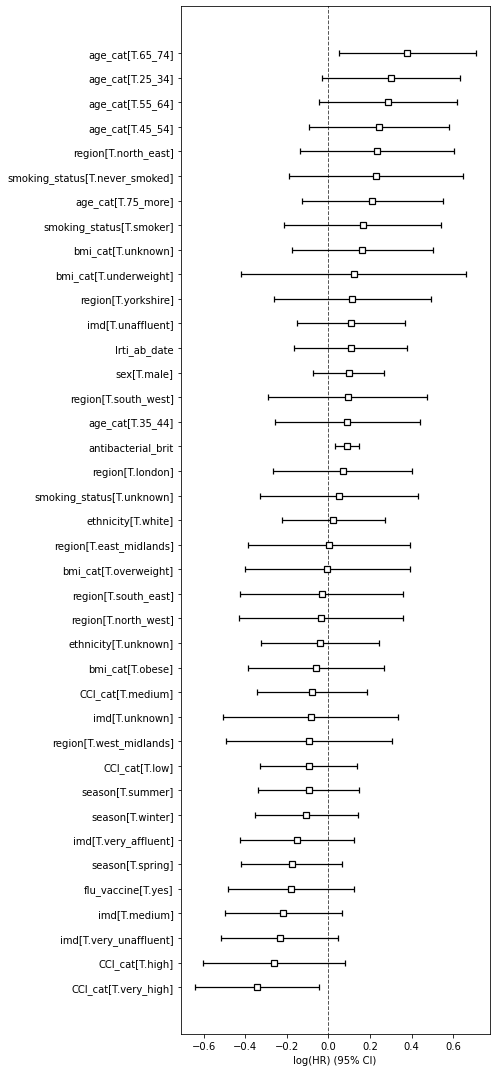

In [123]:
#data prep
data, data_lrti_incdt_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'incdt', data_lrti_incdt_enc)
make_summary_table_hosped('lrti', 'incdt', data_lrti_incdt)

cph_lrti_incdt, data_lrti_incdt_train, data_lrti_incdt_test = cox_model_abs_build('lrti', 'incdt', data_lrti_incdt)

# #calculate and save betas and sum of betas 
# betas_sumbetas_calculate(cph_lrti_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_incdt.csv', data_lrti_incdt_enc, data_lrti_incdt, 'sum_betas_cph_lrti_incdt.csv')

# #plot roc curve
# cph_roc_curve(cph_lrti_incdt, 'event_lrti_admitted', data_lrti_incdt_train, data_lrti_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_incdt.jpg')

# # plot calibration plots with development and validation data
# cph_calibration(cph_lrti_incdt, data_lrti_incdt_train, 'event_lrti_admitted', data_lrti_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_incdt_train.jpg', 'calibration_cph_lrti_incdt_test.jpg')

# calculate c-statistics
cph_output(cph_lrti_incdt, 'lrti', 'incdt', data_lrti_incdt_train, data_lrti_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

### 5-6- hospital admission related to prevalent lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 8005 total observations, 7944 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8005
number of events observed = 61
   partial log-likelihood = -526.54
         time fit was run = 2022-11-02 10:30:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.42            -0.49             1.14                 0.61                 3.14
CCI_cat[T.medium]                0.59       1.81       0.43            -0.26             1.44                 0.77                 4.24
CCI_cat[T.high]                 -0.14       0.87       0.61            -1.34             1.07                 0.26                 2.90
CCI_cat[T.very_high]             0.49       1.64       0.46            -0.40             1.39                 0.67                 4.02
age_cat[T.25_34]                 0.54       1.72       0.52            -0.47             1.56                 0.62                 4.75
age_cat[T.35_44]                 0.60       1.82       0.51            -0.40             1.59                 0.67                 4.93
age_cat[T.45_54]                 0.39       1.48       0.53            -0.64             1.42                 0.53                 4.16
age_cat[T.55_64]                 0.26       1.29       0.54            -0.80             1.32                 0.45                 3.73
age_cat[T.65_74]                 0.60       1.83       0.51            -0.39             1.60                 0.67                 4.95
age_cat[T.75_more]               0.05       1.05       0.58            -1.09             1.18                 0.34                 3.26
antibacterial_brit               0.19       1.21       0.09             0.02             0.36                 1.02                 1.43
bmi_cat[T.obese]                -0.60       0.55       0.39            -1.35             0.16                 0.26                 1.17
bmi_cat[T.overweight]           -0.60       0.55       0.53            -1.64             0.44                 0.19                 1.55
bmi_cat[T.underweight]          -1.30       0.27       1.06            -3.37             0.77                 0.03                 2.17
bmi_cat[T.unknown]              -0.45       0.64       0.41            -1.26             0.36                 0.28                 1.43
ethnicity[T.unknown]            -0.29       0.75       0.44            -1.16             0.58                 0.31                 1.78
ethnicity[T.white]               0.07       1.07       0.37            -0.66             0.79                 0.52                 2.21
flu_vaccine[T.yes]              -0.14       0.87       0.47            -1.06             0.77                 0.35                 2.17
imd[T.medium]                   -0.42       0.66       0.43            -1.27             0.43                 0.28                 1.54
imd[T.unaffluent]                0.21       1.24       0.37            -0.51             0.94                 0.60                 2.56
imd[T.unknown]                  -1.15       0.32       1.04            -3.18             0.89                 0.04                 2.44
imd[T.very_affluent]            -0.68       0.50       0.47            -1.61             0.24                 0.20                 1.27
imd[T.very_unaffluent]           0.04       1.04       0.39            -0.72             0.79                 0.49                 2.21
lrti_ab_date                     0.25       1.28       0.38            -0.50             1.00                 0.61                 2.71
region[T.east_midlands]          0.40       1.49       0.52            -0

13030


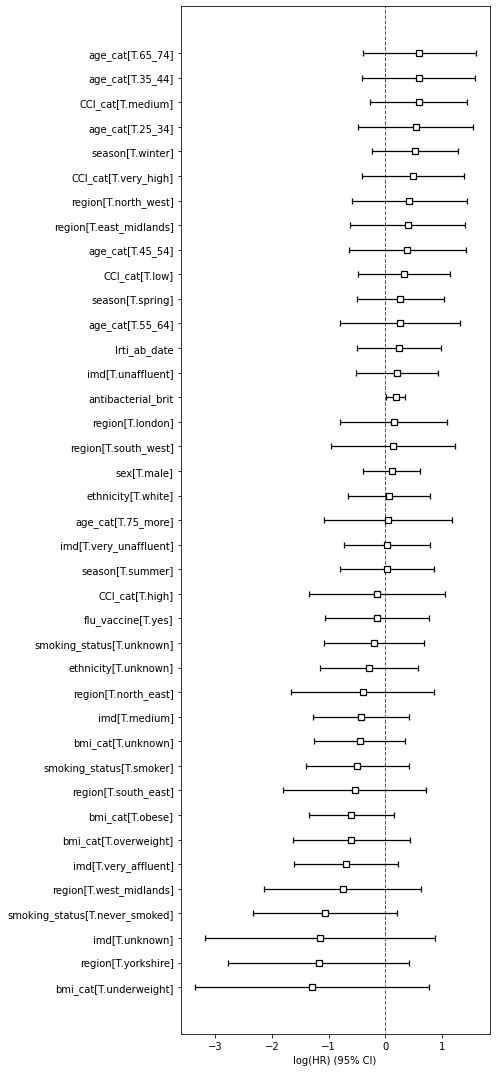

In [124]:
#data prep
data, data_lrti_prevl_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'prevl', data_lrti_prevl_enc)
make_summary_table_hosped('lrti', 'prevl', data_lrti_prevl)

cph_lrti_prevl, data_lrti_prevl_train, data_lrti_prevl_test = cox_model_abs_build('lrti', 'prevl', data_lrti_prevl)

# #calculate and save betas and sum of betas 
# betas_sumbetas_calculate(cph_lrti_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_prevl.csv', data_lrti_prevl_enc, data_lrti_prevl, 'sum_betas_cph_lrti_prevl.csv')

# #plot roc curve
# cph_roc_curve(cph_lrti_prevl, 'event_lrti_admitted', data_lrti_prevl_train, data_lrti_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_prevl.jpg')

# # plot calibration plots with development and validation data
# cph_calibration(cph_lrti_prevl, data_lrti_prevl_train, 'event_lrti_admitted', data_lrti_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_prevl_train.jpg', 'calibration_cph_lrti_prevl_test.jpg')

# calculate c-statistics
cph_output(cph_lrti_prevl, 'lrti', 'prevl', data_lrti_prevl_train, data_lrti_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

### 5-7- hospital admission related to incident lrti with antibiotics categories

In [125]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    # plot betas
    fig, ax = plt.subplots(figsize=(7, 15))
    cph.plot()
    # plt.suptitle('Coefficients of Cox model for hospital admission related to '+infection+'_'+infection_type+'', fontsize=16)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_cph_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return cph, data_train, data_test

<lifelines.CoxPHFitter: fitted with 71215 total observations, 70687 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 71215
number of events observed = 528
   partial log-likelihood = -5871.56
         time fit was run = 2022-11-02 10:30:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.91       0.12            -0.33             0.14                 0.72                 1.15
CCI_cat[T.medium]               -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
CCI_cat[T.high]                 -0.26       0.77       0.17            -0.60             0.08                 0.55                 1.08
CCI_cat[T.very_high]            -0.35       0.71       0.15            -0.64            -0.05                 0.53                 0.95
ab_type_cat[T.Doxycycline]     -12.78       0.00     576.23         -1142.16          1116.60                 0.00                  inf
ab_type_cat[T.no]                0.03       1.03       0.58            -1.10             1.17                 0.33                 3.22
ab_type_cat[T.other]             0.17       1.19       0.59            -0.99             1.33                 0.37                 3.80
age_cat[T.25_34]                 0.30       1.35       0.17            -0.03             0.64                 0.97                 1.89
age_cat[T.35_44]                 0.09       1.10       0.18            -0.26             0.44                 0.77                 1.55
age_cat[T.45_54]                 0.24       1.27       0.17            -0.09             0.58                 0.91                 1.78
age_cat[T.55_64]                 0.29       1.33       0.17            -0.04             0.62                 0.96                 1.86
age_cat[T.65_74]                 0.38       1.46       0.17             0.05             0.71                 1.05                 2.03
age_cat[T.75_more]               0.21       1.24       0.17            -0.13             0.55                 0.88                 1.73
antibacterial_brit               0.09       1.09       0.03             0.03             0.15                 1.03                 1.16
bmi_cat[T.obese]                -0.06       0.94       0.17            -0.38             0.27                 0.68                 1.31
bmi_cat[T.overweight]           -0.00       1.00       0.20            -0.40             0.39                 0.67                 1.48
bmi_cat[T.underweight]           0.12       1.13       0.28            -0.42             0.66                 0.66                 1.94
bmi_cat[T.unknown]               0.16       1.18       0.17            -0.18             0.51                 0.84                 1.66
ethnicity[T.unknown]            -0.04       0.96       0.14            -0.32             0.24                 0.72                 1.27
ethnicity[T.white]               0.02       1.02       0.13            -0.23             0.27                 0.80                 1.31
flu_vaccine[T.yes]              -0.18       0.83       0.15            -0.48             0.12                 0.62                 1.13
imd[T.medium]                   -0.22       0.80       0.14            -0.50             0.06                 0.61                 1.07
imd[T.unaffluent]                0.11       1.11       0.13            -0.15             0.36                 0.86                 1.44
imd[T.unknown]                  -0.09       0.92       0.22            -0.51             0.33                 0.60                 1.40
imd[T.very_affluent]            -0.15       0.86       0.14         

13614


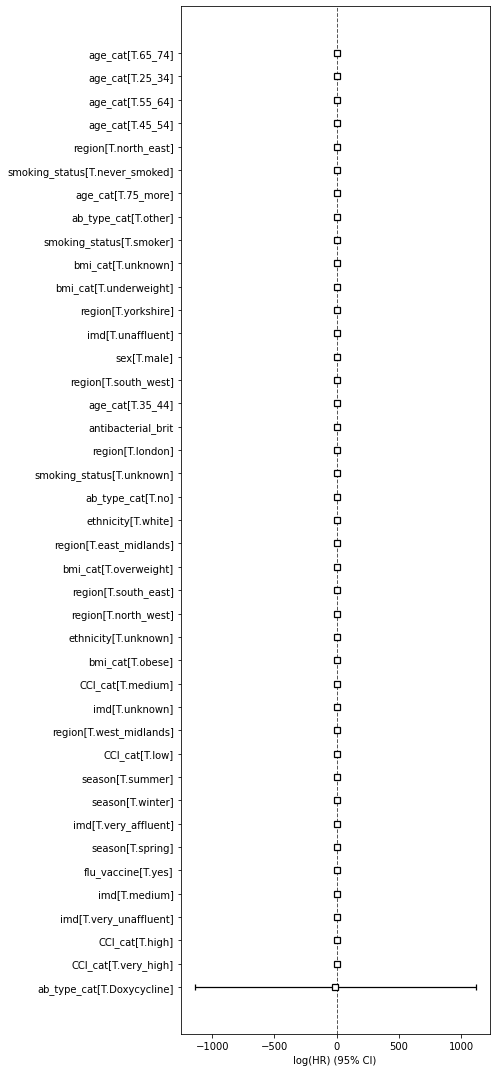

In [126]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_abs', data_lrti_incdt_abs_enc)
# make_summary_table_hosped('lrti', 'incdt_abs', data_lrti_incdt)

#cox model
cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)

# calculate c-statistics
cph_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

### 5-8- hospital admission related to prevalent lrti with antibiotics categories

<lifelines.CoxPHFitter: fitted with 8005 total observations, 7944 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8005
number of events observed = 61
   partial log-likelihood = -526.35
         time fit was run = 2022-11-02 10:30:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.42            -0.49             1.14                 0.61                 3.14
CCI_cat[T.medium]                0.59       1.81       0.43            -0.26             1.45                 0.77                 4.24
CCI_cat[T.high]                 -0.14       0.87       0.61            -1.34             1.07                 0.26                 2.91
CCI_cat[T.very_high]             0.49       1.63       0.46            -0.41             1.39                 0.67                 4.01
ab_type_cat[T.Doxycycline]     -14.23       0.00    2801.17         -5504.43          5475.97                 0.00                  inf
ab_type_cat[T.no]               -0.59       0.55       1.01            -2.58             1.39                 0.08                 4.03
ab_type_cat[T.other]            -0.36       0.69       1.07            -2.47             1.74                 0.08                 5.71
age_cat[T.25_34]                 0.55       1.73       0.52            -0.47             1.56                 0.63                 4.78
age_cat[T.35_44]                 0.60       1.82       0.51            -0.40             1.59                 0.67                 4.93
age_cat[T.45_54]                 0.39       1.47       0.53            -0.65             1.42                 0.52                 4.15
age_cat[T.55_64]                 0.26       1.29       0.54            -0.80             1.32                 0.45                 3.74
age_cat[T.65_74]                 0.60       1.82       0.51            -0.40             1.60                 0.67                 4.94
age_cat[T.75_more]               0.04       1.04       0.58            -1.09             1.18                 0.34                 3.25
antibacterial_brit               0.19       1.21       0.09             0.02             0.36                 1.02                 1.43
bmi_cat[T.obese]                -0.59       0.55       0.39            -1.35             0.16                 0.26                 1.18
bmi_cat[T.overweight]           -0.60       0.55       0.53            -1.64             0.44                 0.19                 1.55
bmi_cat[T.underweight]          -1.30       0.27       1.06            -3.37             0.77                 0.03                 2.17
bmi_cat[T.unknown]              -0.45       0.64       0.41            -1.27             0.36                 0.28                 1.43
ethnicity[T.unknown]            -0.30       0.74       0.44            -1.16             0.57                 0.31                 1.77
ethnicity[T.white]               0.06       1.06       0.37            -0.66             0.79                 0.51                 2.20
flu_vaccine[T.yes]              -0.15       0.86       0.47            -1.06             0.77                 0.35                 2.17
imd[T.medium]                   -0.42       0.65       0.43            -1.28             0.43                 0.28                 1.53
imd[T.unaffluent]                0.21       1.23       0.37            -0.52             0.94                 0.60                 2.55
imd[T.unknown]                  -1.15       0.32       1.04            -3.18             0.89                 0.04                 2.44
imd[T.very_affluent]            -0.69       0.50       0.47            -1

13608


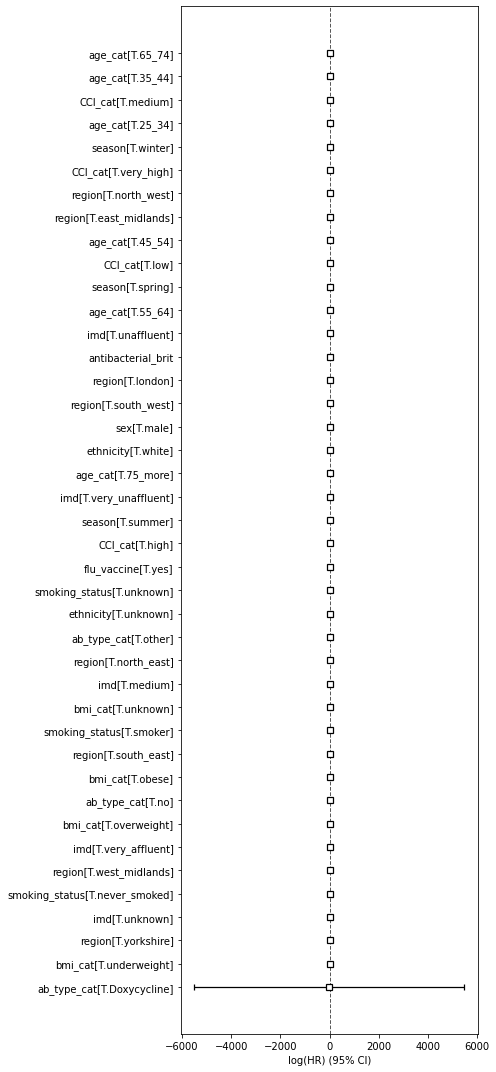

In [127]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_abs', data_lrti_prevl_abs_enc)
# make_summary_table_hosped('lrti', 'prevl_abs', data_lrti_prevl)

#cox model
cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)

# calculate c-statistics
cph_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

### 5-9- hospital admission related to lrti stratified by sex
#### 5-9-1- incident males

In [128]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    # plot betas
    fig, ax = plt.subplots(figsize=(7, 15))
    cph.plot()
    # plt.suptitle('Coefficients of Cox model for hospital admission related to '+infection+'_'+infection_type+'', fontsize=16)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_cph_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return cph, data_train, data_test

<lifelines.CoxPHFitter: fitted with 35003 total observations, 34727 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 35003
number of events observed = 276
   partial log-likelihood = -2866.27
         time fit was run = 2022-11-02 10:30:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.16            -0.57             0.07                 0.56                 1.07
CCI_cat[T.medium]               -0.09       0.91       0.18            -0.44             0.26                 0.64                 1.30
CCI_cat[T.high]                 -0.27       0.76       0.23            -0.73             0.18                 0.48                 1.20
CCI_cat[T.very_high]            -0.48       0.62       0.21            -0.89            -0.06                 0.41                 0.94
age_cat[T.25_34]                 0.57       1.77       0.26             0.07             1.08                 1.07                 2.95
age_cat[T.35_44]                 0.33       1.39       0.27            -0.20             0.87                 0.82                 2.38
age_cat[T.45_54]                 0.64       1.90       0.26             0.14             1.15                 1.15                 3.15
age_cat[T.55_64]                 0.50       1.66       0.26            -0.01             1.02                 0.99                 2.77
age_cat[T.65_74]                 0.67       1.95       0.26             0.16             1.17                 1.18                 3.22
age_cat[T.75_more]               0.83       2.29       0.25             0.33             1.32                 1.40                 3.74
antibacterial_brit               0.05       1.05       0.04            -0.03             0.13                 0.97                 1.14
bmi_cat[T.obese]                -0.13       0.87       0.23            -0.58             0.31                 0.56                 1.36
bmi_cat[T.overweight]           -0.02       0.98       0.28            -0.56             0.53                 0.57                 1.69
bmi_cat[T.underweight]           0.10       1.10       0.38            -0.65             0.84                 0.52                 2.31
bmi_cat[T.unknown]               0.15       1.17       0.24            -0.31             0.62                 0.74                 1.85
ethnicity[T.unknown]            -0.10       0.90       0.19            -0.48             0.28                 0.62                 1.32
ethnicity[T.white]              -0.09       0.91       0.17            -0.43             0.24                 0.65                 1.27
flu_vaccine[T.yes]              -0.05       0.95       0.20            -0.45             0.34                 0.64                 1.41
imd[T.medium]                    0.12       1.12       0.20            -0.28             0.51                 0.75                 1.67
imd[T.unaffluent]                0.26       1.29       0.20            -0.13             0.64                 0.88                 1.90
imd[T.unknown]                   0.15       1.17       0.30            -0.44             0.75                 0.64                 2.12
imd[T.very_affluent]             0.20       1.22       0.20            -0.19             0.58                 0.83                 1.79
imd[T.very_unaffluent]           0.07       1.07       0.20            -0.33             0.47                 0.72                 1.60
lrti_ab_date                     0.10       1.10       0.19            -0.28             0.48                 0.76                 1.61
region[T.east_midlands]         -0.11       0.90       0.28         

12766


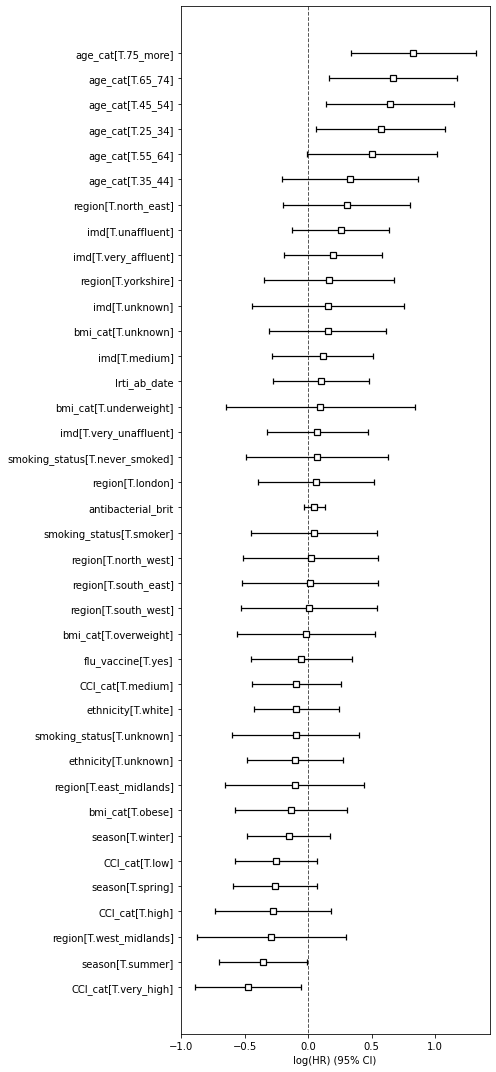

In [129]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_males', data_lrti_incdt_males_enc)
# make_summary_table_hosped('lrti', 'incdt_males', data_lrti_incdt_males)

#cox model
cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)

# calculate c-statistics
cph_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

#### 5-9-2- incident females

<lifelines.CoxPHFitter: fitted with 36212 total observations, 35949 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 36212
number of events observed = 263
   partial log-likelihood = -2744.46
         time fit was run = 2022-11-02 10:30:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.18            -0.38             0.31                 0.68                 1.37
CCI_cat[T.medium]                0.07       1.07       0.20            -0.31             0.45                 0.73                 1.57
CCI_cat[T.high]                 -0.16       0.85       0.25            -0.66             0.33                 0.52                 1.40
CCI_cat[T.very_high]             0.03       1.03       0.21            -0.38             0.43                 0.69                 1.54
age_cat[T.25_34]                -0.01       0.99       0.21            -0.42             0.40                 0.66                 1.49
age_cat[T.35_44]                -0.33       0.72       0.22            -0.77             0.10                 0.46                 1.11
age_cat[T.45_54]                -0.13       0.87       0.21            -0.55             0.28                 0.57                 1.33
age_cat[T.55_64]                -0.37       0.69       0.23            -0.82             0.07                 0.44                 1.08
age_cat[T.65_74]                -0.26       0.77       0.22            -0.70             0.18                 0.50                 1.20
age_cat[T.75_more]              -0.55       0.58       0.24            -1.02            -0.07                 0.36                 0.93
antibacterial_brit               0.08       1.08       0.04            -0.01             0.16                 0.99                 1.17
bmi_cat[T.obese]                -0.10       0.90       0.23            -0.54             0.34                 0.58                 1.40
bmi_cat[T.overweight]           -0.22       0.80       0.28            -0.78             0.33                 0.46                 1.40
bmi_cat[T.underweight]          -0.06       0.94       0.39            -0.83             0.71                 0.43                 2.03
bmi_cat[T.unknown]              -0.16       0.85       0.24            -0.64             0.32                 0.53                 1.37
ethnicity[T.unknown]            -0.00       1.00       0.20            -0.40             0.39                 0.67                 1.47
ethnicity[T.white]              -0.06       0.94       0.18            -0.41             0.29                 0.67                 1.33
flu_vaccine[T.yes]              -0.06       0.94       0.21            -0.48             0.35                 0.62                 1.42
imd[T.medium]                   -0.23       0.79       0.20            -0.63             0.16                 0.53                 1.17
imd[T.unaffluent]                0.04       1.04       0.19            -0.33             0.40                 0.72                 1.49
imd[T.unknown]                  -0.27       0.76       0.32            -0.90             0.35                 0.41                 1.42
imd[T.very_affluent]            -0.25       0.78       0.20            -0.64             0.14                 0.53                 1.15
imd[T.very_unaffluent]          -0.29       0.75       0.20            -0.69             0.10                 0.50                 1.11
lrti_ab_date                     0.18       1.20       0.19            -0.19             0.56                 0.82                 1.74
region[T.east_midlands]          0.28       1.32       0.28         

12784


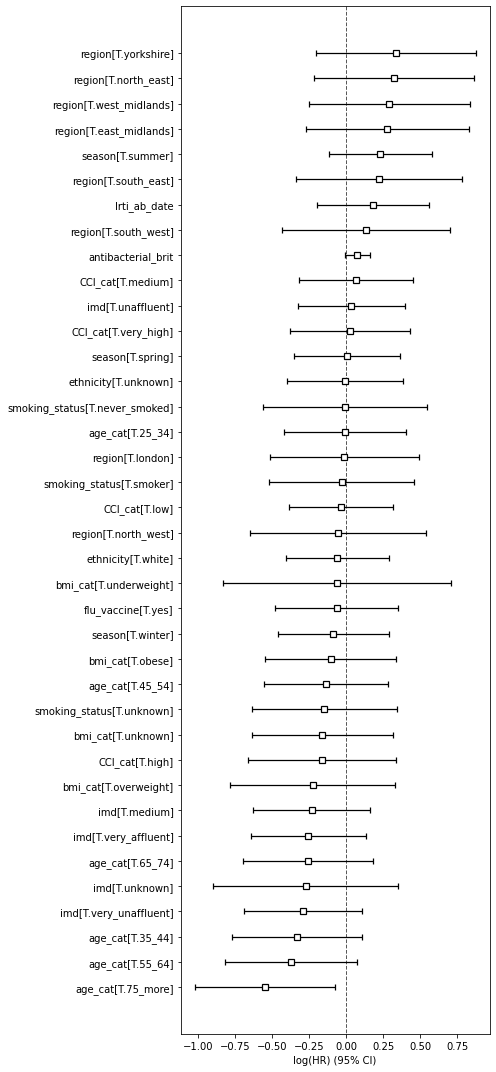

In [130]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_females', data_lrti_incdt_females_enc)
# make_summary_table_hosped('lrti', 'incdt_females', data_lrti_incdt_females)

#cox model
cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)

# calculate c-statistics
cph_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

#### 5-9-3- prevalent males

<lifelines.CoxPHFitter: fitted with 3941 total observations, 3903 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3941
number of events observed = 38
   partial log-likelihood = -289.68
         time fit was run = 2022-11-02 10:31:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.17       3.22       0.77            -0.33             2.67                 0.72                14.46
CCI_cat[T.medium]                1.63       5.09       0.77             0.13             3.13                 1.13                22.84
CCI_cat[T.high]                  0.98       2.65       0.92            -0.82             2.77                 0.44                15.96
CCI_cat[T.very_high]             1.67       5.29       0.78             0.13             3.20                 1.14                24.62
age_cat[T.25_34]                 0.49       1.63       0.65            -0.79             1.76                 0.45                 5.84
age_cat[T.35_44]                 0.67       1.96       0.63            -0.57             1.91                 0.57                 6.78
age_cat[T.45_54]                -0.06       0.94       0.71            -1.46             1.33                 0.23                 3.78
age_cat[T.55_64]                 0.60       1.82       0.63            -0.64             1.84                 0.53                 6.31
age_cat[T.65_74]                 0.70       2.01       0.62            -0.52             1.91                 0.59                 6.78
age_cat[T.75_more]              -0.59       0.56       0.87            -2.30             1.12                 0.10                 3.07
antibacterial_brit               0.10       1.10       0.11            -0.12             0.32                 0.89                 1.37
bmi_cat[T.obese]                -0.80       0.45       0.43            -1.65             0.04                 0.19                 1.04
bmi_cat[T.overweight]           -0.83       0.44       0.62            -2.04             0.39                 0.13                 1.48
bmi_cat[T.underweight]          -0.93       0.39       1.07            -3.03             1.17                 0.05                 3.21
bmi_cat[T.unknown]              -1.16       0.31       0.52            -2.18            -0.14                 0.11                 0.87
ethnicity[T.unknown]            -0.64       0.53       0.54            -1.70             0.41                 0.18                 1.51
ethnicity[T.white]              -0.25       0.78       0.43            -1.10             0.60                 0.33                 1.82
flu_vaccine[T.yes]              -0.10       0.90       0.61            -1.30             1.09                 0.27                 2.97
imd[T.medium]                   -0.36       0.70       0.59            -1.51             0.80                 0.22                 2.23
imd[T.unaffluent]                0.14       1.15       0.52            -0.88             1.17                 0.41                 3.23
imd[T.unknown]                 -16.81       0.00    3407.66         -6695.71          6662.09                 0.00                  inf
imd[T.very_affluent]            -0.13       0.88       0.56            -1.23             0.97                 0.29                 2.63
imd[T.very_unaffluent]           0.47       1.60       0.48            -0.47             1.41                 0.62                 4.10
lrti_ab_date                     0.37       1.45       0.45            -0.51             1.25                 0.60                 3.50
region[T.east_midlands]          0.77       2.17       0.60            -0

12783


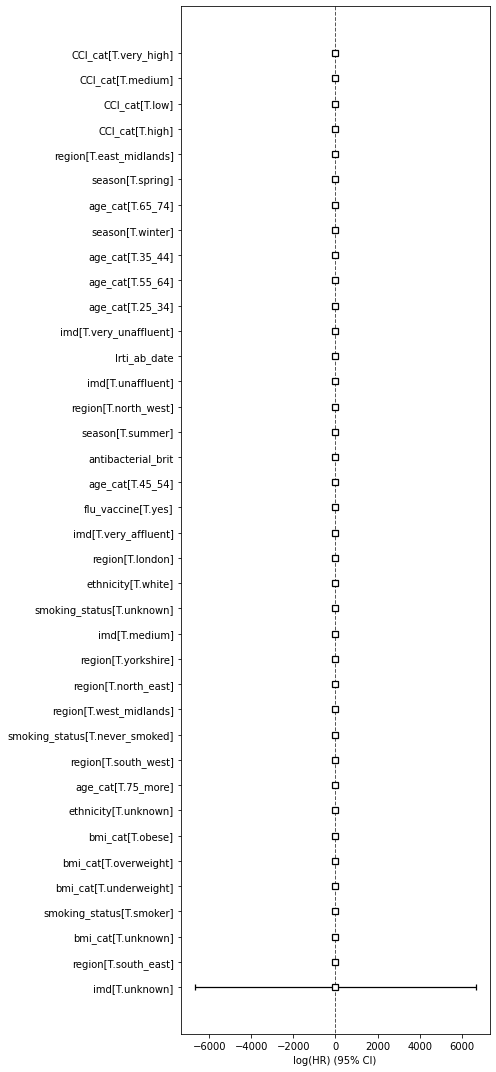

In [131]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_males', data_lrti_prevl_males_enc)
# make_summary_table_hosped('lrti', 'prevl_males', data_lrti_prevl_males)

#cox model
cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)

# calculate c-statistics
cph_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

#### 5-9-4- prevalent females

<lifelines.CoxPHFitter: fitted with 4064 total observations, 4031 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 4064
number of events observed = 33
   partial log-likelihood = -255.15
         time fit was run = 2022-11-02 10:31:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.53       1.70       0.58            -0.59             1.66                 0.55                 5.26
CCI_cat[T.medium]                0.03       1.03       0.67            -1.29             1.35                 0.27                 3.85
CCI_cat[T.high]                  0.91       2.48       0.68            -0.42             2.23                 0.66                 9.34
CCI_cat[T.very_high]             0.44       1.55       0.65            -0.83             1.71                 0.43                 5.55
age_cat[T.25_34]                 0.14       1.15       0.58            -1.00             1.29                 0.37                 3.62
age_cat[T.35_44]                -0.15       0.86       0.61            -1.35             1.05                 0.26                 2.85
age_cat[T.45_54]                -0.22       0.80       0.61            -1.42             0.98                 0.24                 2.67
age_cat[T.55_64]                -1.17       0.31       0.82            -2.78             0.44                 0.06                 1.55
age_cat[T.65_74]                 0.00       1.00       0.58            -1.14             1.15                 0.32                 3.15
age_cat[T.75_more]              -0.77       0.46       0.71            -2.17             0.62                 0.11                 1.87
antibacterial_brit               0.04       1.05       0.12            -0.19             0.28                 0.82                 1.33
bmi_cat[T.obese]                -0.42       0.65       0.51            -1.43             0.58                 0.24                 1.79
bmi_cat[T.overweight]           -1.07       0.34       0.84            -2.72             0.58                 0.07                 1.79
bmi_cat[T.underweight]         -16.39       0.00    2543.43         -5001.41          4968.64                 0.00                  inf
bmi_cat[T.unknown]              -0.60       0.55       0.58            -1.73             0.53                 0.18                 1.69
ethnicity[T.unknown]             0.12       1.13       0.57            -0.99             1.23                 0.37                 3.43
ethnicity[T.white]              -0.01       0.99       0.51            -1.00             0.99                 0.37                 2.70
flu_vaccine[T.yes]               0.58       1.79       0.50            -0.39             1.56                 0.68                 4.74
imd[T.medium]                   -0.98       0.37       0.68            -2.32             0.36                 0.10                 1.43
imd[T.unaffluent]                0.14       1.15       0.48            -0.80             1.08                 0.45                 2.94
imd[T.unknown]                  -0.00       1.00       0.80            -1.56             1.56                 0.21                 4.75
imd[T.very_affluent]            -0.97       0.38       0.68            -2.31             0.37                 0.10                 1.44
imd[T.very_unaffluent]          -0.17       0.85       0.52            -1.19             0.86                 0.30                 2.36
lrti_ab_date                     0.27       1.31       0.54            -0.80             1.33                 0.45                 3.79
region[T.east_midlands]         -0.08       0.92       0.82            -1

12784


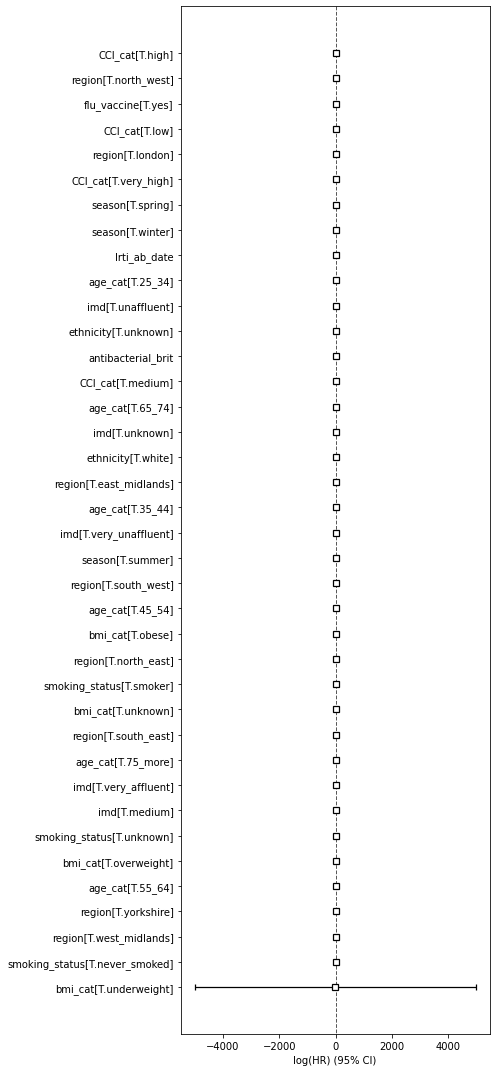

In [132]:
#data prep
data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_females', data_lrti_prevl_females_enc)
# make_summary_table_hosped('lrti', 'prevl_females', data_lrti_prevl_females)

#cox model
cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)

# calculate c-statistics
cph_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

### 5-10- hospital admission related to lrti stratified by age category
#### 5-10-1- incident

In [133]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    # plot betas
    fig, ax = plt.subplots(figsize=(7, 15))
    cph.plot()
    # plt.suptitle('Coefficients of Cox model for hospital admission related to '+infection+'_'+infection_type+'', fontsize=16)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_cph_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return cph, data_train, data_test

<lifelines.CoxPHFitter: fitted with 10255 total observations, 10185 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10255
number of events observed = 70
   partial log-likelihood = -621.42
         time fit was run = 2022-11-02 10:31:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.77       2.17       0.39            -0.00             1.55                 1.00                 4.69
CCI_cat[T.medium]                0.26       1.29       0.48            -0.67             1.19                 0.51                 3.28
CCI_cat[T.high]                  0.72       2.05       0.49            -0.23             1.67                 0.79                 5.34
CCI_cat[T.very_high]             0.29       1.34       0.49            -0.66             1.25                 0.52                 3.48
antibacterial_brit               0.17       1.18       0.08             0.01             0.33                 1.01                 1.38
bmi_cat[T.obese]                 0.27       1.31       0.53            -0.76             1.31                 0.47                 3.70
bmi_cat[T.overweight]            0.40       1.50       0.60            -0.78             1.58                 0.46                 4.88
bmi_cat[T.underweight]           0.27       1.31       0.87            -1.43             1.97                 0.24                 7.20
bmi_cat[T.unknown]               0.24       1.27       0.56            -0.85             1.33                 0.43                 3.80
ethnicity[T.unknown]            -0.18       0.84       0.38            -0.93             0.58                 0.40                 1.78
ethnicity[T.white]              -0.17       0.85       0.33            -0.81             0.48                 0.45                 1.61
flu_vaccine[T.yes]               0.27       1.31       0.36            -0.43             0.97                 0.65                 2.64
imd[T.medium]                    0.19       1.21       0.38            -0.55             0.93                 0.57                 2.54
imd[T.unaffluent]                0.50       1.64       0.36            -0.20             1.20                 0.82                 3.31
imd[T.unknown]                 -16.75       0.00    2415.16         -4750.38          4716.89                 0.00                  inf
imd[T.very_affluent]             0.05       1.05       0.39            -0.70             0.81                 0.49                 2.24
imd[T.very_unaffluent]          -0.47       0.62       0.45            -1.36             0.41                 0.26                 1.51
lrti_ab_date                    -0.13       0.88       0.43            -0.97             0.71                 0.38                 2.03
region[T.east_midlands]          0.39       1.48       0.73            -1.04             1.82                 0.35                 6.18
region[T.london]                 0.77       2.16       0.63            -0.47             2.01                 0.62                 7.47
region[T.north_east]             0.56       1.74       0.71            -0.83             1.94                 0.44                 6.98
region[T.north_west]             0.74       2.10       0.69            -0.61             2.09                 0.54                 8.13
region[T.south_east]             1.20       3.31       0.65            -0.07             2.46                 0.93                11.75
region[T.south_west]             1.20       3.31       0.65            -0.08             2.47                 0.92                11.88
region[T.west_midlands]          0.61       1.84       0.71           

11391


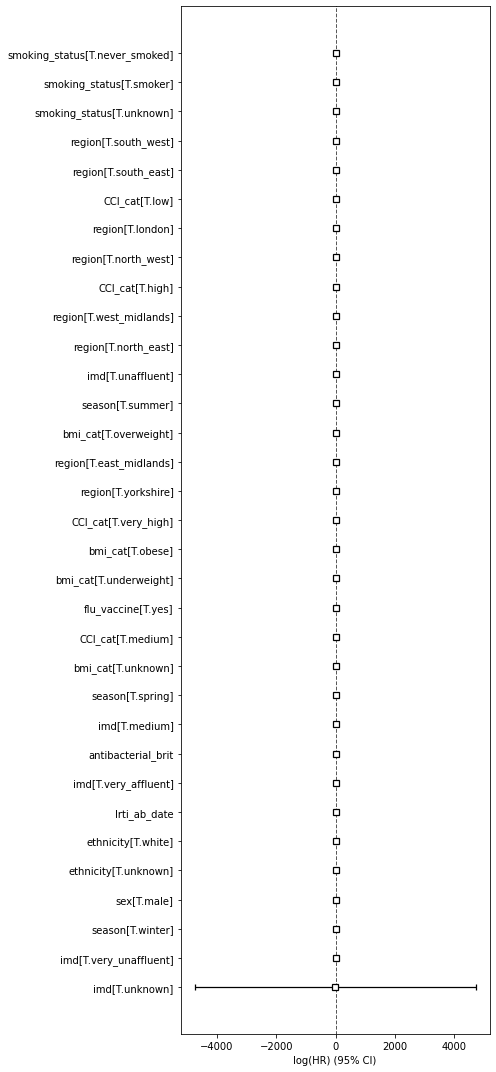

In [134]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_15_24', data_lrti_incdt_15_24_enc)
# make_summary_table_hosped('lrti', 'incdt_15_24', data_lrti_incdt_15_24)

#cox model
cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)

# calculate c-statistics
cph_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 10094 total observations, 10004 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10094
number of events observed = 90
   partial log-likelihood = -816.36
         time fit was run = 2022-11-02 10:31:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.39       0.68       0.31            -1.00             0.22                 0.37                 1.25
CCI_cat[T.medium]                0.18       1.19       0.31            -0.43             0.78                 0.65                 2.19
CCI_cat[T.high]                 -0.05       0.95       0.41            -0.85             0.75                 0.43                 2.12
CCI_cat[T.very_high]            -0.11       0.90       0.36            -0.81             0.59                 0.45                 1.81
antibacterial_brit              -0.02       0.98       0.08            -0.16             0.13                 0.85                 1.14
bmi_cat[T.obese]                 0.25       1.29       0.47            -0.67             1.18                 0.51                 3.26
bmi_cat[T.overweight]            0.66       1.93       0.52            -0.35             1.67                 0.70                 5.33
bmi_cat[T.underweight]           0.41       1.50       0.73            -1.03             1.84                 0.36                 6.31
bmi_cat[T.unknown]               0.40       1.49       0.49            -0.57             1.36                 0.57                 3.91
ethnicity[T.unknown]             0.29       1.33       0.40            -0.50             1.08                 0.61                 2.93
ethnicity[T.white]               0.55       1.73       0.36            -0.16             1.25                 0.86                 3.48
flu_vaccine[T.yes]               0.01       1.01       0.35            -0.68             0.70                 0.51                 2.01
imd[T.medium]                    0.10       1.11       0.32            -0.52             0.73                 0.59                 2.08
imd[T.unaffluent]               -0.01       0.99       0.33            -0.66             0.63                 0.52                 1.88
imd[T.unknown]                  -0.54       0.58       0.62            -1.76             0.68                 0.17                 1.97
imd[T.very_affluent]            -0.09       0.92       0.33            -0.73             0.56                 0.48                 1.75
imd[T.very_unaffluent]          -0.50       0.60       0.37            -1.23             0.22                 0.29                 1.24
lrti_ab_date                     0.26       1.30       0.32            -0.37             0.90                 0.69                 2.45
region[T.east_midlands]          0.30       1.36       0.47            -0.61             1.22                 0.54                 3.38
region[T.london]                 0.28       1.32       0.41            -0.53             1.09                 0.59                 2.97
region[T.north_east]             0.50       1.66       0.45            -0.38             1.39                 0.69                 4.00
region[T.north_west]            -0.33       0.72       0.54            -1.39             0.73                 0.25                 2.07
region[T.south_east]            -0.31       0.73       0.54            -1.37             0.75                 0.25                 2.11
region[T.south_west]             0.24       1.27       0.48            -0.70             1.17                 0.50                 3.21
region[T.west_midlands]          0.04       1.04       0.50           

11394


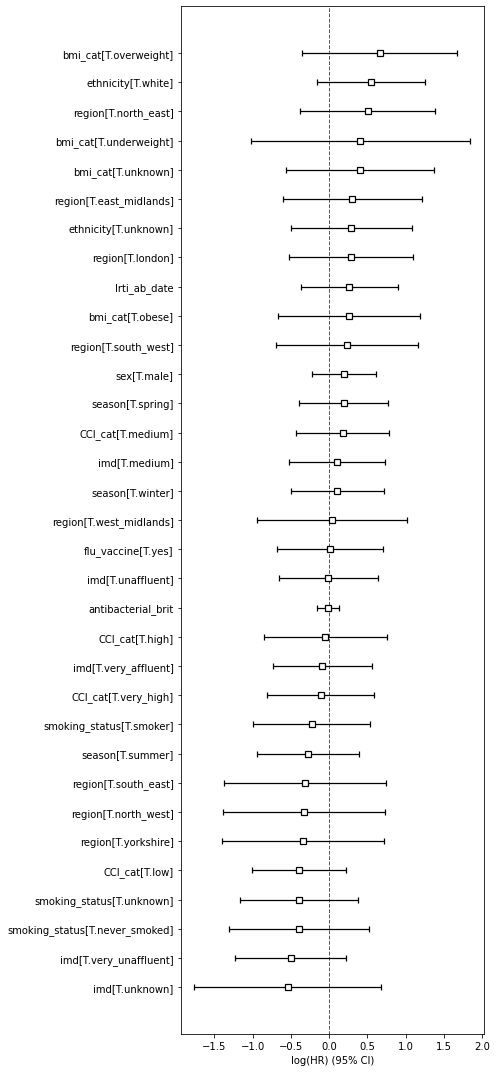

In [135]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_25_34', data_lrti_incdt_25_34_enc)
# make_summary_table_hosped('lrti', 'incdt_25_34', data_lrti_incdt_25_34)

#cox model
cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)

# calculate c-statistics
cph_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 10336 total observations, 10265 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10336
number of events observed = 71
   partial log-likelihood = -638.43
         time fit was run = 2022-11-02 10:31:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.31            -0.86             0.34                 0.42                 1.41
CCI_cat[T.medium]               -0.34       0.71       0.36            -1.04             0.36                 0.35                 1.44
CCI_cat[T.high]                 -0.95       0.39       0.55            -2.04             0.13                 0.13                 1.14
CCI_cat[T.very_high]            -0.60       0.55       0.41            -1.40             0.20                 0.25                 1.22
antibacterial_brit               0.03       1.03       0.08            -0.14             0.19                 0.87                 1.21
bmi_cat[T.obese]                -0.36       0.70       0.39            -1.13             0.41                 0.32                 1.50
bmi_cat[T.overweight]           -0.22       0.80       0.49            -1.18             0.73                 0.31                 2.08
bmi_cat[T.underweight]          -0.03       0.97       0.68            -1.36             1.31                 0.26                 3.70
bmi_cat[T.unknown]              -0.64       0.53       0.44            -1.51             0.23                 0.22                 1.26
ethnicity[T.unknown]             0.24       1.27       0.43            -0.60             1.08                 0.55                 2.96
ethnicity[T.white]               0.32       1.38       0.38            -0.43             1.08                 0.65                 2.93
flu_vaccine[T.yes]              -0.02       0.98       0.40            -0.81             0.76                 0.45                 2.13
imd[T.medium]                   -0.37       0.69       0.41            -1.17             0.43                 0.31                 1.54
imd[T.unaffluent]                0.47       1.59       0.34            -0.19             1.12                 0.83                 3.08
imd[T.unknown]                  -0.19       0.83       0.63            -1.43             1.05                 0.24                 2.86
imd[T.very_affluent]            -0.88       0.42       0.48            -1.83             0.07                 0.16                 1.07
imd[T.very_unaffluent]           0.05       1.06       0.37            -0.66             0.77                 0.52                 2.16
lrti_ab_date                    -0.08       0.93       0.40            -0.86             0.71                 0.42                 2.02
region[T.east_midlands]         -0.13       0.88       0.61            -1.32             1.06                 0.27                 2.89
region[T.london]                -0.17       0.85       0.52            -1.18             0.85                 0.31                 2.33
region[T.north_east]             0.27       1.31       0.54            -0.79             1.33                 0.46                 3.80
region[T.north_west]             0.22       1.25       0.56            -0.87             1.31                 0.42                 3.72
region[T.south_east]            -0.20       0.82       0.61            -1.38             0.99                 0.25                 2.70
region[T.south_west]             0.48       1.62       0.53            -0.55             1.52                 0.58                 4.56
region[T.west_midlands]          0.31       1.36       0.54           

11402


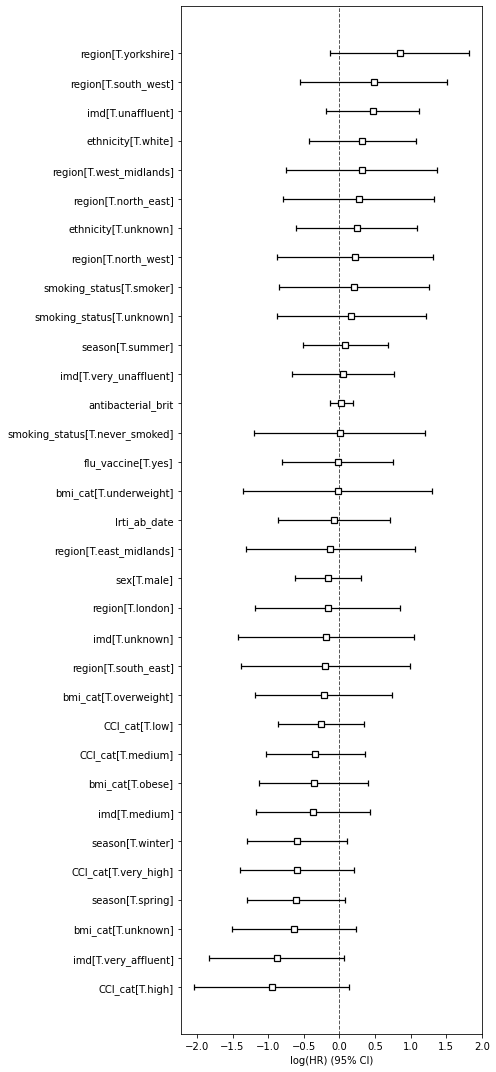

In [136]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_35_44', data_lrti_incdt_35_44_enc)
# make_summary_table_hosped('lrti', 'incdt_35_44', data_lrti_incdt_35_44)

#cox model
cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)

# calculate c-statistics
cph_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 10198 total observations, 10118 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10198
number of events observed = 80
   partial log-likelihood = -714.81
         time fit was run = 2022-11-02 10:31:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.31            -0.46             0.76                 0.63                 2.14
CCI_cat[T.medium]                0.09       1.10       0.35            -0.59             0.78                 0.55                 2.18
CCI_cat[T.high]                 -0.77       0.46       0.56            -1.87             0.34                 0.15                 1.40
CCI_cat[T.very_high]            -0.28       0.75       0.41            -1.09             0.52                 0.34                 1.68
antibacterial_brit               0.06       1.06       0.08            -0.10             0.21                 0.91                 1.23
bmi_cat[T.obese]                -0.55       0.58       0.40            -1.33             0.24                 0.26                 1.27
bmi_cat[T.overweight]           -0.35       0.71       0.50            -1.33             0.64                 0.26                 1.89
bmi_cat[T.underweight]           0.08       1.08       0.68            -1.25             1.41                 0.29                 4.10
bmi_cat[T.unknown]               0.23       1.25       0.40            -0.55             1.00                 0.58                 2.73
ethnicity[T.unknown]            -0.42       0.66       0.37            -1.14             0.30                 0.32                 1.34
ethnicity[T.white]              -0.13       0.88       0.30            -0.73             0.46                 0.48                 1.59
flu_vaccine[T.yes]               0.11       1.11       0.35            -0.59             0.80                 0.55                 2.23
imd[T.medium]                   -0.58       0.56       0.37            -1.31             0.15                 0.27                 1.17
imd[T.unaffluent]               -0.50       0.61       0.35            -1.19             0.20                 0.30                 1.22
imd[T.unknown]                   0.17       1.18       0.44            -0.69             1.03                 0.50                 2.79
imd[T.very_affluent]            -0.10       0.90       0.31            -0.71             0.51                 0.49                 1.67
imd[T.very_unaffluent]          -0.97       0.38       0.42            -1.78            -0.15                 0.17                 0.86
lrti_ab_date                    -0.16       0.85       0.40            -0.94             0.61                 0.39                 1.85
region[T.east_midlands]         -0.58       0.56       0.51            -1.58             0.42                 0.21                 1.52
region[T.london]                -0.36       0.70       0.40            -1.14             0.42                 0.32                 1.52
region[T.north_east]            -0.16       0.85       0.45            -1.04             0.73                 0.35                 2.07
region[T.north_west]            -2.30       0.10       1.04            -4.35            -0.25                 0.01                 0.78
region[T.south_east]             0.18       1.20       0.41            -0.62             0.99                 0.54                 2.69
region[T.south_west]            -0.39       0.68       0.47            -1.30             0.53                 0.27                 1.69
region[T.west_midlands]         -0.17       0.84       0.45           

11416


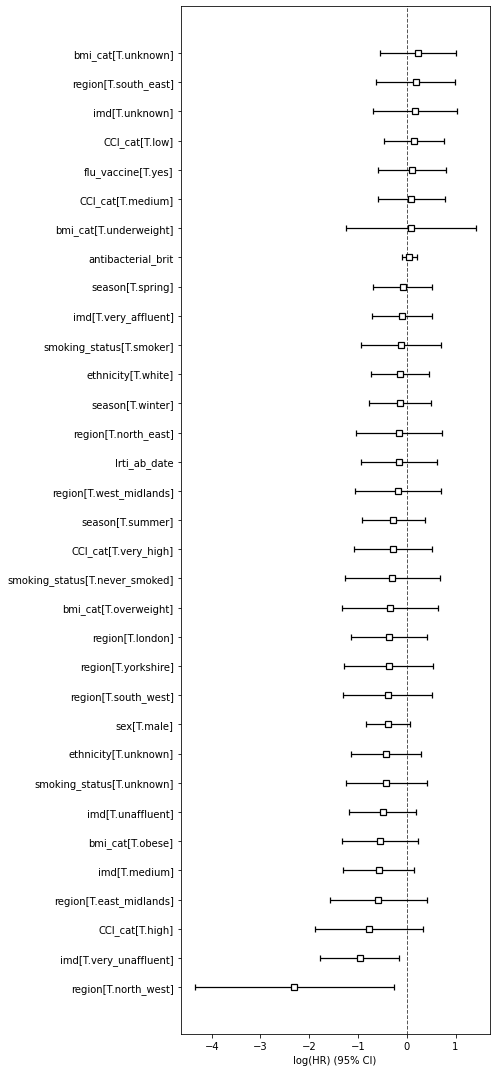

In [137]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_45_54', data_lrti_incdt_45_54_enc)
# make_summary_table_hosped('lrti', 'incdt_45_54', data_lrti_incdt_45_54)

#cox model
cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)

# calculate c-statistics
cph_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 10282 total observations, 10203 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10282
number of events observed = 79
   partial log-likelihood = -716.88
         time fit was run = 2022-11-02 10:31:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.30            -0.57             0.61                 0.56                 1.83
CCI_cat[T.medium]               -0.56       0.57       0.40            -1.34             0.22                 0.26                 1.25
CCI_cat[T.high]                 -0.02       0.98       0.41            -0.83             0.79                 0.44                 2.20
CCI_cat[T.very_high]            -0.32       0.73       0.39            -1.08             0.44                 0.34                 1.55
antibacterial_brit               0.05       1.05       0.08            -0.10             0.21                 0.90                 1.23
bmi_cat[T.obese]                -0.35       0.70       0.39            -1.12             0.42                 0.33                 1.52
bmi_cat[T.overweight]           -0.24       0.78       0.49            -1.20             0.71                 0.30                 2.04
bmi_cat[T.underweight]          -1.28       0.28       1.06            -3.36             0.80                 0.03                 2.24
bmi_cat[T.unknown]              -0.07       0.94       0.41            -0.87             0.74                 0.42                 2.09
ethnicity[T.unknown]             0.11       1.11       0.35            -0.59             0.80                 0.55                 2.23
ethnicity[T.white]              -0.20       0.82       0.33            -0.84             0.44                 0.43                 1.56
flu_vaccine[T.yes]              -0.80       0.45       0.51            -1.80             0.21                 0.16                 1.24
imd[T.medium]                   -0.11       0.89       0.36            -0.82             0.59                 0.44                 1.81
imd[T.unaffluent]               -0.30       0.74       0.37            -1.04             0.43                 0.35                 1.54
imd[T.unknown]                  -0.79       0.45       0.75            -2.26             0.68                 0.10                 1.98
imd[T.very_affluent]             0.17       1.18       0.34            -0.50             0.83                 0.61                 2.30
imd[T.very_unaffluent]          -0.18       0.83       0.37            -0.90             0.54                 0.41                 1.71
lrti_ab_date                    -0.14       0.87       0.40            -0.92             0.64                 0.40                 1.89
region[T.east_midlands]         -0.51       0.60       0.52            -1.52             0.51                 0.22                 1.66
region[T.london]                -0.11       0.90       0.40            -0.89             0.68                 0.41                 1.97
region[T.north_east]            -0.47       0.62       0.52            -1.49             0.54                 0.23                 1.72
region[T.north_west]            -0.71       0.49       0.55            -1.78             0.37                 0.17                 1.44
region[T.south_east]             0.10       1.11       0.45            -0.78             0.98                 0.46                 2.67
region[T.south_west]            -0.07       0.93       0.46            -0.97             0.83                 0.38                 2.30
region[T.west_midlands]         -0.24       0.79       0.48           

11416


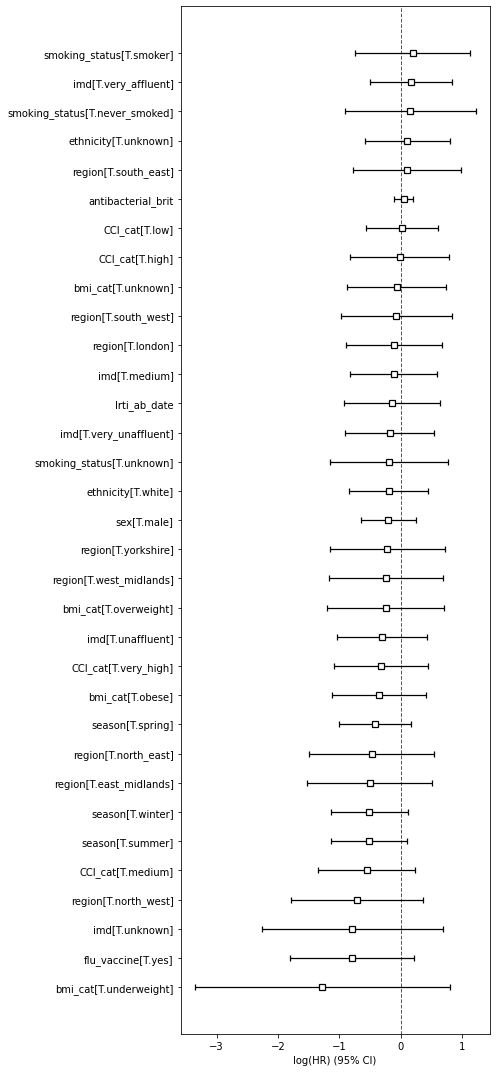

In [138]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_55_64', data_lrti_incdt_55_64_enc)
# make_summary_table_hosped('lrti', 'incdt_55_64', data_lrti_incdt_55_64)

#cox model
cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)

# calculate c-statistics
cph_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 10014 total observations, 9930 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10014
number of events observed = 84
   partial log-likelihood = -752.87
         time fit was run = 2022-11-02 10:31:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.31            -0.63             0.59                 0.53                 1.81
CCI_cat[T.medium]                0.10       1.10       0.34            -0.57             0.77                 0.57                 2.15
CCI_cat[T.high]                 -0.38       0.68       0.48            -1.32             0.56                 0.27                 1.75
CCI_cat[T.very_high]             0.04       1.04       0.37            -0.68             0.76                 0.51                 2.14
antibacterial_brit               0.21       1.23       0.07             0.06             0.35                 1.07                 1.42
bmi_cat[T.obese]                -0.46       0.63       0.34            -1.12             0.20                 0.33                 1.22
bmi_cat[T.overweight]           -1.30       0.27       0.58            -2.45            -0.16                 0.09                 0.85
bmi_cat[T.underweight]          -0.20       0.82       0.59            -1.35             0.94                 0.26                 2.57
bmi_cat[T.unknown]              -0.64       0.53       0.38            -1.39             0.10                 0.25                 1.11
ethnicity[T.unknown]            -0.25       0.78       0.35            -0.93             0.43                 0.40                 1.54
ethnicity[T.white]              -0.15       0.86       0.30            -0.72             0.43                 0.48                 1.54
flu_vaccine[T.yes]              -0.60       0.55       0.46            -1.50             0.31                 0.22                 1.36
imd[T.medium]                   -0.33       0.72       0.37            -1.06             0.39                 0.35                 1.48
imd[T.unaffluent]                0.21       1.23       0.32            -0.42             0.85                 0.65                 2.33
imd[T.unknown]                   0.27       1.31       0.48            -0.66             1.21                 0.52                 3.35
imd[T.very_affluent]            -0.39       0.67       0.38            -1.13             0.35                 0.32                 1.42
imd[T.very_unaffluent]          -0.22       0.80       0.36            -0.93             0.49                 0.40                 1.63
lrti_ab_date                     0.38       1.46       0.31            -0.23             0.99                 0.79                 2.70
region[T.east_midlands]          0.44       1.55       0.49            -0.53             1.40                 0.59                 4.07
region[T.london]                 0.44       1.55       0.44            -0.42             1.30                 0.65                 3.67
region[T.north_east]             0.62       1.86       0.48            -0.31             1.56                 0.73                 4.74
region[T.north_west]             0.09       1.09       0.54            -0.96             1.14                 0.38                 3.12
region[T.south_east]            -0.84       0.43       0.69            -2.19             0.52                 0.11                 1.68
region[T.south_west]             0.47       1.60       0.49            -0.50             1.44                 0.61                 4.22
region[T.west_midlands]         -0.04       0.96       0.56            

11404


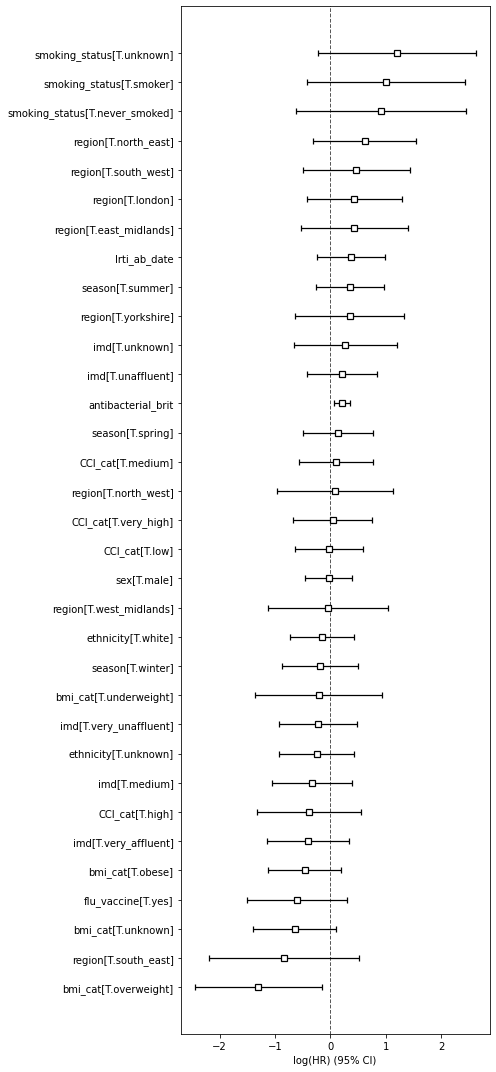

In [139]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_65_74', data_lrti_incdt_65_74_enc)
# make_summary_table_hosped('lrti', 'incdt_65_74', data_lrti_incdt_65_74)

#cox model
cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)

# calculate c-statistics
cph_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 10034 total observations, 9956 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10034
number of events observed = 78
   partial log-likelihood = -697.39
         time fit was run = 2022-11-02 10:31:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.58       0.56       0.32            -1.21             0.05                 0.30                 1.06
CCI_cat[T.medium]                0.02       1.02       0.32            -0.61             0.65                 0.54                 1.92
CCI_cat[T.high]                 -0.19       0.83       0.42            -1.02             0.64                 0.36                 1.89
CCI_cat[T.very_high]            -0.43       0.65       0.38            -1.17             0.31                 0.31                 1.37
antibacterial_brit               0.08       1.08       0.08            -0.07             0.23                 0.93                 1.26
bmi_cat[T.obese]                -0.07       0.93       0.44            -0.94             0.80                 0.39                 2.22
bmi_cat[T.overweight]            0.39       1.48       0.50            -0.58             1.36                 0.56                 3.91
bmi_cat[T.underweight]          -0.89       0.41       1.08            -3.00             1.23                 0.05                 3.44
bmi_cat[T.unknown]               0.11       1.12       0.46            -0.80             1.02                 0.45                 2.76
ethnicity[T.unknown]            -0.26       0.77       0.35            -0.95             0.43                 0.38                 1.54
ethnicity[T.white]              -0.26       0.77       0.31            -0.86             0.34                 0.42                 1.41
flu_vaccine[T.yes]               0.32       1.38       0.33            -0.32             0.96                 0.73                 2.62
imd[T.medium]                   -0.61       0.54       0.41            -1.42             0.19                 0.24                 1.21
imd[T.unaffluent]               -0.19       0.83       0.35            -0.87             0.49                 0.42                 1.63
imd[T.unknown]                   0.37       1.44       0.47            -0.56             1.29                 0.57                 3.65
imd[T.very_affluent]            -0.26       0.77       0.36            -0.96             0.44                 0.38                 1.55
imd[T.very_unaffluent]          -0.12       0.88       0.35            -0.81             0.57                 0.44                 1.76
lrti_ab_date                    -0.31       0.73       0.43            -1.14             0.53                 0.32                 1.69
region[T.east_midlands]          0.02       1.02       0.54            -1.03             1.07                 0.36                 2.92
region[T.london]                 0.11       1.12       0.45            -0.78             1.00                 0.46                 2.73
region[T.north_east]            -0.02       0.98       0.54            -1.07             1.03                 0.34                 2.80
region[T.north_west]             0.16       1.17       0.52            -0.86             1.17                 0.42                 3.23
region[T.south_east]             0.70       2.00       0.47            -0.23             1.62                 0.80                 5.05
region[T.south_west]            -0.10       0.91       0.54            -1.15             0.96                 0.32                 2.60
region[T.west_midlands]         -1.15       0.32       0.80            

11403


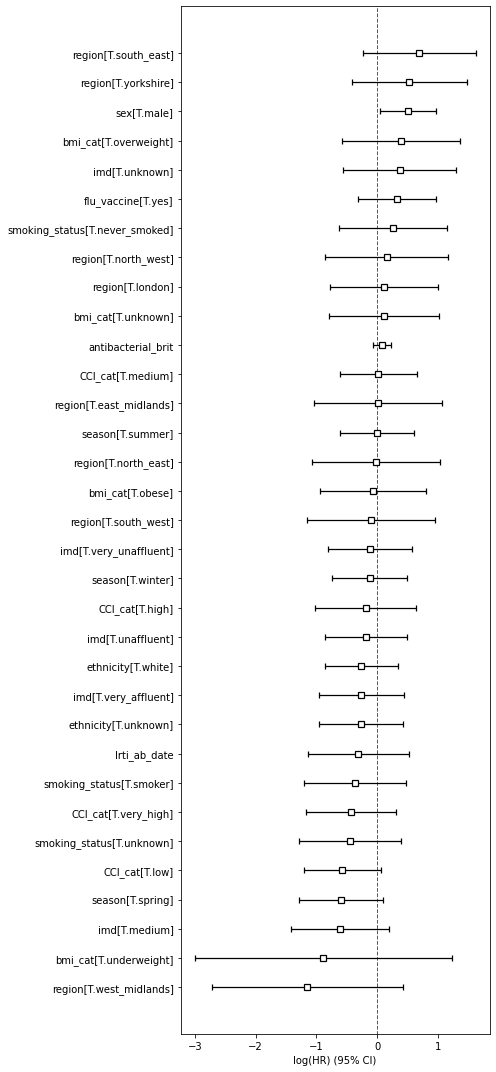

In [140]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_75_more', data_lrti_incdt_75_more_enc)
# make_summary_table_hosped('lrti', 'incdt_75_more', data_lrti_incdt_75_more)

#cox model
cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)

# calculate c-statistics
cph_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

#### 5-10-2- prevalent

<lifelines.CoxPHFitter: fitted with 1182 total observations, 1171 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1182
number of events observed = 11
   partial log-likelihood = -52.85
         time fit was run = 2022-11-02 10:31:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.59       0.20       1.05            -3.64             0.46                 0.03                 1.59
CCI_cat[T.medium]               -0.70       0.50       1.05            -2.75             1.36                 0.06                 3.89
CCI_cat[T.high]                  0.23       1.26       1.17            -2.07             2.53                 0.13                12.52
CCI_cat[T.very_high]            -1.51       0.22       1.31            -4.09             1.07                 0.02                 2.91
antibacterial_brit               0.14       1.15       0.24            -0.33             0.61                 0.72                 1.84
bmi_cat[T.obese]                19.16   2.09e+08   11254.28        -22038.82         22077.14                 0.00                  inf
bmi_cat[T.overweight]           19.42   2.71e+08   11254.28        -22038.56         22077.40                 0.00                  inf
bmi_cat[T.underweight]           0.61       1.83   19823.16        -38852.08         38853.29                 0.00                  inf
bmi_cat[T.unknown]              -0.21       0.81   11960.01        -23441.39         23440.98                 0.00                  inf
ethnicity[T.unknown]           -19.72       0.00    6466.21        -12693.26         12653.82                 0.00                  inf
ethnicity[T.white]              -1.70       0.18       0.77            -3.22            -0.19                 0.04                 0.83
flu_vaccine[T.yes]              -0.13       0.88       1.26            -2.60             2.34                 0.07                10.36
imd[T.medium]                   -0.08       0.92       1.52            -3.07             2.90                 0.05                18.24
imd[T.unaffluent]                1.96       7.07       1.29            -0.58             4.49                 0.56                89.31
imd[T.unknown]                 -18.35       0.00   18409.12        -36099.56         36062.86                 0.00                  inf
imd[T.very_affluent]           -18.05       0.00    8451.00        -16581.70         16545.60                 0.00                  inf
imd[T.very_unaffluent]           0.71       2.02       1.29            -1.82             3.23                 0.16                25.34
lrti_ab_date                     1.20       3.30       0.90            -0.56             2.95                 0.57                19.11
region[T.east_midlands]          0.49       1.64       1.58            -2.60             3.59                 0.07                36.11
region[T.london]                 0.08       1.09       1.38            -2.62             2.79                 0.07                16.22
region[T.north_east]            -0.73       0.48       1.65            -3.97             2.51                 0.02                12.28
region[T.north_west]             0.06       1.06       1.47            -2.82             2.93                 0.06                18.74
region[T.south_east]           -18.17       0.00    9240.45        -18129.12         18092.79                 0.00                  inf
region[T.south_west]            -0.51       0.60       1.58            -3.60             2.58                 0.03                13.26
region[T.west_midlands]        -18.29       0.00    8028.71        -15754.

11524


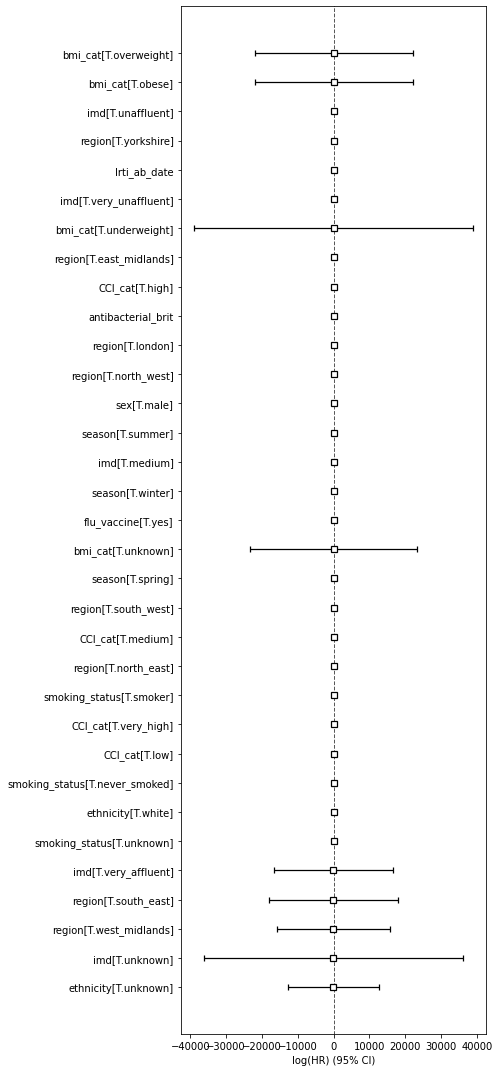

In [141]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_15_24', data_lrti_prevl_15_24_enc)
# make_summary_table_hosped('lrti', 'prevl_15_24', data_lrti_prevl_15_24)

#cox model
cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)

# calculate c-statistics
cph_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 1092 total observations, 1082 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1092
number of events observed = 10
   partial log-likelihood = -48.28
         time fit was run = 2022-11-02 10:31:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.60       1.82       1.19            -1.74             2.94                 0.18                18.83
CCI_cat[T.medium]                0.37       1.45       1.29            -2.16             2.91                 0.11                18.32
CCI_cat[T.high]                -18.29       0.00    6327.59        -12420.13         12383.55                 0.00                  inf
CCI_cat[T.very_high]            -0.80       0.45       1.55            -3.85             2.24                 0.02                 9.36
antibacterial_brit               0.76       2.14       0.29             0.20             1.32                 1.22                 3.76
bmi_cat[T.obese]                -2.84       0.06       1.03            -4.87            -0.82                 0.01                 0.44
bmi_cat[T.overweight]          -19.14       0.00    5153.24        -10119.31         10081.03                 0.00                  inf
bmi_cat[T.underweight]         -19.32       0.00    9718.68        -19067.58         19028.93                 0.00                  inf
bmi_cat[T.unknown]              -1.14       0.32       0.94            -2.97             0.70                 0.05                 2.00
ethnicity[T.unknown]            -0.89       0.41       1.60            -4.03             2.24                 0.02                 9.43
ethnicity[T.white]               0.79       2.21       1.24            -1.64             3.23                 0.19                25.26
flu_vaccine[T.yes]               0.74       2.11       1.28            -1.77             3.26                 0.17                26.04
imd[T.medium]                   -1.94       0.14       1.27            -4.42             0.55                 0.01                 1.73
imd[T.unaffluent]               -0.15       0.86       1.05            -2.21             1.92                 0.11                 6.82
imd[T.unknown]                 -19.82       0.00    7014.07        -13767.15         13727.50                 0.00                  inf
imd[T.very_affluent]            -0.81       0.45       0.97            -2.71             1.09                 0.07                 2.97
imd[T.very_unaffluent]          -1.54       0.21       1.22            -3.94             0.85                 0.02                 2.35
lrti_ab_date                    -0.36       0.70       1.31            -2.92             2.20                 0.05                 9.04
region[T.east_midlands]          1.98       7.23       1.36            -0.69             4.64                 0.50               103.80
region[T.london]                -0.87       0.42       1.55            -3.92             2.17                 0.02                 8.79
region[T.north_east]             0.53       1.70       1.59            -2.58             3.64                 0.08                38.24
region[T.north_west]             1.34       3.84       1.44            -1.48             4.17                 0.23                64.66
region[T.south_east]           -17.99       0.00    8889.45        -17441.00         17405.01                 0.00                  inf
region[T.south_west]           -17.52       0.00   11726.84        -23001.71         22966.67                 0.00                  inf
region[T.west_midlands]        -18.62       0.00    9790.78        -19208.

11493


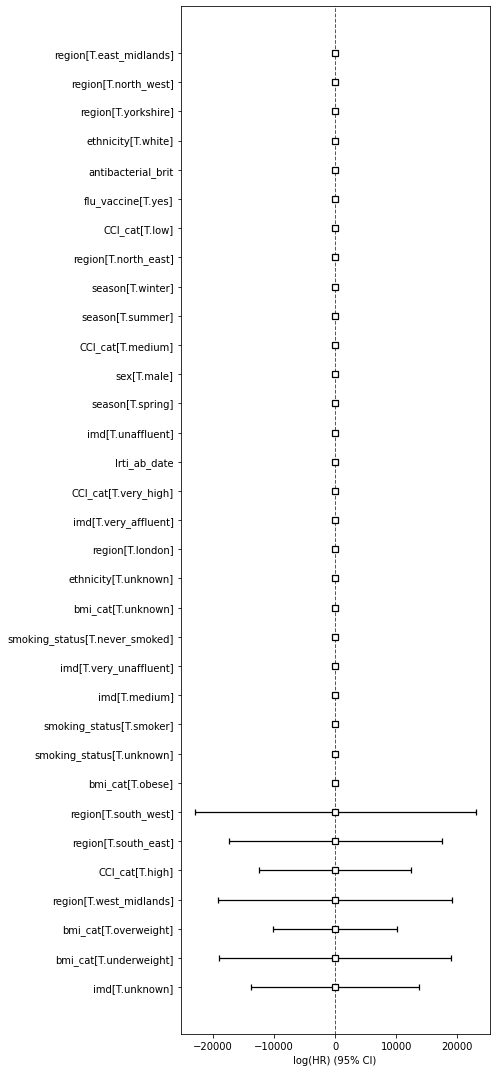

In [142]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_25_34', data_lrti_prevl_25_34_enc)
# make_summary_table_hosped('lrti', 'prevl_25_34', data_lrti_prevl_25_34)

#cox model
cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)

# calculate c-statistics
cph_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 1144 total observations, 1133 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1144
number of events observed = 11
   partial log-likelihood = -59.47
         time fit was run = 2022-11-02 10:31:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.10   7.28e+07    5353.85        -10475.24         10511.45                 0.00                  inf
CCI_cat[T.medium]               18.28   8.71e+07    5353.85        -10475.06         10511.63                 0.00                  inf
CCI_cat[T.high]                 17.46   3.84e+07    5353.85        -10475.88         10510.81                 0.00                  inf
CCI_cat[T.very_high]            17.16   2.83e+07    5353.85        -10476.19         10510.50                 0.00                  inf
antibacterial_brit               0.11       1.12       0.22            -0.32             0.54                 0.73                 1.72
bmi_cat[T.obese]                -0.82       0.44       0.90            -2.59             0.95                 0.07                 2.58
bmi_cat[T.overweight]            0.01       1.01       1.10            -2.15             2.17                 0.12                 8.77
bmi_cat[T.underweight]         -18.51       0.00   13944.14        -27348.52         27311.49                 0.00                  inf
bmi_cat[T.unknown]              -1.19       0.31       1.10            -3.34             0.96                 0.04                 2.62
ethnicity[T.unknown]            -0.50       0.60       0.97            -2.40             1.39                 0.09                 4.03
ethnicity[T.white]              -0.52       0.60       0.88            -2.23             1.20                 0.11                 3.32
flu_vaccine[T.yes]               0.40       1.50       1.13            -1.80             2.61                 0.16                13.61
imd[T.medium]                   -0.99       0.37       0.95            -2.85             0.87                 0.06                 2.39
imd[T.unaffluent]               -1.06       0.35       0.92            -2.85             0.74                 0.06                 2.09
imd[T.unknown]                 -19.10       0.00   14223.71        -27897.06         27858.86                 0.00                  inf
imd[T.very_affluent]            -0.56       0.57       0.92            -2.37             1.25                 0.09                 3.49
imd[T.very_unaffluent]          -1.61       0.20       1.17            -3.90             0.68                 0.02                 1.97
lrti_ab_date                    -0.34       0.71       1.12            -2.53             1.86                 0.08                 6.41
region[T.east_midlands]         -0.11       0.90       1.29            -2.63             2.42                 0.07                11.24
region[T.london]                -0.09       0.91       1.19            -2.42             2.24                 0.09                 9.40
region[T.north_east]           -18.25       0.00    8302.33        -16290.51         16254.01                 0.00                  inf
region[T.north_west]             0.99       2.69       1.19            -1.35             3.33                 0.26                27.90
region[T.south_east]            -0.56       0.57       1.45            -3.39             2.27                 0.03                 9.69
region[T.south_west]           -18.44       0.00    9472.32        -18583.86         18546.97                 0.00                  inf
region[T.west_midlands]         -0.24       0.78       1.45            -3.

11580


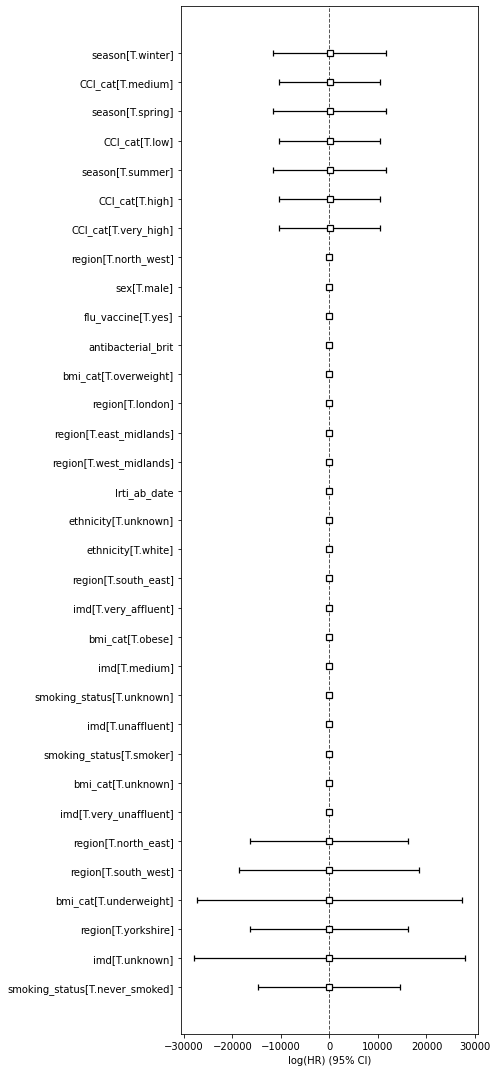

In [143]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_35_44', data_lrti_prevl_35_44_enc)
# make_summary_table_hosped('lrti', 'prevl_35_44', data_lrti_prevl_35_44)

#cox model
cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)

# calculate c-statistics
cph_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 1161 total observations, 1154 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1161
number of events observed = 7
   partial log-likelihood = -26.58
         time fit was run = 2022-11-02 10:31:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  20.95   1.26e+09    8332.87        -16311.17         16353.08                 0.00                  inf
CCI_cat[T.medium]               19.95   4.62e+08    8332.87        -16312.18         16352.08                 0.00                  inf
CCI_cat[T.high]                 -2.11       0.12   12862.04        -25211.24         25207.02                 0.00                  inf
CCI_cat[T.very_high]            19.85   4.18e+08    8332.87        -16312.28         16351.98                 0.00                  inf
antibacterial_brit              -0.01       0.99       0.40            -0.79             0.76                 0.46                 2.15
bmi_cat[T.obese]                 0.15       1.16       1.76            -3.31             3.60                 0.04                36.67
bmi_cat[T.overweight]          -19.10       0.00   10976.43        -21532.50         21494.30                 0.00                  inf
bmi_cat[T.underweight]           3.88      48.28       2.47            -0.96             8.72                 0.38              6109.07
bmi_cat[T.unknown]               0.89       2.43       1.78            -2.59             4.37                 0.07                78.73
ethnicity[T.unknown]             2.16       8.66       1.92            -1.60             5.92                 0.20               370.66
ethnicity[T.white]               0.56       1.75       1.36            -2.11             3.23                 0.12                25.31
flu_vaccine[T.yes]             -20.59       0.00    7896.91        -15498.24         15457.07                 0.00                  inf
imd[T.medium]                    1.30       3.67       1.51            -1.66             4.26                 0.19                70.85
imd[T.unaffluent]              -19.02       0.00    8919.54        -17501.00         17462.96                 0.00                  inf
imd[T.unknown]                   2.75      15.64       1.96            -1.09             6.59                 0.34               724.59
imd[T.very_affluent]           -18.29       0.00    9113.77        -17880.96         17844.38                 0.00                  inf
imd[T.very_unaffluent]           1.46       4.31       1.44            -1.36             4.28                 0.26                72.48
lrti_ab_date                     2.82      16.83       1.52            -0.15             5.80                 0.86               329.41
region[T.east_midlands]         23.53   1.66e+10    9180.49        -17969.90         18016.96                 0.00                  inf
region[T.london]                -0.39       0.68   12223.26        -23957.55         23956.76                 0.00                  inf
region[T.north_east]             1.94       6.97   17412.32        -34125.57         34129.46                 0.00                  inf
region[T.north_west]            18.95   1.69e+08    9180.49        -17974.49         18012.38                 0.00                  inf
region[T.south_east]            20.86   1.15e+09    9180.49        -17972.57         18014.29                 0.00                  inf
region[T.south_west]            22.03   3.69e+09    9180.49        -17971.40         18015.46                 0.00                  inf
region[T.west_midlands]          1.43       4.18   17649.68        -34591.3

11650


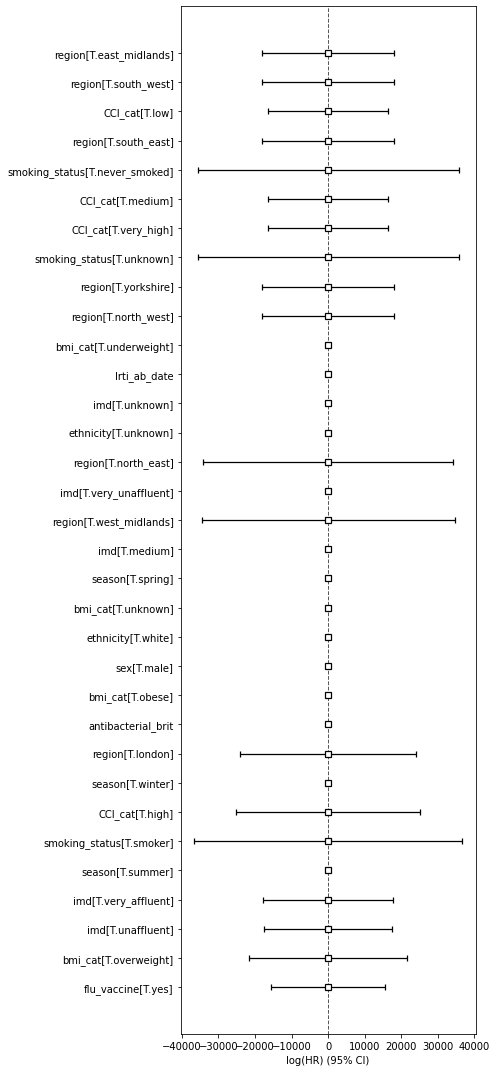

In [144]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_45_54', data_lrti_prevl_45_54_enc)
# make_summary_table_hosped('lrti', 'prevl_45_54', data_lrti_prevl_45_54)

#cox model
cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)

# calculate c-statistics
cph_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 1168 total observations, 1158 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1168
number of events observed = 10
   partial log-likelihood = -49.21
         time fit was run = 2022-11-02 10:31:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.87       0.42       1.04            -2.91             1.17                 0.05                 3.21
CCI_cat[T.medium]               -0.66       0.52       1.29            -3.18             1.86                 0.04                 6.45
CCI_cat[T.high]                  0.17       1.19       1.14            -2.05             2.40                 0.13                11.01
CCI_cat[T.very_high]             0.72       2.05       0.99            -1.23             2.66                 0.29                14.35
antibacterial_brit              -0.23       0.79       0.26            -0.75             0.28                 0.47                 1.33
bmi_cat[T.obese]                -0.20       0.82       1.19            -2.54             2.13                 0.08                 8.42
bmi_cat[T.overweight]            0.84       2.32       1.34            -1.78             3.46                 0.17                31.86
bmi_cat[T.underweight]         -18.65       0.00   12475.70        -24470.56         24433.26                 0.00                  inf
bmi_cat[T.unknown]              -0.73       0.48       1.31            -3.29             1.83                 0.04                 6.22
ethnicity[T.unknown]             0.60       1.83       1.05            -1.45             2.66                 0.23                14.32
ethnicity[T.white]              -0.54       0.58       1.02            -2.54             1.46                 0.08                 4.31
flu_vaccine[T.yes]              -0.68       0.50       1.24            -3.11             1.74                 0.04                 5.68
imd[T.medium]                  -18.38       0.00    6399.60        -12561.37         12524.62                 0.00                  inf
imd[T.unaffluent]                0.77       2.15       0.94            -1.07             2.60                 0.34                13.47
imd[T.unknown]                 -18.37       0.00   10446.22        -20492.57         20455.84                 0.00                  inf
imd[T.very_affluent]             0.36       1.43       1.06            -1.71             2.43                 0.18                11.37
imd[T.very_unaffluent]          -0.35       0.70       1.33            -2.96             2.26                 0.05                 9.58
lrti_ab_date                   -18.37       0.00    8719.42        -17108.12         17071.38                 0.00                  inf
region[T.east_midlands]         18.47   1.05e+08   10337.03        -20241.75         20278.68                 0.00                  inf
region[T.london]                18.39   9.69e+07   10337.03        -20241.82         20278.60                 0.00                  inf
region[T.north_east]            19.05   1.88e+08   10337.03        -20241.16         20279.27                 0.00                  inf
region[T.north_west]            20.06   5.15e+08   10337.03        -20240.15         20280.27                 0.00                  inf
region[T.south_east]            -0.52       0.59   14514.40        -28448.22         28447.18                 0.00                  inf
region[T.south_west]            -0.43       0.65   15402.63        -30189.02         30188.16                 0.00                  inf
region[T.west_midlands]         -0.42       0.66   15318.36        -30023.

11561


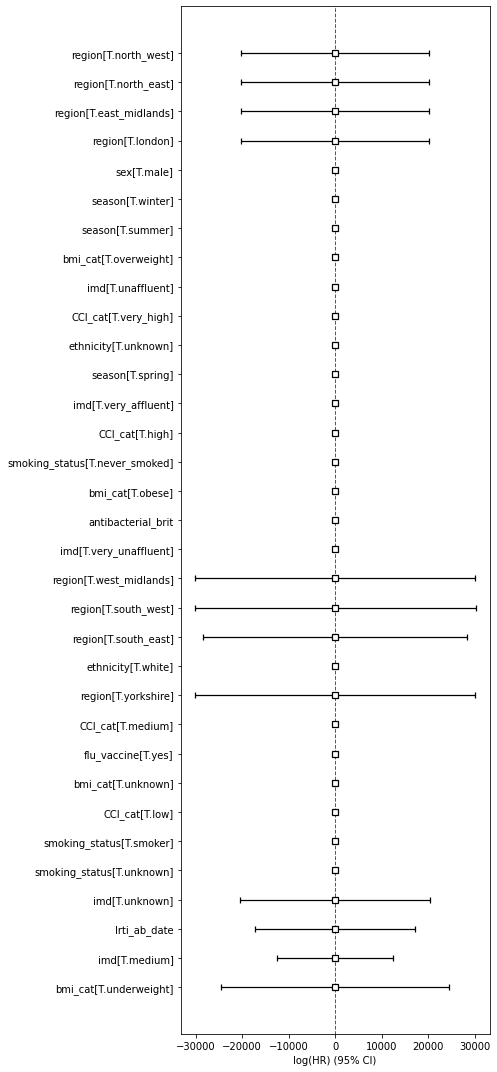

In [145]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_55_64', data_lrti_prevl_55_64_enc)
# make_summary_table_hosped('lrti', 'prevl_55_64', data_lrti_prevl_55_64)

#cox model
cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)

# calculate c-statistics
cph_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 1121 total observations, 1108 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1121
number of events observed = 13
   partial log-likelihood = -63.65
         time fit was run = 2022-11-02 10:31:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.92       2.51       1.15            -1.33             3.18                 0.26                23.93
CCI_cat[T.medium]                0.94       2.55       1.23            -1.47             3.34                 0.23                28.35
CCI_cat[T.high]                  1.01       2.76       1.30            -1.54             3.57                 0.21                35.50
CCI_cat[T.very_high]             0.68       1.97       1.30            -1.86             3.22                 0.16                25.03
antibacterial_brit              -0.13       0.88       0.23            -0.58             0.32                 0.56                 1.37
bmi_cat[T.obese]                 0.21       1.24       1.12            -1.99             2.41                 0.14                11.14
bmi_cat[T.overweight]            0.53       1.70       1.31            -2.04             3.10                 0.13                22.29
bmi_cat[T.underweight]         -18.70       0.00   11862.01        -23267.81         23230.41                 0.00                  inf
bmi_cat[T.unknown]             -18.06       0.00    4358.71         -8560.98          8524.86                 0.00                  inf
ethnicity[T.unknown]            -1.79       0.17       0.98            -3.70             0.13                 0.02                 1.14
ethnicity[T.white]              -1.30       0.27       0.77            -2.82             0.21                 0.06                 1.24
flu_vaccine[T.yes]               1.10       3.00       0.90            -0.66             2.86                 0.52                17.40
imd[T.medium]                  -19.14       0.00    5993.71        -11766.60         11728.32                 0.00                  inf
imd[T.unaffluent]               -0.10       0.91       0.85            -1.77             1.57                 0.17                 4.82
imd[T.unknown]                 -18.53       0.00   11670.12        -22891.55         22854.49                 0.00                  inf
imd[T.very_affluent]           -18.80       0.00    5687.39        -11165.88         11128.29                 0.00                  inf
imd[T.very_unaffluent]           0.37       1.44       0.74            -1.08             1.81                 0.34                 6.11
lrti_ab_date                     0.87       2.39       0.89            -0.86             2.61                 0.42                13.61
region[T.east_midlands]         -0.25       0.78       0.98            -2.17             1.66                 0.11                 5.28
region[T.london]                -0.99       0.37       1.00            -2.96             0.98                 0.05                 2.66
region[T.north_east]            -0.93       0.39       1.23            -3.34             1.47                 0.04                 4.35
region[T.north_west]           -19.46       0.00    7143.08        -14019.64         13980.73                 0.00                  inf
region[T.south_east]            -0.99       0.37       1.28            -3.49             1.51                 0.03                 4.53
region[T.south_west]           -18.99       0.00    7781.49        -15270.43         15232.44                 0.00                  inf
region[T.west_midlands]         -0.30       0.74       0.91            -2.

11511


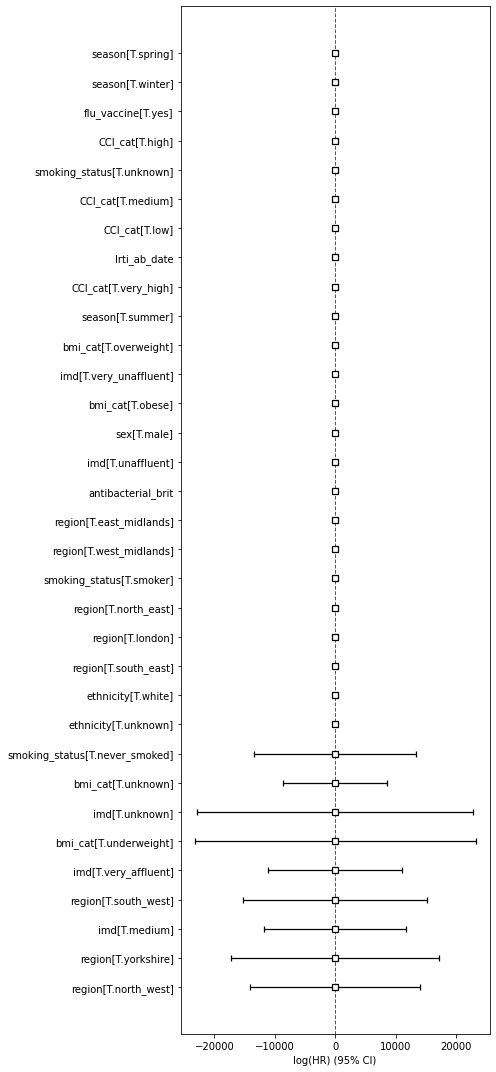

In [146]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_65_74', data_lrti_prevl_65_74_enc)
# make_summary_table_hosped('lrti', 'prevl_65_74', data_lrti_prevl_65_74)

#cox model
cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)

# calculate c-statistics
cph_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

<lifelines.CoxPHFitter: fitted with 1135 total observations, 1131 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1135
number of events observed = 4
   partial log-likelihood = -4.08
         time fit was run = 2022-11-02 10:31:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   5.07     158.48       6.47            -7.61            17.74                 0.00             5.05e+07
CCI_cat[T.medium]                2.22       9.18       6.87           -11.24            15.67                 0.00             6.41e+06
CCI_cat[T.high]                  3.54      34.60      20.33           -36.30            43.38                 0.00             6.94e+18
CCI_cat[T.very_high]             7.88    2635.86       6.44            -4.74            20.50                 0.01             7.99e+08
antibacterial_brit               2.45      11.56       1.43            -0.36             5.26                 0.70               192.11
bmi_cat[T.obese]                -9.29       0.00       5.84           -20.74             2.16                 0.00                 8.69
bmi_cat[T.overweight]           -3.85       0.02       5.12           -13.88             6.19                 0.00               486.01
bmi_cat[T.underweight]          -8.92       0.00      25.73           -59.35            41.51                 0.00             1.07e+18
bmi_cat[T.unknown]              -3.69       0.02       5.31           -14.10             6.72                 0.00               827.08
ethnicity[T.unknown]            -1.93       0.14       5.98           -13.65             9.78                 0.00             17731.86
ethnicity[T.white]               1.89       6.65       2.73            -3.45             7.24                 0.03              1389.92
flu_vaccine[T.yes]               5.50     244.51       4.12            -2.58            13.58                 0.08             7.92e+05
imd[T.medium]                    2.70      14.94       3.55            -4.26             9.67                 0.01             15790.98
imd[T.unaffluent]               -2.54       0.08       7.44           -17.12            12.05                 0.00             1.71e+05
imd[T.unknown]                  -1.43       0.24      13.02           -26.96            24.10                 0.00             2.93e+10
imd[T.very_affluent]            -2.43       0.09       6.49           -15.15            10.29                 0.00             29474.29
imd[T.very_unaffluent]           1.68       5.35       3.43            -5.05             8.41                 0.01              4471.60
lrti_ab_date                     3.93      51.04       3.46            -2.85            10.72                 0.06             45217.39
region[T.east_midlands]          1.34       3.82      13.44           -25.01            27.69                 0.00             1.06e+12
region[T.london]                 5.30     201.05       9.82           -13.94            24.54                 0.00             4.56e+10
region[T.north_east]            -4.43       0.01      11.26           -26.50            17.64                 0.00             4.60e+07
region[T.north_west]             3.66      38.78      10.20           -16.34            23.65                 0.00             1.87e+10
region[T.south_east]            -0.34       0.71      12.15           -24.16            23.48                 0.00             1.57e+10
region[T.south_west]            10.26   28709.30      10.18            -9.69            30.22                 0.00             1.33e+13
region[T.west_midlands]         -1.04       0.36      13.11           -26.73

11575


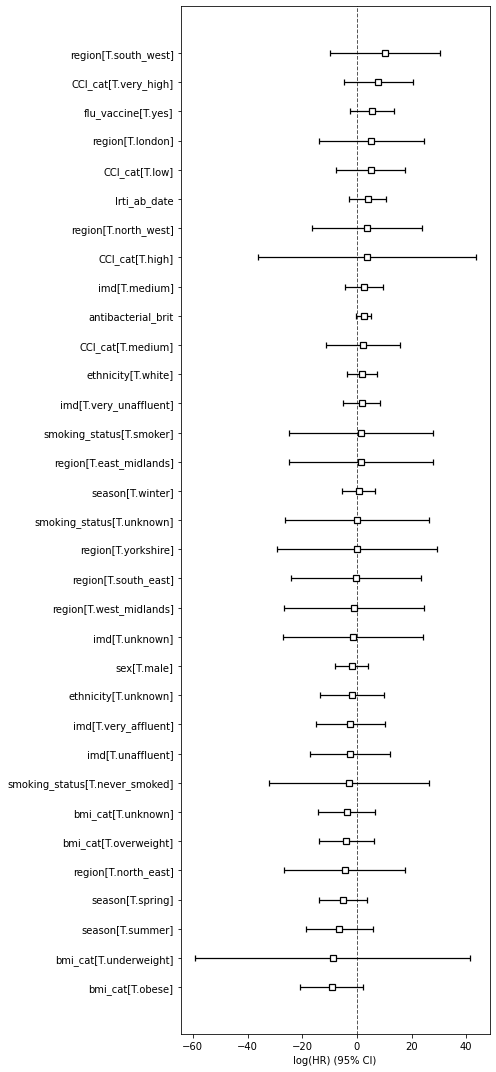

In [147]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_75_more', data_lrti_prevl_75_more_enc)
# make_summary_table_hosped('lrti', 'prevl_75_more', data_lrti_prevl_75_more)

#cox model
cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)

# calculate c-statistics
cph_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

### 5-11- hospital admission related to lrti stratified by antibiotics category
#### 5-11-1- incident

In [148]:
# #data prep
# data, data_lrti_incdt_abtype_0_enc = cox_data_prep(data_lrti_incdt_abtype_0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_abtype_0', data_lrti_incdt_abtype_0_enc)
# make_summary_table_hosped('lrti', 'incdt_abtype_0', data_lrti_incdt_abtype_0)

# #cox model
# cph_lrti_incdt_abtype_0, data_lrti_incdt_abtype_0_train, data_lrti_incdt_abtype_0_test = cox_model_abs_build('lrti', 'incdt_abtype_0', data_lrti_incdt_abtype_0)

# # calculate c-statistics
# cph_output(cph_lrti_incdt_abtype_0, 'lrti', 'incdt_abtype_0', data_lrti_incdt_abtype_0_train, data_lrti_incdt_abtype_0_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [149]:
# #data prep
# data, data_lrti_incdt_abtype_1_enc = cox_data_prep(data_lrti_incdt_abtype_1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_abtype_1', data_lrti_incdt_abtype_1_enc)
# make_summary_table_hosped('lrti', 'incdt_abtype_1', data_lrti_incdt_abtype_1)

# #cox model
# cph_lrti_incdt_abtype_1, data_lrti_incdt_abtype_1_train, data_lrti_incdt_abtype_1_test = cox_model_abs_build('lrti', 'incdt_abtype_1', data_lrti_incdt_abtype_1)

# # calculate c-statistics
# cph_output(cph_lrti_incdt_abtype_1, 'lrti', 'incdt_abtype_1', data_lrti_incdt_abtype_1_train, data_lrti_incdt_abtype_1_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [150]:
# #data prep
# data, data_lrti_incdt_abtype_2_enc = cox_data_prep(data_lrti_incdt_abtype_2, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_abtype_2', data_lrti_incdt_abtype_2_enc)
# make_summary_table_hosped('lrti', 'incdt_abtype_2', data_lrti_incdt_abtype_2)

# #cox model
# cph_lrti_incdt_abtype_2, data_lrti_incdt_abtype_2_train, data_lrti_incdt_abtype_2_test = cox_model_abs_build('lrti', 'incdt_abtype_2', data_lrti_incdt_abtype_2)

# # calculate c-statistics
# cph_output(cph_lrti_incdt_abtype_2, 'lrti', 'incdt_abtype_2', data_lrti_incdt_abtype_2_train, data_lrti_incdt_abtype_2_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [151]:
# #data prep
# data, data_lrti_incdt_abtype_3_enc = cox_data_prep(data_lrti_incdt_abtype_3, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'incdt_abtype_3', data_lrti_incdt_abtype_3_enc)
# make_summary_table_hosped('lrti', 'incdt_abtype_3', data_lrti_incdt_abtype_3)

# #cox model
# cph_lrti_incdt_abtype_3, data_lrti_incdt_abtype_3_train, data_lrti_incdt_abtype_3_test = cox_model_abs_build('lrti', 'incdt_abtype_3', data_lrti_incdt_abtype_3)

# # calculate c-statistics
# cph_output(cph_lrti_incdt_abtype_3, 'lrti', 'incdt_abtype_3', data_lrti_incdt_abtype_3_train, data_lrti_incdt_abtype_3_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

#### 5-11-2- prevalent

In [152]:
# #data prep
# data, data_lrti_prevl_abtype_0_enc = cox_data_prep(data_lrti_prevl_abtype_0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_abtype_0', data_lrti_prevl_abtype_0_enc)
# make_summary_table_hosped('lrti', 'prevl_abtype_0', data_lrti_prevl_abtype_0)

# #cox model
# cph_lrti_prevl_abtype_0, data_lrti_prevl_abtype_0_train, data_lrti_prevl_abtype_0_test = cox_model_abs_build('lrti', 'prevl_abtype_0', data_lrti_prevl_abtype_0)

# # calculate c-statistics
# cph_output(cph_lrti_prevl_abtype_0, 'lrti', 'prevl_abtype_0', data_lrti_prevl_abtype_0_train, data_lrti_prevl_abtype_0_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [153]:
# #data prep
# data, data_lrti_prevl_abtype_1_enc = cox_data_prep(data_lrti_prevl_abtype_1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_abtype_1', data_lrti_prevl_abtype_1_enc)
# make_summary_table_hosped('lrti', 'prevl_abtype_1', data_lrti_prevl_abtype_1)

# #cox model
# cph_lrti_prevl_abtype_1, data_lrti_prevl_abtype_1_train, data_lrti_prevl_abtype_1_test = cox_model_abs_build('lrti', 'prevl_abtype_1', data_lrti_prevl_abtype_1)

# # calculate c-statistics
# cph_output(cph_lrti_prevl_abtype_1, 'lrti', 'prevl_abtype_1', data_lrti_prevl_abtype_1_train, data_lrti_prevl_abtype_1_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [154]:
# #data prep
# data, data_lrti_prevl_abtype_2_enc = cox_data_prep(data_lrti_prevl_abtype_2, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_abtype_2', data_lrti_prevl_abtype_2_enc)
# make_summary_table_hosped('lrti', 'prevl_abtype_2', data_lrti_prevl_abtype_2)

# #cox model
# cph_lrti_prevl_abtype_2, data_lrti_prevl_abtype_2_train, data_lrti_prevl_abtype_2_test = cox_model_abs_build('lrti', 'prevl_abtype_2', data_lrti_prevl_abtype_2)

# # calculate c-statistics
# cph_output(cph_lrti_prevl_abtype_2, 'lrti', 'prevl_abtype_2', data_lrti_prevl_abtype_2_train, data_lrti_prevl_abtype_2_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [155]:
# #data prep
# data, data_lrti_prevl_abtype_3_enc = cox_data_prep(data_lrti_prevl_abtype_3, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary tables from preped data
# make_summary_table('lrti', 'prevl_abtype_3', data_lrti_prevl_abtype_3_enc)
# make_summary_table_hosped('lrti', 'prevl_abtype_3', data_lrti_prevl_abtype_3)

# #cox model
# cph_lrti_prevl_abtype_3, data_lrti_prevl_abtype_3_train, data_lrti_prevl_abtype_3_test = cox_model_abs_build('lrti', 'prevl_abtype_3', data_lrti_prevl_abtype_3)

# # calculate c-statistics
# cph_output(cph_lrti_prevl_abtype_3, 'lrti', 'prevl_abtype_3', data_lrti_prevl_abtype_3_train, data_lrti_prevl_abtype_3_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

## 6- Logistic regression
### 6-1- hospital admission related to incidental lrti with no antibiotics

In [156]:
#data prep for lr
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

In [157]:
def lr_model_build(infection, infection_type, data, data_enc):
    #randomly splitting data into training (%75) and testing (%25)
    data_lr_X_train, data_lr_X_test, data_lr_y_train, data_lr_y_test = train_test_split(data_enc, data['event_'+infection+'_admitted'], test_size=0.25, random_state=42)

    #build LR model
    lr = LogisticRegression().fit(data_lr_X_train, data_lr_y_train)

    #prediction of hsopital admission related to lrti of training data using lr
    pred_proba_train = lr.predict_proba(data_lr_X_train)
    # pred_proba_lrti_no_abs_incdt_train

    #calculate score of lr with training data
    lr_training_score = lr.score(data_lr_X_train, data_lr_y_train)

    #prediction of hsopital admission related to lrti of testing data using lr
    pred_proba_test = lr.predict_proba(data_lr_X_test)
    # pred_proba_lrti_no_abs_incdt_test

    #calculate score of lr_lrti_no_abs_incdt with testing data
    lr_testing_score = lr.score(data_lr_X_test, data_lr_y_test)

    return lr, data_lr_y_train, pred_proba_train, data_lr_y_test, pred_proba_test

In [158]:
#build lr model
lr_lrti_no_abs_incdt, data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test = lr_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt, data_lrti_no_abs_incdt_enc)

In [159]:
# #randomly splitting data into training (%75) and testing (%25)
# data_lrti_no_abs_incdt_lr_X_train, data_lrti_no_abs_incdt_lr_X_test, data_lrti_no_abs_incdt_lr_y_train, data_lrti_no_abs_incdt_lr_y_test = train_test_split(data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt.event_lrti_admitted, test_size=0.25, random_state=42)

# print(f'shape of data_lrti_no_abs_incdt_lr_X for training: {data_lrti_no_abs_incdt_lr_X_train.shape}')
# print(f'shape of data_lrti_no_abs_incdt_lr_X for testing: {data_lrti_no_abs_incdt_lr_X_test.shape}')
# print(f'shape of data_lrti_no_abs_incdt_lr_y for training: {data_lrti_no_abs_incdt_lr_y_train.shape}')
# print(f'shape of data_lrti_no_abs_incdt_lr_y for testing: {data_lrti_no_abs_incdt_lr_y_test.shape}')

In [160]:
# #build LR model
# lr_lrti_no_abs_incdt = LogisticRegression().fit(data_lrti_no_abs_incdt_lr_X_train, data_lrti_no_abs_incdt_lr_y_train)

# #prediction of hsopital admission related to lrti of training data using lr
# pred_proba_lrti_no_abs_incdt_train = lr_lrti_no_abs_incdt.predict_proba(data_lrti_no_abs_incdt_lr_X_train)
# # pred_proba_lrti_no_abs_incdt_train

# #calculate score of lr_lrti_no_abs_incdt with training data
# lr_lrti_no_abs_incdt_training_score = lr_lrti_no_abs_incdt.score(data_lrti_no_abs_incdt_lr_X_train, data_lrti_no_abs_incdt_lr_y_train)
# print(f'score of lr_lrti_no_abs_incdt with training data: {lr_lrti_no_abs_incdt_training_score}')

# #prediction of hsopital admission related to lrti of testing data using lr
# pred_proba_lrti_no_abs_incdt_test = lr_lrti_no_abs_incdt.predict_proba(data_lrti_no_abs_incdt_lr_X_test)
# # pred_proba_lrti_no_abs_incdt_test

# #calculate score of lr_lrti_no_abs_incdt with testing data
# lr_lrti_no_abs_incdt_testing_score = lr_lrti_no_abs_incdt.score(data_lrti_no_abs_incdt_lr_X_test, data_lrti_no_abs_incdt_lr_y_test)
# print(f'score of lr_lrti_no_abs_incdt with testing data: {lr_lrti_no_abs_incdt_testing_score}')

In [161]:
def lr_betas(lr, infection, infection_type):
    # set up coefficients of lr model
    feature_names = lr.feature_names_in_
    coef = np.squeeze(lr.coef_)
    coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
    coef_lr = coef_lr.coefficients.sort_values().reset_index()

    # save coefficients
    coef_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/coef_'+infection+'_'+infection_type+'.csv', index=False)

    # obtain intercept
    interc = lr.intercept_
    # save intercept
    np.savetxt('../output/hospitalisation_prediction_'+infection+'/intercept_'+infection+'_'+infection_type+'.txt', interc, delimiter=',')

    # plot coefficients 
    coef_lr.plot(kind="barh", figsize=(9, 20))
    plt.axvline(x=0, color=".5")
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

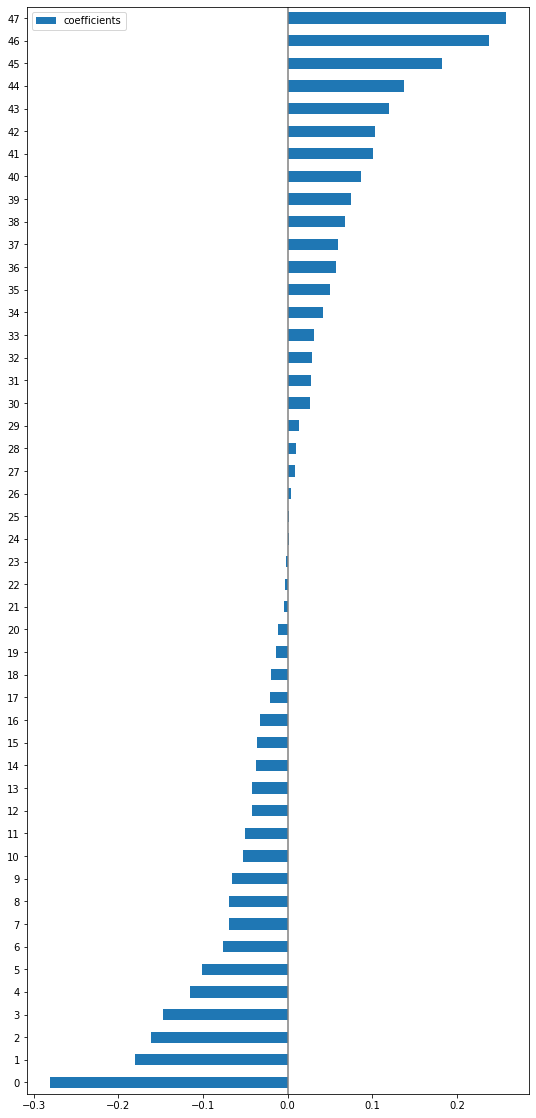

In [162]:
#save betas of lr model
lr_betas(lr_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt')

In [163]:
# # set up coefficients of lr model
# feature_names = lr_lrti_no_abs_incdt.feature_names_in_
# coef = np.squeeze(lr_lrti_no_abs_incdt.coef_)
# coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
# coef_lr = coef_lr.coefficients.sort_values().reset_index()

# # save coefficients
# coef_lr.to_csv('../output/hospitalisation_prediction_lrti/coef_lr_lrti_no_abs_incdt.csv', index=False)

# # obtain intercept
# interc = lr_lrti_no_abs_incdt.intercept_
# # save intercept
# np.savetxt('../output/hospitalisation_prediction_lrti/intercept_lrti_no_abs_incdt.txt', interc, delimiter=',')

# # plot coefficients 
# coef_lr.plot(kind="barh", figsize=(9, 20))
# # plt.title('Coefficients of LR model for incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
# plt.axvline(x=0, color=".5")
# # plt.subplots_adjust(left=0.3)
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_lrti/coef_lr_lrti_no_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [164]:
def lr_roc_curve(infection, infection_type, data_y_train, proba_train, data_y_test, proba_test):
    r_fpr1, r_tpr1, _ = roc_curve(data_y_train, proba_train[:,1])
    r_fpr2, r_tpr2, _ = roc_curve(data_y_test, proba_test[:,1])

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

    squares = [0,1]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15, rotation=0)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

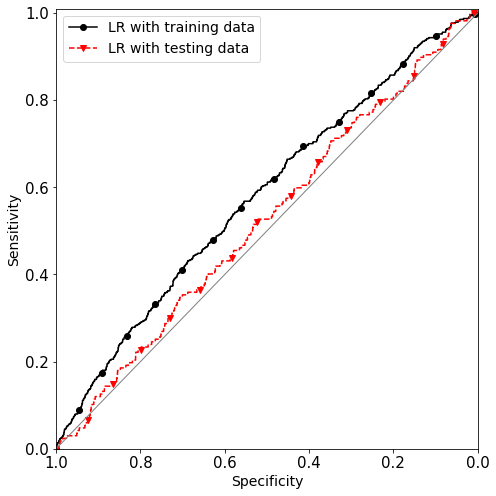

In [165]:
#plot roc curev of lr model
lr_roc_curve('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test)

In [166]:
# r_fpr1, r_tpr1, _ = roc_curve(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1])
# r_fpr2, r_tpr2, _ = roc_curve(data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test[:,1])

# fig, ax1 = pyplot.subplots(figsize=(7, 7))
# line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
# line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

# squares = [0,1]
# plt.plot(squares,linewidth=1, color='grey')
# plt.ylim(0,1.01)
# plt.xlim(0,1)
# plt.xlabel('Specificity', fontsize=14)
# plt.ylabel('Sensitivity', fontsize=14)

# #reversing xticks
# xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
# x = np.arange(len(xticks))
# ax1.set(xticklabels=xticks)
# ax1.legend(fontsize=14)
# # plt.title('ROC curve of LR for hospital admission related to incident \nlrti with no antibiotics', fontsize=16)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15, rotation=0)
# plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_lrti/roc_lr_lrti_no_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [167]:
def lr_pred_calib(infection, infection_type, data_train, pred_proba_train, data_test, pred_proba_test):
    #predict probabilities of training data
    prob_pred_true_train = pd.DataFrame(data=pred_proba_train[:,1])
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train['event_'+infection+'_admitted'], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
    # prob_pred_true_train_groupby_bin
    
    ##
    #predict probabilities of test data
    prob_pred_true_test = pd.DataFrame(data=pred_proba_test[:,1])
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test['event_'+infection+'_admitted'], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
    # prob_pred_true_test_groupby_bin

    #plot calib plot with dev data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calibration_lr_'+infection+'_'+infection_type+'_train.jpg', bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calibration_lr_'+infection+'_'+infection_type+'_test.jpg', bbox_inches='tight')
    plt.show()

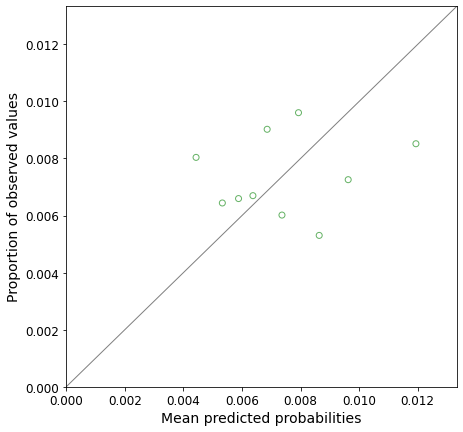

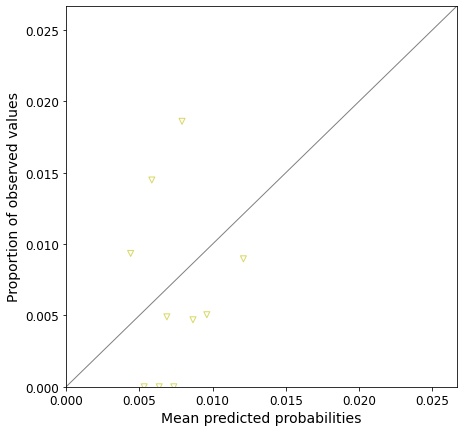

In [168]:
#plot calibration of lr model
lr_pred_calib('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, pred_proba_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, pred_proba_lrti_no_abs_incdt_test)

In [169]:
# #predict probabilities
# prob_pred_true_train = pd.DataFrame(data=pred_proba_lrti_no_abs_incdt_train[:,1])
# prob_pred_true_train.columns = ['pred']

# #group cumulative hazard into 10 bins with equal frequency of observations in each bin
# prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

# #merge cumulative hazards with their actual events (0, 1)
# prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_no_abs_incdt_train.event_lrti_admitted, left_index=True, right_index=True)

# #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
# prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
# prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

# #calculate proportion of events in each bin
# prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# # prob_pred_true_train_groupby_bin

In [170]:
# #predict probabilities
# prob_pred_true_test = pd.DataFrame(data=pred_proba_lrti_no_abs_incdt_test[:,1])
# prob_pred_true_test.columns = ['pred']

# #group cumulative hazard into 10 bins with equal frequency of observations in each bin
# prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

# #merge cumulative hazards with their actual events (0, 1)
# prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_no_abs_incdt_test.event_lrti_admitted, left_index=True, right_index=True)

# #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
# prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
# prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

# #calculate proportion of events in each bin
# prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# # prob_pred_true_test_groupby_bin

In [171]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [172]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [173]:
# fig, axe = plt.subplots(figsize=(8, 8))
# calib_lr_lrti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1], ax = axe)
# # plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
# plt.xlabel('Mean predicted probability', fontsize=14)
# plt.ylabel('Fraction of positives', fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid(visible=bool, linestyle='--')
# plt.xlim(0, 0.1)
# plt.ylim(0, 0.1)
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_lrti/calib_lr_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [174]:
def lr_auroc_brier(infection, infection_type, data_y_train, pred_proba_train, data_y_test, pred_proba_test):
    # calculate AUROC and Brier score of lr model
    r_auc1 = roc_auc_score(data_y_train, pred_proba_train[:,1])
    r_auc2 = roc_auc_score(data_y_test, pred_proba_test[:,1])
    brier1 = brier_score_loss(data_y_train, pred_proba_train[:,1])
    brier2 = brier_score_loss(data_y_test, pred_proba_test[:,1])

    # save model outputs
    a = open("../output/hospitalisation_prediction_"+infection+"/lr_"+infection+"_"+infection_type+"_output.txt", "w")
    a.write("")
    a.writelines(['AUROC_dev '+infection+' '+infection_type+' = %.4f' % (r_auc1),
                '\nAUROC_val '+infection+' '+infection_type+' = %.4f' % (r_auc2),
                '\nBrier_dev '+infection+' '+infection_type+' = %.4f' % (brier1),
                '\nBrier_val '+infection+' '+infection_type+' = %.4f' % (brier2)])

In [175]:
#save auroc and brier of lr model
lr_auroc_brier('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test)

In [176]:
# # calculate AUROC and Brier score of lr model
# r_auc1 = roc_auc_score(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1])
# r_auc2 = roc_auc_score(data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test[:,1])
# brier1 = brier_score_loss(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1])
# brier2 = brier_score_loss(data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test[:,1])

# # save model outputs
# a = open("../output/hospitalisation_prediction_lrti/lr_lrti_no_abs_incdt_output.txt", "w")
# a.write("")
# a.writelines(['AUROC of LR with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc1),
#               '\nAUROC of LR with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc2),
#               '\nBrier score of LR with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier1),
#               '\nBrier score of LR with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier2)])

### 6-2- hospital admission related to incident lrti with antibiotics

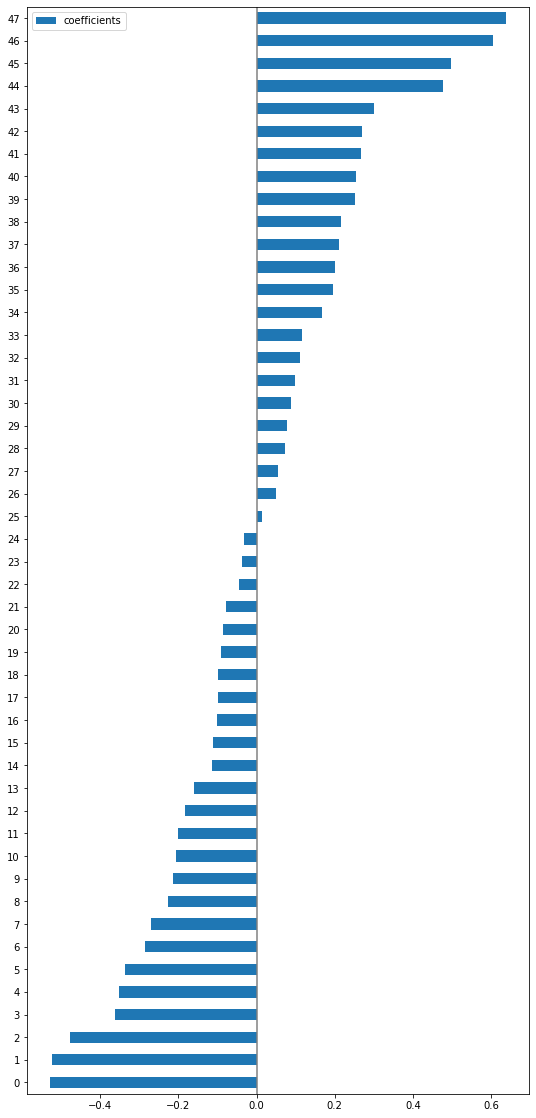

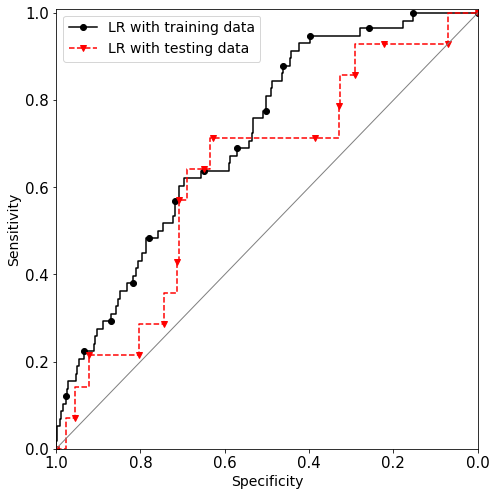

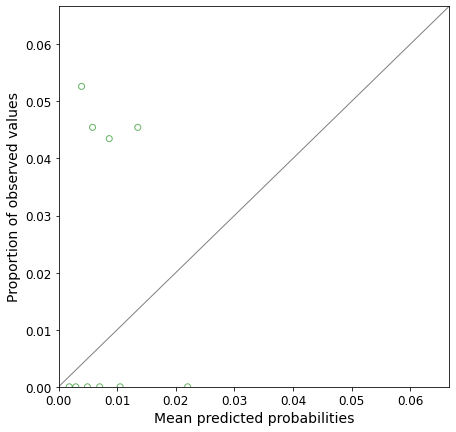

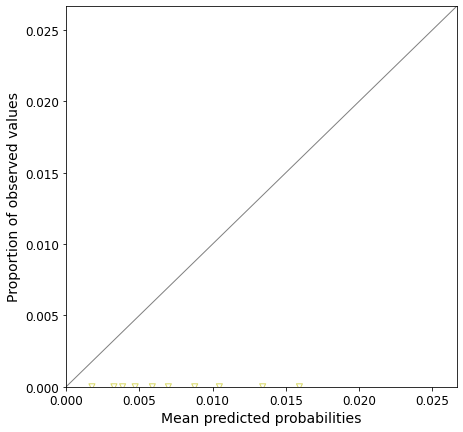

In [177]:
#data prep for lr
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#build lr model
lr_lrti_abs_incdt, data_lrti_abs_incdt_lr_y_train, pred_proba_lrti_abs_incdt_train, data_lrti_abs_incdt_lr_y_test, pred_proba_lrti_abs_incdt_test = lr_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt, data_lrti_abs_incdt_enc)

#save betas of lr model
lr_betas(lr_lrti_abs_incdt, 'lrti', 'abs_incdt')

#plot roc curev of lr model
lr_roc_curve('lrti', 'abs_incdt', data_lrti_abs_incdt_lr_y_train, pred_proba_lrti_abs_incdt_train, data_lrti_abs_incdt_lr_y_test, pred_proba_lrti_abs_incdt_test)

#plot calibration of lr model
lr_pred_calib('lrti', 'abs_incdt', data_lrti_abs_incdt_train, pred_proba_lrti_abs_incdt_train, data_lrti_abs_incdt_test, pred_proba_lrti_abs_incdt_test)

#save auroc and brier of lr model
lr_auroc_brier('lrti', 'abs_incdt', data_lrti_abs_incdt_lr_y_train, pred_proba_lrti_abs_incdt_train, data_lrti_abs_incdt_lr_y_test, pred_proba_lrti_abs_incdt_test)

### 6-3- hospital admission related to prevalent lrti with no antibiotics

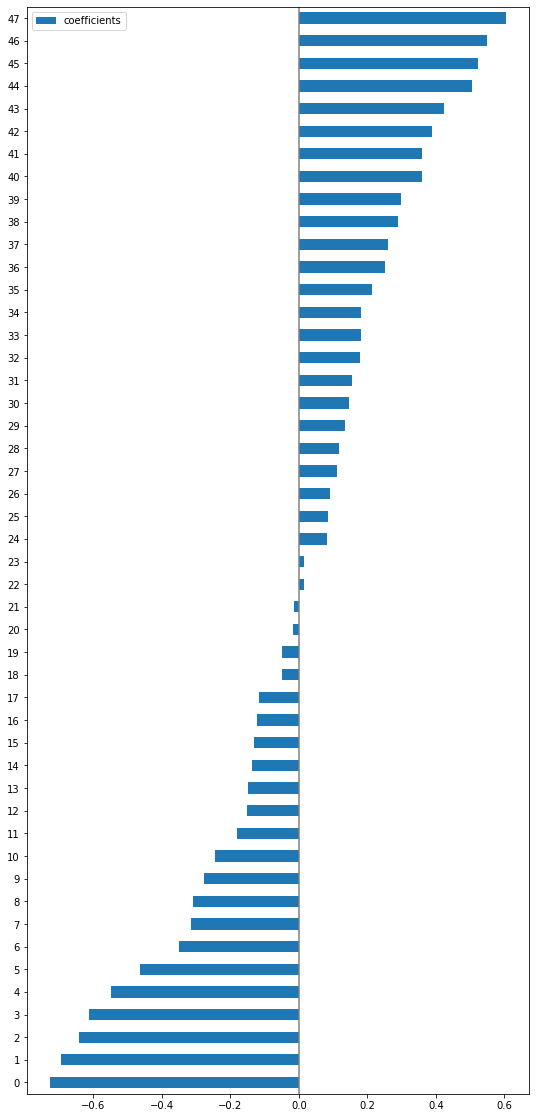

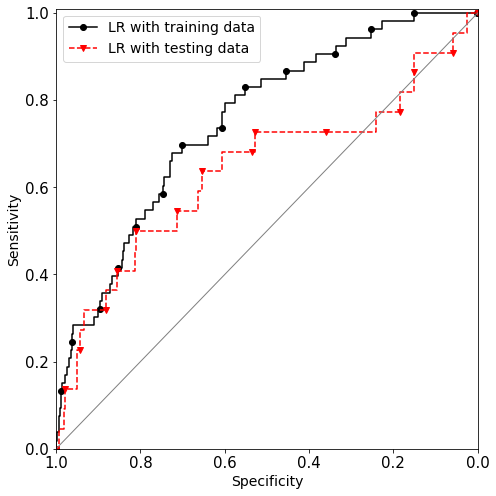

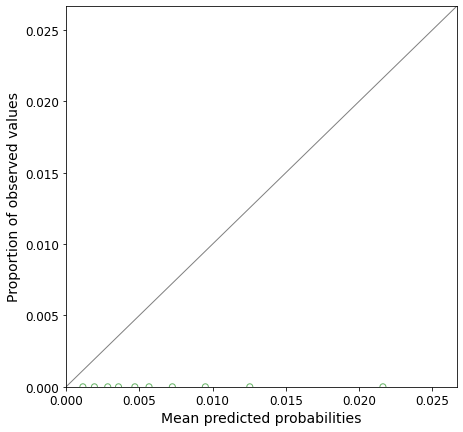

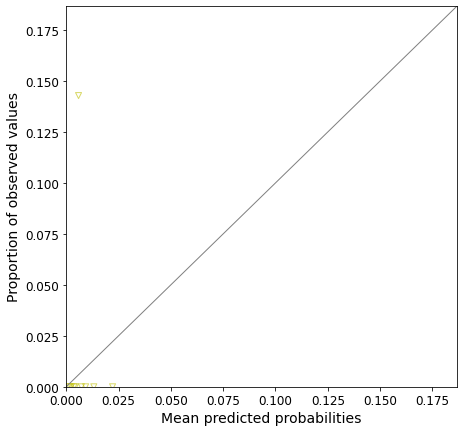

In [178]:
#data prep for lr
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#build lr model
lr_lrti_no_abs_prevl, data_lrti_no_abs_prevl_lr_y_train, pred_proba_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_lr_y_test, pred_proba_lrti_no_abs_prevl_test = lr_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl, data_lrti_no_abs_prevl_enc)

#save betas of lr model
lr_betas(lr_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl')

#plot roc curev of lr model
lr_roc_curve('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_lr_y_train, pred_proba_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_lr_y_test, pred_proba_lrti_no_abs_prevl_test)

#plot calibration of lr model
lr_pred_calib('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, pred_proba_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, pred_proba_lrti_no_abs_prevl_test)

#save auroc and brier of lr model
lr_auroc_brier('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_lr_y_train, pred_proba_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_lr_y_test, pred_proba_lrti_no_abs_prevl_test)

### 6-4- hospital admission related to prevalent lrti with antibiotics

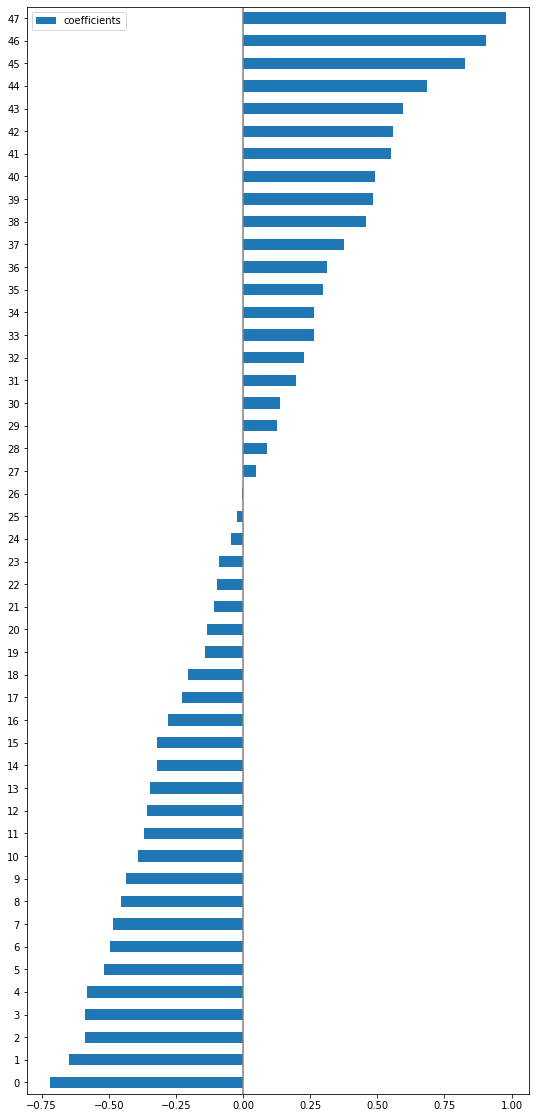

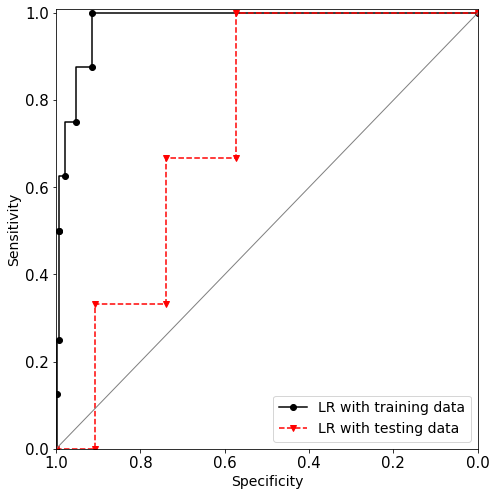

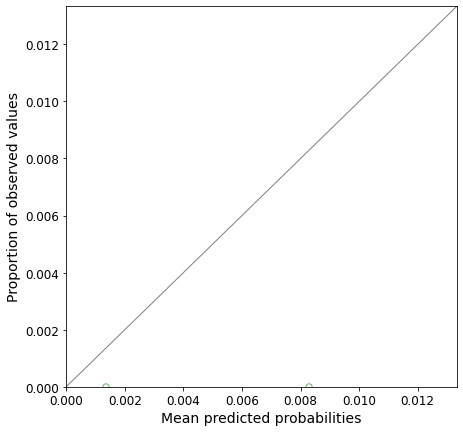

AttributeError: 'float' object has no attribute 'round'

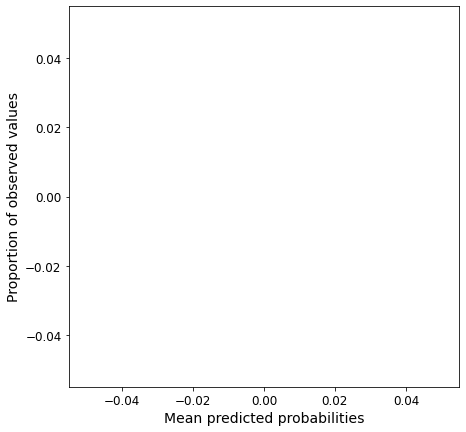

In [179]:
#data prep for lr
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#build lr model
lr_lrti_abs_prevl, data_lrti_abs_prevl_lr_y_train, pred_proba_lrti_abs_prevl_train, data_lrti_abs_prevl_lr_y_test, pred_proba_lrti_abs_prevl_test = lr_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl, data_lrti_abs_prevl_enc)

#save betas of lr model
lr_betas(lr_lrti_abs_prevl, 'lrti', 'abs_prevl')

#plot roc curev of lr model
lr_roc_curve('lrti', 'abs_prevl', data_lrti_abs_prevl_lr_y_train, pred_proba_lrti_abs_prevl_train, data_lrti_abs_prevl_lr_y_test, pred_proba_lrti_abs_prevl_test)

#plot calibration of lr model
lr_pred_calib('lrti', 'abs_prevl', data_lrti_abs_prevl_train, pred_proba_lrti_abs_prevl_train, data_lrti_abs_prevl_test, pred_proba_lrti_abs_prevl_test)

#save auroc and brier of lr model
lr_auroc_brier('lrti', 'abs_prevl', data_lrti_abs_prevl_lr_y_train, pred_proba_lrti_abs_prevl_train, data_lrti_abs_prevl_lr_y_test, pred_proba_lrti_abs_prevl_test)